/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda
Train Size: 30000
Val Size: 7500
Index to class dictionary: {0: 'no', 1: 'vort', 2: 'sphere'}
Class to index dictionary: {'no': 0, 'vort': 1, 'sphere': 2}


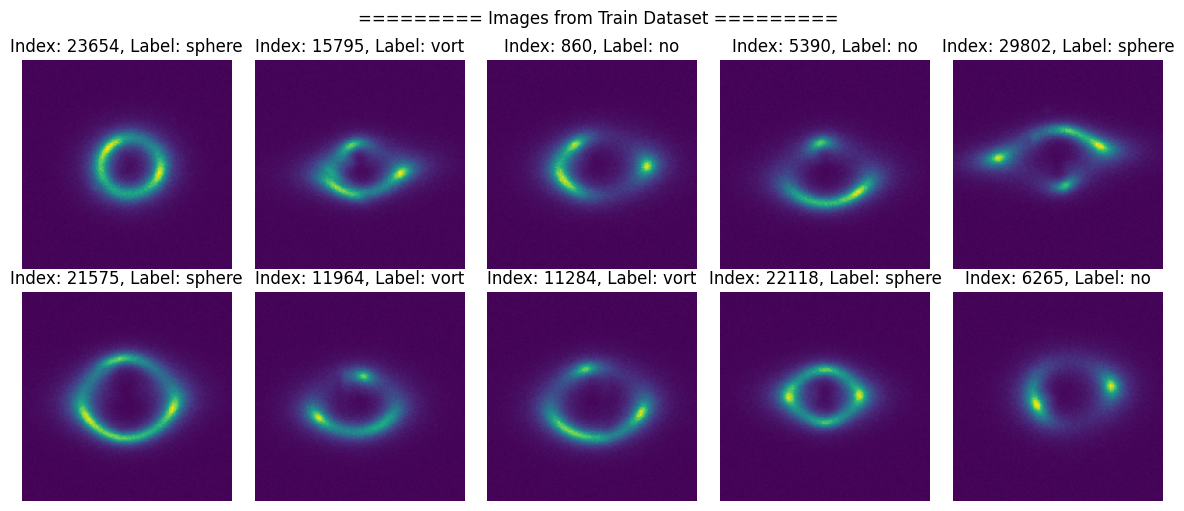

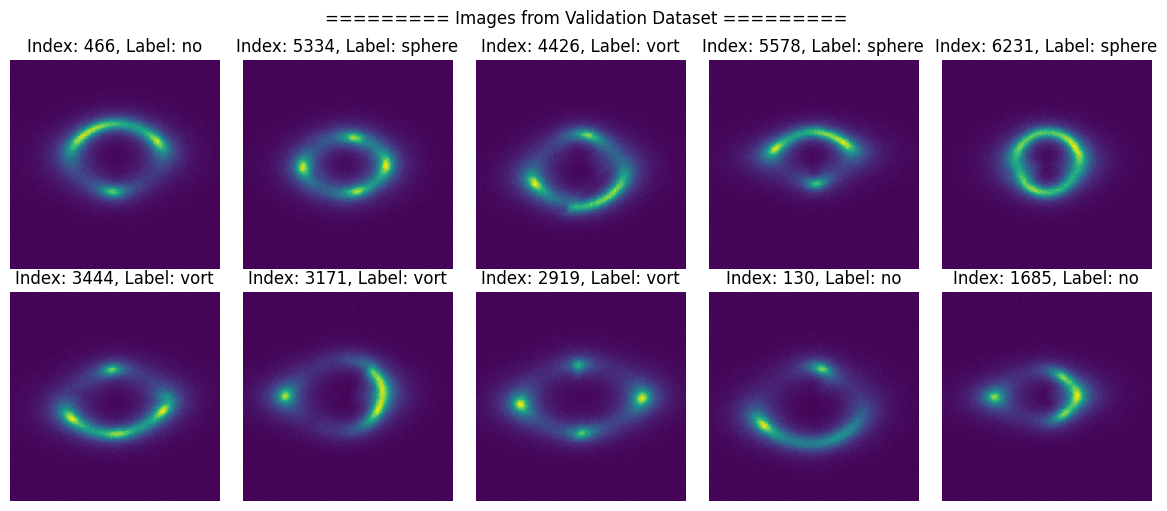

In [1]:
!pip install opencv-python
!pip install timm
!pip install albumentations

import os
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import platform
from tqdm import tqdm
import random
import glob
import copy
from dataclasses import dataclass
import time
from collections import Counter, defaultdict
import gc

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.nn.functional as F
import timm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class CONFIG:
    TRAIN_PATH = "/kaggle/input/deeplense-common-test-dataset/dataset - Copy/dataset/train"
    VAL_PATH = "/kaggle/input/deeplense-common-test-dataset/dataset - Copy/dataset/val"
    BATCH_SIZE = 64  # For DenseNet models
    LEARNING_RATE = 1e-4
    DROPOUT = 0.33
    EPOCHS = 10  # For individual models
    ENSEMBLE_EPOCHS = 10  # For ensemble model

# Get file paths for training and validation sets
train_image_paths = []
val_image_paths = []
classes = []

for train_data_path in glob.glob(CONFIG.TRAIN_PATH + "/*"):
    classes.append(train_data_path.split("/")[-1])
    train_image_paths.append(glob.glob(train_data_path + "/*"))

for val_data_path in glob.glob(CONFIG.VAL_PATH + "/*"):
    val_image_paths.append(glob.glob(val_data_path + "/*"))

train_image_paths = list(flatten(train_image_paths))
val_image_paths = list(flatten(val_image_paths))

print(f"Train Size: {len(train_image_paths)}")
print(f"Val Size: {len(val_image_paths)}")

# Map indices to classes and vice-versa
idx_to_class = {i: j for i, j in enumerate(classes)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

print(f"Index to class dictionary: {idx_to_class}")
print(f"Class to index dictionary: {class_to_idx}")

class GSoCDeepLenseDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = np.load(image_filepath)

        # Add channel dimension if needed
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=0)

        # Convert to tensor
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        label = image_filepath.split("/")[-2]
        label = class_to_idx[label]

        return image, label

# Create datasets and dataloaders with pin_memory for faster GPU transfers
train_dataset = GSoCDeepLenseDataset(image_paths=train_image_paths)
val_dataset = GSoCDeepLenseDataset(image_paths=val_image_paths)

train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

def visualize_images(dataset, dataset_type="train", samples=20, cols=5):
    dataset_len = len(dataset)
    rows = samples // cols

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    fig.suptitle(f"========= Images from {dataset_type.title()} Dataset =========", y=0.9)

    for i in range(samples):
        idx = np.random.randint(0, dataset_len)
        image, label = dataset[idx]
        image = image.swapaxes(0, 1).swapaxes(1, 2)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f"Index: {idx}, Label: {idx_to_class[label]}")

    plt.tight_layout(rect=[0, 0.2, 0.99, 0.975], h_pad=2.1, pad=1.7)
    plt.show()

# Example usage:
visualize_images(train_dataset, dataset_type="train", samples=10, cols=5)
visualize_images(val_dataset, dataset_type="validation", samples=10, cols=5)

# DenseNet161 Model
class DenseNet161Model(nn.Module):
    def __init__(self, n_classes=3):
        super(DenseNet161Model, self).__init__()
        self.transfer_learning_model = timm.create_model('densenet161', pretrained=True, in_chans=1)
        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Linear(2208 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
        x = x.view(-1, 2208 * 4 * 4)
        x = self.classifier(x)
        return x

# DenseNet201 Model
class DenseNet201Model(nn.Module):
    def __init__(self, n_classes=3):
        super(DenseNet201Model, self).__init__()
        self.transfer_learning_model = timm.create_model('densenet201', pretrained=True, in_chans=1)
        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Linear(1920 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
        x = x.view(-1, 1920 * 4 * 4)
        x = self.classifier(x)
        return x

# Ensemble Model
class DenseNetEnsemble(nn.Module):
    def __init__(self, n_classes=3, modela=None, modelb=None):
        super(DenseNetEnsemble, self).__init__()
        if modela is None:
            self.modela = DenseNet161Model(n_classes)
        else:
            self.modela = modela

        if modelb is None:
            self.modelb = DenseNet201Model(n_classes)
        else:
            self.modelb = modelb

    def forward(self, x):
        outa = self.modela(x)
        outb = self.modelb(x)
        return (outa + outb) / 2

def train_one_epoch(model, optimizer, data_loader):
    model.train()
    total = 0
    correct = 0
    train_accuracy = []
    train_loss = []

    for i, data in enumerate(tqdm(data_loader)):
        images, labels = data
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        y_pred = model(images)
        loss = criterion(y_pred, labels)

        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Batch {i}: Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

        train_accuracy.append(torch.tensor(accuracy))
        train_loss.append(torch.tensor(loss))

    return train_accuracy, train_loss

def test_model(model, data_loader):
    model.eval()
    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []

    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            y_pred = model(images)
            loss = criterion(y_pred, labels)
            probs = F.softmax(y_pred, dim=1)

            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total

            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return val_accuracy, val_loss, np.array(all_labels), np.array(all_predictions), np.array(all_probs)

def convert_tensor_list_to_single_mean_value(tensor_list):
    tensor_list = [tensor.detach().cpu().numpy() for tensor in tensor_list]
    return np.mean(tensor_list)


Using device: cuda
Initializing DenseNet161 Model...


model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]


Epoch 1/10 - Training DenseNet161
--------------------


  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-1-40bd5bd050bb>:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss.append(torch.tensor(loss))
  0%|          | 1/469 [00:02<15:49,  2.03s/it]

Batch 0: Loss: 1.2050, Accuracy: 39.06%


  2%|▏         | 11/469 [00:05<03:22,  2.26it/s]

Batch 10: Loss: 1.1678, Accuracy: 37.07%


  4%|▍         | 21/469 [00:09<03:12,  2.33it/s]

Batch 20: Loss: 1.1836, Accuracy: 37.43%


  7%|▋         | 31/469 [00:13<03:07,  2.34it/s]

Batch 30: Loss: 1.1482, Accuracy: 37.10%


  9%|▊         | 41/469 [00:17<03:03,  2.33it/s]

Batch 40: Loss: 1.2749, Accuracy: 36.81%


 11%|█         | 51/469 [00:20<02:59,  2.33it/s]

Batch 50: Loss: 1.2084, Accuracy: 36.86%


 13%|█▎        | 61/469 [00:24<02:54,  2.34it/s]

Batch 60: Loss: 1.0509, Accuracy: 37.50%


 15%|█▌        | 71/469 [00:28<02:50,  2.33it/s]

Batch 70: Loss: 1.1412, Accuracy: 37.96%


 17%|█▋        | 81/469 [00:32<02:46,  2.34it/s]

Batch 80: Loss: 1.1388, Accuracy: 38.85%


 19%|█▉        | 91/469 [00:36<02:41,  2.33it/s]

Batch 90: Loss: 1.1240, Accuracy: 38.86%


 22%|██▏       | 101/469 [00:39<02:37,  2.33it/s]

Batch 100: Loss: 1.1226, Accuracy: 39.45%


 24%|██▎       | 111/469 [00:43<02:33,  2.33it/s]

Batch 110: Loss: 1.0526, Accuracy: 40.26%


 26%|██▌       | 121/469 [00:47<02:29,  2.33it/s]

Batch 120: Loss: 1.0936, Accuracy: 40.75%


 28%|██▊       | 131/469 [00:51<02:24,  2.33it/s]

Batch 130: Loss: 1.0379, Accuracy: 41.21%


 30%|███       | 141/469 [00:55<02:20,  2.33it/s]

Batch 140: Loss: 0.9149, Accuracy: 41.68%


 32%|███▏      | 151/469 [00:58<02:16,  2.33it/s]

Batch 150: Loss: 0.9708, Accuracy: 42.34%


 34%|███▍      | 161/469 [01:02<02:11,  2.34it/s]

Batch 160: Loss: 0.9243, Accuracy: 42.94%


 36%|███▋      | 171/469 [01:06<02:07,  2.33it/s]

Batch 170: Loss: 0.9243, Accuracy: 43.52%


 39%|███▊      | 181/469 [01:10<02:03,  2.33it/s]

Batch 180: Loss: 0.9275, Accuracy: 44.19%


 41%|████      | 191/469 [01:13<01:59,  2.33it/s]

Batch 190: Loss: 0.9167, Accuracy: 44.89%


 43%|████▎     | 201/469 [01:17<01:54,  2.33it/s]

Batch 200: Loss: 0.9428, Accuracy: 45.48%


 45%|████▍     | 211/469 [01:21<01:50,  2.33it/s]

Batch 210: Loss: 1.0364, Accuracy: 46.07%


 47%|████▋     | 221/469 [01:25<02:03,  2.01it/s]

Batch 220: Loss: 0.9194, Accuracy: 46.74%


 49%|████▉     | 231/469 [01:29<01:42,  2.33it/s]

Batch 230: Loss: 1.0626, Accuracy: 47.50%


 51%|█████▏    | 241/469 [01:33<01:37,  2.33it/s]

Batch 240: Loss: 0.5869, Accuracy: 48.24%


 54%|█████▎    | 251/469 [01:36<01:33,  2.33it/s]

Batch 250: Loss: 0.6997, Accuracy: 48.92%


 56%|█████▌    | 261/469 [01:40<01:29,  2.33it/s]

Batch 260: Loss: 0.7499, Accuracy: 49.60%


 58%|█████▊    | 271/469 [01:44<01:24,  2.33it/s]

Batch 270: Loss: 0.8866, Accuracy: 50.20%


 60%|█████▉    | 281/469 [01:48<01:20,  2.33it/s]

Batch 280: Loss: 0.5896, Accuracy: 50.84%


 62%|██████▏   | 291/469 [01:52<01:16,  2.33it/s]

Batch 290: Loss: 0.7010, Accuracy: 51.44%


 64%|██████▍   | 301/469 [01:55<01:12,  2.33it/s]

Batch 300: Loss: 0.6233, Accuracy: 52.09%


 66%|██████▋   | 311/469 [01:59<01:07,  2.33it/s]

Batch 310: Loss: 0.5711, Accuracy: 52.65%


 68%|██████▊   | 321/469 [02:03<01:03,  2.33it/s]

Batch 320: Loss: 0.8438, Accuracy: 53.16%


 71%|███████   | 331/469 [02:07<00:59,  2.33it/s]

Batch 330: Loss: 0.8140, Accuracy: 53.81%


 73%|███████▎  | 341/469 [02:11<00:54,  2.34it/s]

Batch 340: Loss: 0.5917, Accuracy: 54.45%


 75%|███████▍  | 351/469 [02:14<00:50,  2.33it/s]

Batch 350: Loss: 0.6094, Accuracy: 54.98%


 77%|███████▋  | 361/469 [02:18<00:46,  2.33it/s]

Batch 360: Loss: 0.6818, Accuracy: 55.52%


 79%|███████▉  | 371/469 [02:22<00:41,  2.34it/s]

Batch 370: Loss: 0.4403, Accuracy: 56.06%


 81%|████████  | 381/469 [02:26<00:37,  2.33it/s]

Batch 380: Loss: 0.4811, Accuracy: 56.56%


 83%|████████▎ | 391/469 [02:29<00:33,  2.33it/s]

Batch 390: Loss: 0.5749, Accuracy: 57.13%


 86%|████████▌ | 401/469 [02:33<00:29,  2.33it/s]

Batch 400: Loss: 0.7049, Accuracy: 57.59%


 88%|████████▊ | 411/469 [02:37<00:24,  2.33it/s]

Batch 410: Loss: 0.4827, Accuracy: 58.18%


 90%|████████▉ | 421/469 [02:41<00:20,  2.33it/s]

Batch 420: Loss: 0.4486, Accuracy: 58.66%


 92%|█████████▏| 431/469 [02:45<00:16,  2.33it/s]

Batch 430: Loss: 0.5953, Accuracy: 59.15%


 94%|█████████▍| 441/469 [02:48<00:12,  2.33it/s]

Batch 440: Loss: 0.4776, Accuracy: 59.59%


 96%|█████████▌| 451/469 [02:52<00:07,  2.33it/s]

Batch 450: Loss: 0.4130, Accuracy: 60.06%


 98%|█████████▊| 461/469 [02:56<00:03,  2.33it/s]

Batch 460: Loss: 0.4844, Accuracy: 60.43%


100%|██████████| 469/469 [02:59<00:00,  2.61it/s]


Train loss: 0.8366, Train accuracy: 47.87%


  0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-1-40bd5bd050bb>:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss.append(torch.tensor(loss))
100%|██████████| 118/118 [00:18<00:00,  6.31it/s]


Val loss: 0.5008, Val accuracy: 85.76%
New best DenseNet161 model saved with accuracy: 85.76%

Epoch 2/10 - Training DenseNet161
--------------------


  0%|          | 1/469 [00:00<04:12,  1.85it/s]

Batch 0: Loss: 0.3655, Accuracy: 87.50%


  2%|▏         | 11/469 [00:04<03:16,  2.33it/s]

Batch 10: Loss: 0.3626, Accuracy: 82.53%


  4%|▍         | 21/469 [00:08<03:11,  2.33it/s]

Batch 20: Loss: 0.3226, Accuracy: 82.29%


  7%|▋         | 31/469 [00:11<03:07,  2.33it/s]

Batch 30: Loss: 0.4834, Accuracy: 81.55%


  9%|▊         | 41/469 [00:15<03:03,  2.33it/s]

Batch 40: Loss: 0.4345, Accuracy: 81.33%


 11%|█         | 51/469 [00:19<02:58,  2.34it/s]

Batch 50: Loss: 0.3509, Accuracy: 81.80%


 13%|█▎        | 61/469 [00:23<02:54,  2.33it/s]

Batch 60: Loss: 0.4228, Accuracy: 82.20%


 15%|█▌        | 71/469 [00:27<02:50,  2.33it/s]

Batch 70: Loss: 0.5448, Accuracy: 82.64%


 17%|█▋        | 81/469 [00:30<02:46,  2.33it/s]

Batch 80: Loss: 0.5630, Accuracy: 82.14%


 19%|█▉        | 91/469 [00:34<02:42,  2.33it/s]

Batch 90: Loss: 0.3992, Accuracy: 82.52%


 22%|██▏       | 101/469 [00:38<02:37,  2.33it/s]

Batch 100: Loss: 0.3681, Accuracy: 82.74%


 24%|██▎       | 111/469 [00:42<02:33,  2.33it/s]

Batch 110: Loss: 0.3894, Accuracy: 82.71%


 26%|██▌       | 121/469 [00:46<02:29,  2.33it/s]

Batch 120: Loss: 0.4693, Accuracy: 82.59%


 28%|██▊       | 131/469 [00:49<02:24,  2.33it/s]

Batch 130: Loss: 0.5220, Accuracy: 82.75%


 30%|███       | 141/469 [00:53<02:20,  2.33it/s]

Batch 140: Loss: 0.4285, Accuracy: 82.83%


 32%|███▏      | 151/469 [00:57<02:16,  2.33it/s]

Batch 150: Loss: 0.2395, Accuracy: 82.93%


 34%|███▍      | 161/469 [01:01<02:12,  2.33it/s]

Batch 160: Loss: 0.3951, Accuracy: 82.97%


 36%|███▋      | 171/469 [01:04<02:07,  2.33it/s]

Batch 170: Loss: 0.3094, Accuracy: 83.03%


 39%|███▊      | 181/469 [01:08<02:03,  2.33it/s]

Batch 180: Loss: 0.5256, Accuracy: 83.11%


 41%|████      | 191/469 [01:12<01:59,  2.33it/s]

Batch 190: Loss: 0.4798, Accuracy: 83.15%


 43%|████▎     | 201/469 [01:16<01:55,  2.33it/s]

Batch 200: Loss: 0.5144, Accuracy: 83.16%


 45%|████▍     | 211/469 [01:20<01:50,  2.33it/s]

Batch 210: Loss: 0.5007, Accuracy: 83.22%


 47%|████▋     | 221/469 [01:23<01:46,  2.33it/s]

Batch 220: Loss: 0.2703, Accuracy: 83.41%


 49%|████▉     | 231/469 [01:27<01:42,  2.33it/s]

Batch 230: Loss: 0.4702, Accuracy: 83.52%


 51%|█████▏    | 241/469 [01:31<01:37,  2.33it/s]

Batch 240: Loss: 0.2957, Accuracy: 83.61%


 54%|█████▎    | 251/469 [01:35<01:33,  2.33it/s]

Batch 250: Loss: 0.4945, Accuracy: 83.74%


 56%|█████▌    | 261/469 [01:39<01:29,  2.33it/s]

Batch 260: Loss: 0.4155, Accuracy: 83.78%


 58%|█████▊    | 271/469 [01:42<01:24,  2.33it/s]

Batch 270: Loss: 0.4445, Accuracy: 83.79%


 60%|█████▉    | 281/469 [01:46<01:20,  2.33it/s]

Batch 280: Loss: 0.2991, Accuracy: 83.83%


 62%|██████▏   | 291/469 [01:50<01:16,  2.33it/s]

Batch 290: Loss: 0.3139, Accuracy: 83.84%


 64%|██████▍   | 301/469 [01:54<01:12,  2.33it/s]

Batch 300: Loss: 0.2926, Accuracy: 83.96%


 66%|██████▋   | 311/469 [01:58<01:07,  2.33it/s]

Batch 310: Loss: 0.4617, Accuracy: 83.97%


 68%|██████▊   | 321/469 [02:01<01:03,  2.33it/s]

Batch 320: Loss: 0.3884, Accuracy: 84.03%


 71%|███████   | 331/469 [02:05<00:59,  2.33it/s]

Batch 330: Loss: 0.3111, Accuracy: 84.09%


 73%|███████▎  | 341/469 [02:09<00:54,  2.33it/s]

Batch 340: Loss: 0.3540, Accuracy: 84.17%


 75%|███████▍  | 351/469 [02:13<00:50,  2.33it/s]

Batch 350: Loss: 0.3568, Accuracy: 84.19%


 77%|███████▋  | 361/469 [02:16<00:46,  2.33it/s]

Batch 360: Loss: 0.3775, Accuracy: 84.29%


 79%|███████▉  | 371/469 [02:20<00:42,  2.33it/s]

Batch 370: Loss: 0.3356, Accuracy: 84.33%


 81%|████████  | 381/469 [02:24<00:37,  2.33it/s]

Batch 380: Loss: 0.2918, Accuracy: 84.39%


 83%|████████▎ | 391/469 [02:28<00:33,  2.33it/s]

Batch 390: Loss: 0.2560, Accuracy: 84.49%


 86%|████████▌ | 401/469 [02:32<00:29,  2.33it/s]

Batch 400: Loss: 0.4977, Accuracy: 84.52%


 88%|████████▊ | 411/469 [02:35<00:24,  2.33it/s]

Batch 410: Loss: 0.3985, Accuracy: 84.61%


 90%|████████▉ | 421/469 [02:39<00:20,  2.33it/s]

Batch 420: Loss: 0.4910, Accuracy: 84.63%


 92%|█████████▏| 431/469 [02:43<00:16,  2.33it/s]

Batch 430: Loss: 0.2839, Accuracy: 84.70%


 94%|█████████▍| 441/469 [02:47<00:12,  2.33it/s]

Batch 440: Loss: 0.3741, Accuracy: 84.72%


 96%|█████████▌| 451/469 [02:51<00:07,  2.33it/s]

Batch 450: Loss: 0.2551, Accuracy: 84.78%


 98%|█████████▊| 461/469 [02:54<00:03,  2.33it/s]

Batch 460: Loss: 0.4522, Accuracy: 84.84%


100%|██████████| 469/469 [02:57<00:00,  2.64it/s]


Train loss: 0.3960, Train accuracy: 83.45%


100%|██████████| 118/118 [00:14<00:00,  8.42it/s]


Val loss: 0.3508, Val accuracy: 93.54%
New best DenseNet161 model saved with accuracy: 93.54%

Epoch 3/10 - Training DenseNet161
--------------------


  0%|          | 1/469 [00:00<04:05,  1.91it/s]

Batch 0: Loss: 0.4369, Accuracy: 84.38%


  2%|▏         | 11/469 [00:04<03:17,  2.32it/s]

Batch 10: Loss: 0.2857, Accuracy: 90.20%


  4%|▍         | 21/469 [00:08<03:12,  2.33it/s]

Batch 20: Loss: 0.2876, Accuracy: 90.62%


  7%|▋         | 31/469 [00:11<03:08,  2.33it/s]

Batch 30: Loss: 0.2035, Accuracy: 90.57%


  9%|▊         | 41/469 [00:15<03:03,  2.33it/s]

Batch 40: Loss: 0.3059, Accuracy: 90.13%


 11%|█         | 51/469 [00:19<02:59,  2.33it/s]

Batch 50: Loss: 0.3005, Accuracy: 89.64%


 13%|█▎        | 61/469 [00:23<02:55,  2.33it/s]

Batch 60: Loss: 0.3566, Accuracy: 89.50%


 15%|█▌        | 71/469 [00:27<02:50,  2.33it/s]

Batch 70: Loss: 0.3343, Accuracy: 89.30%


 17%|█▋        | 81/469 [00:30<02:46,  2.33it/s]

Batch 80: Loss: 0.2358, Accuracy: 89.24%


 19%|█▉        | 91/469 [00:34<02:42,  2.33it/s]

Batch 90: Loss: 0.2825, Accuracy: 89.30%


 22%|██▏       | 101/469 [00:38<02:38,  2.33it/s]

Batch 100: Loss: 0.3250, Accuracy: 89.31%


 24%|██▎       | 111/469 [00:42<02:33,  2.33it/s]

Batch 110: Loss: 0.2558, Accuracy: 89.58%


 26%|██▌       | 121/469 [00:46<02:29,  2.33it/s]

Batch 120: Loss: 0.2807, Accuracy: 89.64%


 28%|██▊       | 131/469 [00:49<02:25,  2.33it/s]

Batch 130: Loss: 0.3755, Accuracy: 89.60%


 30%|███       | 141/469 [00:53<02:20,  2.33it/s]

Batch 140: Loss: 0.2622, Accuracy: 89.77%


 32%|███▏      | 151/469 [00:57<02:16,  2.33it/s]

Batch 150: Loss: 0.2169, Accuracy: 89.63%


 34%|███▍      | 161/469 [01:01<02:12,  2.33it/s]

Batch 160: Loss: 0.2718, Accuracy: 89.59%


 36%|███▋      | 171/469 [01:05<02:07,  2.33it/s]

Batch 170: Loss: 0.3143, Accuracy: 89.59%


 39%|███▊      | 181/469 [01:08<02:03,  2.33it/s]

Batch 180: Loss: 0.2754, Accuracy: 89.63%


 41%|████      | 191/469 [01:12<01:59,  2.33it/s]

Batch 190: Loss: 0.2934, Accuracy: 89.62%


 43%|████▎     | 201/469 [01:16<01:55,  2.33it/s]

Batch 200: Loss: 0.5014, Accuracy: 89.59%


 45%|████▍     | 211/469 [01:20<01:50,  2.33it/s]

Batch 210: Loss: 0.3286, Accuracy: 89.57%


 47%|████▋     | 221/469 [01:23<01:46,  2.33it/s]

Batch 220: Loss: 0.2751, Accuracy: 89.44%


 49%|████▉     | 231/469 [01:27<01:42,  2.33it/s]

Batch 230: Loss: 0.1821, Accuracy: 89.43%


 51%|█████▏    | 241/469 [01:31<01:37,  2.33it/s]

Batch 240: Loss: 0.2801, Accuracy: 89.47%


 54%|█████▎    | 251/469 [01:35<01:33,  2.33it/s]

Batch 250: Loss: 0.2874, Accuracy: 89.50%


 56%|█████▌    | 261/469 [01:39<01:29,  2.33it/s]

Batch 260: Loss: 0.2145, Accuracy: 89.54%


 58%|█████▊    | 271/469 [01:42<01:24,  2.33it/s]

Batch 270: Loss: 0.2775, Accuracy: 89.53%


 60%|█████▉    | 281/469 [01:46<01:20,  2.33it/s]

Batch 280: Loss: 0.2190, Accuracy: 89.52%


 62%|██████▏   | 291/469 [01:50<01:16,  2.33it/s]

Batch 290: Loss: 0.3690, Accuracy: 89.48%


 64%|██████▍   | 301/469 [01:54<01:12,  2.33it/s]

Batch 300: Loss: 0.2718, Accuracy: 89.49%


 66%|██████▋   | 311/469 [01:58<01:07,  2.33it/s]

Batch 310: Loss: 0.3696, Accuracy: 89.52%


 68%|██████▊   | 321/469 [02:01<01:03,  2.33it/s]

Batch 320: Loss: 0.2988, Accuracy: 89.49%


 71%|███████   | 331/469 [02:05<00:59,  2.33it/s]

Batch 330: Loss: 0.2268, Accuracy: 89.49%


 73%|███████▎  | 341/469 [02:09<00:54,  2.33it/s]

Batch 340: Loss: 0.1473, Accuracy: 89.47%


 75%|███████▍  | 351/469 [02:13<00:50,  2.33it/s]

Batch 350: Loss: 0.1745, Accuracy: 89.51%


 77%|███████▋  | 361/469 [02:17<00:46,  2.33it/s]

Batch 360: Loss: 0.2799, Accuracy: 89.52%


 79%|███████▉  | 371/469 [02:20<00:42,  2.33it/s]

Batch 370: Loss: 0.3878, Accuracy: 89.56%


 81%|████████  | 381/469 [02:24<00:37,  2.33it/s]

Batch 380: Loss: 0.1824, Accuracy: 89.57%


 83%|████████▎ | 391/469 [02:28<00:33,  2.33it/s]

Batch 390: Loss: 0.2588, Accuracy: 89.56%


 86%|████████▌ | 401/469 [02:32<00:29,  2.33it/s]

Batch 400: Loss: 0.3461, Accuracy: 89.52%


 88%|████████▊ | 411/469 [02:36<00:24,  2.33it/s]

Batch 410: Loss: 0.2480, Accuracy: 89.50%


 90%|████████▉ | 421/469 [02:39<00:20,  2.33it/s]

Batch 420: Loss: 0.3681, Accuracy: 89.49%


 92%|█████████▏| 431/469 [02:43<00:16,  2.33it/s]

Batch 430: Loss: 0.2731, Accuracy: 89.46%


 94%|█████████▍| 441/469 [02:47<00:12,  2.33it/s]

Batch 440: Loss: 0.2835, Accuracy: 89.46%


 96%|█████████▌| 451/469 [02:51<00:07,  2.33it/s]

Batch 450: Loss: 0.2945, Accuracy: 89.49%


 98%|█████████▊| 461/469 [02:55<00:03,  2.33it/s]

Batch 460: Loss: 0.1235, Accuracy: 89.52%


100%|██████████| 469/469 [02:57<00:00,  2.64it/s]


Train loss: 0.2840, Train accuracy: 89.55%


100%|██████████| 118/118 [00:13<00:00,  8.43it/s]


Val loss: 0.2787, Val accuracy: 92.53%

Epoch 4/10 - Training DenseNet161
--------------------


  0%|          | 1/469 [00:00<04:01,  1.93it/s]

Batch 0: Loss: 0.1666, Accuracy: 92.19%


  2%|▏         | 11/469 [00:04<03:17,  2.32it/s]

Batch 10: Loss: 0.2651, Accuracy: 93.75%


  4%|▍         | 21/469 [00:08<03:12,  2.33it/s]

Batch 20: Loss: 0.1811, Accuracy: 93.45%


  7%|▋         | 31/469 [00:11<03:08,  2.33it/s]

Batch 30: Loss: 0.2705, Accuracy: 92.84%


  9%|▊         | 41/469 [00:15<03:03,  2.33it/s]

Batch 40: Loss: 0.3791, Accuracy: 92.84%


 11%|█         | 51/469 [00:19<02:59,  2.33it/s]

Batch 50: Loss: 0.2652, Accuracy: 92.80%


 13%|█▎        | 61/469 [00:23<02:55,  2.33it/s]

Batch 60: Loss: 0.3430, Accuracy: 92.57%


 15%|█▌        | 71/469 [00:27<02:50,  2.33it/s]

Batch 70: Loss: 0.2586, Accuracy: 92.47%


 17%|█▋        | 81/469 [00:30<02:46,  2.33it/s]

Batch 80: Loss: 0.1750, Accuracy: 92.44%


 19%|█▉        | 91/469 [00:34<02:42,  2.33it/s]

Batch 90: Loss: 0.1676, Accuracy: 92.17%


 22%|██▏       | 101/469 [00:38<02:37,  2.33it/s]

Batch 100: Loss: 0.2707, Accuracy: 92.11%


 24%|██▎       | 111/469 [00:42<02:33,  2.33it/s]

Batch 110: Loss: 0.1305, Accuracy: 92.12%


 26%|██▌       | 121/469 [00:46<02:29,  2.33it/s]

Batch 120: Loss: 0.1952, Accuracy: 92.08%


 28%|██▊       | 131/469 [00:49<02:25,  2.33it/s]

Batch 130: Loss: 0.1910, Accuracy: 92.09%


 30%|███       | 141/469 [00:53<02:20,  2.33it/s]

Batch 140: Loss: 0.1549, Accuracy: 92.23%


 32%|███▏      | 151/469 [00:57<02:16,  2.33it/s]

Batch 150: Loss: 0.1615, Accuracy: 92.15%


 34%|███▍      | 161/469 [01:01<02:12,  2.33it/s]

Batch 160: Loss: 0.2095, Accuracy: 92.14%


 36%|███▋      | 171/469 [01:05<02:07,  2.33it/s]

Batch 170: Loss: 0.1606, Accuracy: 92.15%


 39%|███▊      | 181/469 [01:08<02:03,  2.33it/s]

Batch 180: Loss: 0.2035, Accuracy: 92.10%


 41%|████      | 191/469 [01:12<01:59,  2.33it/s]

Batch 190: Loss: 0.3712, Accuracy: 92.10%


 43%|████▎     | 201/469 [01:16<01:55,  2.33it/s]

Batch 200: Loss: 0.2589, Accuracy: 92.07%


 45%|████▍     | 211/469 [01:20<01:50,  2.33it/s]

Batch 210: Loss: 0.3540, Accuracy: 92.02%


 47%|████▋     | 221/469 [01:23<01:46,  2.33it/s]

Batch 220: Loss: 0.2605, Accuracy: 92.05%


 49%|████▉     | 231/469 [01:27<01:42,  2.33it/s]

Batch 230: Loss: 0.2276, Accuracy: 91.98%


 51%|█████▏    | 241/469 [01:31<01:37,  2.33it/s]

Batch 240: Loss: 0.2618, Accuracy: 91.98%


 54%|█████▎    | 251/469 [01:35<01:33,  2.33it/s]

Batch 250: Loss: 0.2122, Accuracy: 91.98%


 56%|█████▌    | 261/469 [01:39<01:29,  2.33it/s]

Batch 260: Loss: 0.1468, Accuracy: 92.03%


 58%|█████▊    | 271/469 [01:42<01:24,  2.33it/s]

Batch 270: Loss: 0.2758, Accuracy: 92.01%


 60%|█████▉    | 281/469 [01:46<01:20,  2.33it/s]

Batch 280: Loss: 0.2011, Accuracy: 92.03%


 62%|██████▏   | 291/469 [01:50<01:16,  2.33it/s]

Batch 290: Loss: 0.2216, Accuracy: 92.04%


 64%|██████▍   | 301/469 [01:54<01:12,  2.33it/s]

Batch 300: Loss: 0.1558, Accuracy: 92.06%


 66%|██████▋   | 311/469 [01:58<01:07,  2.33it/s]

Batch 310: Loss: 0.2156, Accuracy: 92.04%


 68%|██████▊   | 321/469 [02:01<01:03,  2.33it/s]

Batch 320: Loss: 0.1858, Accuracy: 92.02%


 71%|███████   | 331/469 [02:05<00:59,  2.33it/s]

Batch 330: Loss: 0.2912, Accuracy: 91.99%


 73%|███████▎  | 341/469 [02:09<00:54,  2.33it/s]

Batch 340: Loss: 0.2010, Accuracy: 92.00%


 75%|███████▍  | 351/469 [02:13<00:50,  2.33it/s]

Batch 350: Loss: 0.1714, Accuracy: 91.99%


 77%|███████▋  | 361/469 [02:17<00:46,  2.33it/s]

Batch 360: Loss: 0.1235, Accuracy: 92.01%


 79%|███████▉  | 371/469 [02:20<00:42,  2.33it/s]

Batch 370: Loss: 0.1676, Accuracy: 91.96%


 81%|████████  | 381/469 [02:24<00:37,  2.33it/s]

Batch 380: Loss: 0.1663, Accuracy: 91.93%


 83%|████████▎ | 391/469 [02:28<00:33,  2.33it/s]

Batch 390: Loss: 0.1855, Accuracy: 91.94%


 86%|████████▌ | 401/469 [02:32<00:29,  2.33it/s]

Batch 400: Loss: 0.2238, Accuracy: 91.92%


 88%|████████▊ | 411/469 [02:36<00:24,  2.33it/s]

Batch 410: Loss: 0.2501, Accuracy: 91.93%


 90%|████████▉ | 421/469 [02:39<00:20,  2.33it/s]

Batch 420: Loss: 0.1807, Accuracy: 91.91%


 92%|█████████▏| 431/469 [02:43<00:16,  2.33it/s]

Batch 430: Loss: 0.2185, Accuracy: 91.93%


 94%|█████████▍| 441/469 [02:47<00:12,  2.33it/s]

Batch 440: Loss: 0.2937, Accuracy: 91.93%


 96%|█████████▌| 451/469 [02:51<00:07,  2.33it/s]

Batch 450: Loss: 0.2558, Accuracy: 91.94%


 98%|█████████▊| 461/469 [02:55<00:03,  2.33it/s]

Batch 460: Loss: 0.1491, Accuracy: 91.95%


100%|██████████| 469/469 [02:57<00:00,  2.64it/s]


Train loss: 0.2306, Train accuracy: 92.20%


100%|██████████| 118/118 [00:13<00:00,  8.43it/s]


Val loss: 0.2957, Val accuracy: 94.33%
New best DenseNet161 model saved with accuracy: 94.33%

Epoch 5/10 - Training DenseNet161
--------------------


  0%|          | 1/469 [00:00<04:08,  1.89it/s]

Batch 0: Loss: 0.0933, Accuracy: 98.44%


  2%|▏         | 11/469 [00:04<03:17,  2.32it/s]

Batch 10: Loss: 0.2219, Accuracy: 93.04%


  4%|▍         | 21/469 [00:08<03:12,  2.33it/s]

Batch 20: Loss: 0.1982, Accuracy: 93.23%


  7%|▋         | 31/469 [00:11<03:07,  2.33it/s]

Batch 30: Loss: 0.1095, Accuracy: 93.55%


  9%|▊         | 41/469 [00:15<03:03,  2.33it/s]

Batch 40: Loss: 0.2331, Accuracy: 93.67%


 11%|█         | 51/469 [00:19<02:59,  2.33it/s]

Batch 50: Loss: 0.2532, Accuracy: 93.75%


 13%|█▎        | 61/469 [00:23<02:55,  2.33it/s]

Batch 60: Loss: 0.1289, Accuracy: 93.98%


 15%|█▌        | 71/469 [00:27<02:50,  2.33it/s]

Batch 70: Loss: 0.3215, Accuracy: 94.08%


 17%|█▋        | 81/469 [00:30<02:46,  2.33it/s]

Batch 80: Loss: 0.2817, Accuracy: 93.85%


 19%|█▉        | 91/469 [00:34<02:42,  2.33it/s]

Batch 90: Loss: 0.2225, Accuracy: 93.75%


 22%|██▏       | 101/469 [00:38<02:38,  2.33it/s]

Batch 100: Loss: 0.1803, Accuracy: 93.60%


 24%|██▎       | 111/469 [00:42<02:33,  2.33it/s]

Batch 110: Loss: 0.2121, Accuracy: 93.61%


 26%|██▌       | 121/469 [00:46<02:29,  2.33it/s]

Batch 120: Loss: 0.1250, Accuracy: 93.67%


 28%|██▊       | 131/469 [00:49<02:25,  2.33it/s]

Batch 130: Loss: 0.1406, Accuracy: 93.74%


 30%|███       | 141/469 [00:53<02:20,  2.33it/s]

Batch 140: Loss: 0.1495, Accuracy: 93.83%


 32%|███▏      | 151/469 [00:57<02:16,  2.33it/s]

Batch 150: Loss: 0.1941, Accuracy: 93.80%


 34%|███▍      | 161/469 [01:01<02:12,  2.33it/s]

Batch 160: Loss: 0.1098, Accuracy: 93.76%


 36%|███▋      | 171/469 [01:05<02:07,  2.33it/s]

Batch 170: Loss: 0.1371, Accuracy: 93.75%


 39%|███▊      | 181/469 [01:08<02:03,  2.33it/s]

Batch 180: Loss: 0.1445, Accuracy: 93.78%


 41%|████      | 191/469 [01:12<01:59,  2.33it/s]

Batch 190: Loss: 0.0995, Accuracy: 93.80%


 43%|████▎     | 201/469 [01:16<01:55,  2.33it/s]

Batch 200: Loss: 0.2405, Accuracy: 93.67%


 45%|████▍     | 211/469 [01:20<01:50,  2.33it/s]

Batch 210: Loss: 0.0787, Accuracy: 93.65%


 47%|████▋     | 221/469 [01:24<01:46,  2.33it/s]

Batch 220: Loss: 0.1854, Accuracy: 93.63%


 49%|████▉     | 231/469 [01:27<01:42,  2.33it/s]

Batch 230: Loss: 0.1047, Accuracy: 93.66%


 51%|█████▏    | 241/469 [01:31<01:37,  2.33it/s]

Batch 240: Loss: 0.2588, Accuracy: 93.67%


 54%|█████▎    | 251/469 [01:35<01:33,  2.33it/s]

Batch 250: Loss: 0.2749, Accuracy: 93.63%


 56%|█████▌    | 261/469 [01:39<01:29,  2.33it/s]

Batch 260: Loss: 0.0604, Accuracy: 93.70%


 58%|█████▊    | 271/469 [01:42<01:25,  2.33it/s]

Batch 270: Loss: 0.1458, Accuracy: 93.72%


 60%|█████▉    | 281/469 [01:46<01:20,  2.33it/s]

Batch 280: Loss: 0.2660, Accuracy: 93.69%


 62%|██████▏   | 291/469 [01:50<01:16,  2.33it/s]

Batch 290: Loss: 0.1893, Accuracy: 93.74%


 64%|██████▍   | 301/469 [01:54<01:12,  2.33it/s]

Batch 300: Loss: 0.2989, Accuracy: 93.72%


 66%|██████▋   | 311/469 [01:58<01:07,  2.33it/s]

Batch 310: Loss: 0.0751, Accuracy: 93.68%


 68%|██████▊   | 321/469 [02:01<01:03,  2.33it/s]

Batch 320: Loss: 0.1464, Accuracy: 93.69%


 71%|███████   | 331/469 [02:05<00:59,  2.33it/s]

Batch 330: Loss: 0.1217, Accuracy: 93.71%


 73%|███████▎  | 341/469 [02:09<00:54,  2.33it/s]

Batch 340: Loss: 0.2372, Accuracy: 93.69%


 75%|███████▍  | 351/469 [02:13<00:50,  2.33it/s]

Batch 350: Loss: 0.2107, Accuracy: 93.65%


 77%|███████▋  | 361/469 [02:17<00:46,  2.33it/s]

Batch 360: Loss: 0.1952, Accuracy: 93.67%


 79%|███████▉  | 371/469 [02:20<00:42,  2.33it/s]

Batch 370: Loss: 0.3405, Accuracy: 93.56%


 81%|████████  | 381/469 [02:24<00:37,  2.33it/s]

Batch 380: Loss: 0.1008, Accuracy: 93.57%


 83%|████████▎ | 391/469 [02:28<00:33,  2.33it/s]

Batch 390: Loss: 0.1752, Accuracy: 93.58%


 86%|████████▌ | 401/469 [02:32<00:29,  2.33it/s]

Batch 400: Loss: 0.1031, Accuracy: 93.58%


 88%|████████▊ | 411/469 [02:36<00:24,  2.33it/s]

Batch 410: Loss: 0.1477, Accuracy: 93.53%


 90%|████████▉ | 421/469 [02:39<00:20,  2.33it/s]

Batch 420: Loss: 0.2047, Accuracy: 93.49%


 92%|█████████▏| 431/469 [02:43<00:16,  2.33it/s]

Batch 430: Loss: 0.1578, Accuracy: 93.43%


 94%|█████████▍| 441/469 [02:47<00:12,  2.33it/s]

Batch 440: Loss: 0.1806, Accuracy: 93.46%


 96%|█████████▌| 451/469 [02:51<00:07,  2.33it/s]

Batch 450: Loss: 0.1532, Accuracy: 93.50%


 98%|█████████▊| 461/469 [02:55<00:03,  2.33it/s]

Batch 460: Loss: 0.2325, Accuracy: 93.51%


100%|██████████| 469/469 [02:57<00:00,  2.64it/s]


Train loss: 0.1828, Train accuracy: 93.66%


100%|██████████| 118/118 [00:13<00:00,  8.43it/s]


Val loss: 0.3870, Val accuracy: 95.61%
New best DenseNet161 model saved with accuracy: 95.61%

Epoch 6/10 - Training DenseNet161
--------------------


  0%|          | 1/469 [00:00<04:00,  1.94it/s]

Batch 0: Loss: 0.2138, Accuracy: 93.75%


  2%|▏         | 11/469 [00:04<03:16,  2.33it/s]

Batch 10: Loss: 0.1723, Accuracy: 95.45%


  4%|▍         | 21/469 [00:08<03:12,  2.33it/s]

Batch 20: Loss: 0.0826, Accuracy: 94.94%


  7%|▋         | 31/469 [00:11<03:07,  2.33it/s]

Batch 30: Loss: 0.1572, Accuracy: 94.96%


  9%|▊         | 41/469 [00:15<03:03,  2.33it/s]

Batch 40: Loss: 0.1715, Accuracy: 94.97%


 11%|█         | 51/469 [00:19<02:59,  2.33it/s]

Batch 50: Loss: 0.2114, Accuracy: 94.94%


 13%|█▎        | 61/469 [00:23<02:55,  2.33it/s]

Batch 60: Loss: 0.1778, Accuracy: 95.11%


 15%|█▌        | 71/469 [00:27<02:50,  2.33it/s]

Batch 70: Loss: 0.0923, Accuracy: 95.09%


 17%|█▋        | 81/469 [00:30<02:46,  2.33it/s]

Batch 80: Loss: 0.0989, Accuracy: 95.04%


 19%|█▉        | 91/469 [00:34<02:42,  2.33it/s]

Batch 90: Loss: 0.1638, Accuracy: 94.85%


 22%|██▏       | 101/469 [00:38<02:38,  2.33it/s]

Batch 100: Loss: 0.0805, Accuracy: 94.82%


 24%|██▎       | 111/469 [00:42<02:33,  2.33it/s]

Batch 110: Loss: 0.1421, Accuracy: 94.96%


 26%|██▌       | 121/469 [00:46<02:29,  2.33it/s]

Batch 120: Loss: 0.1060, Accuracy: 94.86%


 28%|██▊       | 131/469 [00:49<02:25,  2.33it/s]

Batch 130: Loss: 0.1399, Accuracy: 94.86%


 30%|███       | 141/469 [00:53<02:20,  2.33it/s]

Batch 140: Loss: 0.2377, Accuracy: 94.88%


 32%|███▏      | 151/469 [00:57<02:16,  2.33it/s]

Batch 150: Loss: 0.1195, Accuracy: 94.76%


 34%|███▍      | 161/469 [01:01<02:12,  2.33it/s]

Batch 160: Loss: 0.2345, Accuracy: 94.70%


 36%|███▋      | 171/469 [01:05<02:07,  2.33it/s]

Batch 170: Loss: 0.1537, Accuracy: 94.72%


 39%|███▊      | 181/469 [01:08<02:03,  2.33it/s]

Batch 180: Loss: 0.0694, Accuracy: 94.71%


 41%|████      | 191/469 [01:12<01:59,  2.33it/s]

Batch 190: Loss: 0.2256, Accuracy: 94.74%


 43%|████▎     | 201/469 [01:16<01:55,  2.33it/s]

Batch 200: Loss: 0.0972, Accuracy: 94.74%


 45%|████▍     | 211/469 [01:20<01:50,  2.33it/s]

Batch 210: Loss: 0.1057, Accuracy: 94.79%


 47%|████▋     | 221/469 [01:24<01:46,  2.33it/s]

Batch 220: Loss: 0.1462, Accuracy: 94.80%


 49%|████▉     | 231/469 [01:27<01:42,  2.33it/s]

Batch 230: Loss: 0.1698, Accuracy: 94.75%


 51%|█████▏    | 241/469 [01:31<01:37,  2.33it/s]

Batch 240: Loss: 0.3270, Accuracy: 94.67%


 54%|█████▎    | 251/469 [01:35<01:33,  2.33it/s]

Batch 250: Loss: 0.0869, Accuracy: 94.67%


 56%|█████▌    | 261/469 [01:39<01:29,  2.33it/s]

Batch 260: Loss: 0.1825, Accuracy: 94.64%


 58%|█████▊    | 271/469 [01:42<01:25,  2.33it/s]

Batch 270: Loss: 0.1103, Accuracy: 94.63%


 60%|█████▉    | 281/469 [01:46<01:20,  2.33it/s]

Batch 280: Loss: 0.0434, Accuracy: 94.68%


 62%|██████▏   | 291/469 [01:50<01:16,  2.33it/s]

Batch 290: Loss: 0.0833, Accuracy: 94.70%


 64%|██████▍   | 301/469 [01:54<01:12,  2.33it/s]

Batch 300: Loss: 0.1641, Accuracy: 94.72%


 66%|██████▋   | 311/469 [01:58<01:07,  2.33it/s]

Batch 310: Loss: 0.0906, Accuracy: 94.72%


 68%|██████▊   | 321/469 [02:01<01:03,  2.33it/s]

Batch 320: Loss: 0.1327, Accuracy: 94.66%


 71%|███████   | 331/469 [02:05<00:59,  2.33it/s]

Batch 330: Loss: 0.1298, Accuracy: 94.71%


 73%|███████▎  | 341/469 [02:09<00:54,  2.33it/s]

Batch 340: Loss: 0.3638, Accuracy: 94.68%


 75%|███████▍  | 351/469 [02:13<00:50,  2.33it/s]

Batch 350: Loss: 0.2793, Accuracy: 94.65%


 77%|███████▋  | 361/469 [02:17<00:46,  2.33it/s]

Batch 360: Loss: 0.2082, Accuracy: 94.60%


 79%|███████▉  | 371/469 [02:20<00:42,  2.33it/s]

Batch 370: Loss: 0.0852, Accuracy: 94.59%


 81%|████████  | 381/469 [02:24<00:37,  2.33it/s]

Batch 380: Loss: 0.2349, Accuracy: 94.57%


 83%|████████▎ | 391/469 [02:28<00:33,  2.33it/s]

Batch 390: Loss: 0.1040, Accuracy: 94.56%


 86%|████████▌ | 401/469 [02:32<00:29,  2.33it/s]

Batch 400: Loss: 0.1984, Accuracy: 94.57%


 88%|████████▊ | 411/469 [02:36<00:24,  2.33it/s]

Batch 410: Loss: 0.1268, Accuracy: 94.57%


 90%|████████▉ | 421/469 [02:39<00:20,  2.33it/s]

Batch 420: Loss: 0.1549, Accuracy: 94.56%


 92%|█████████▏| 431/469 [02:43<00:16,  2.33it/s]

Batch 430: Loss: 0.2428, Accuracy: 94.55%


 94%|█████████▍| 441/469 [02:47<00:12,  2.33it/s]

Batch 440: Loss: 0.1771, Accuracy: 94.56%


 96%|█████████▌| 451/469 [02:51<00:07,  2.33it/s]

Batch 450: Loss: 0.1339, Accuracy: 94.53%


 98%|█████████▊| 461/469 [02:55<00:03,  2.33it/s]

Batch 460: Loss: 0.1361, Accuracy: 94.51%


100%|██████████| 469/469 [02:57<00:00,  2.64it/s]


Train loss: 0.1565, Train accuracy: 94.73%


100%|██████████| 118/118 [00:13<00:00,  8.44it/s]


Val loss: 0.3027, Val accuracy: 95.96%
New best DenseNet161 model saved with accuracy: 95.96%

Epoch 7/10 - Training DenseNet161
--------------------


  0%|          | 1/469 [00:00<04:09,  1.88it/s]

Batch 0: Loss: 0.2603, Accuracy: 93.75%


  2%|▏         | 11/469 [00:04<03:17,  2.32it/s]

Batch 10: Loss: 0.1199, Accuracy: 95.60%


  4%|▍         | 21/469 [00:08<03:12,  2.33it/s]

Batch 20: Loss: 0.0788, Accuracy: 95.83%


  7%|▋         | 31/469 [00:11<03:08,  2.33it/s]

Batch 30: Loss: 0.1406, Accuracy: 96.47%


  9%|▊         | 41/469 [00:15<03:03,  2.33it/s]

Batch 40: Loss: 0.1474, Accuracy: 96.76%


 11%|█         | 51/469 [00:19<02:59,  2.33it/s]

Batch 50: Loss: 0.0763, Accuracy: 97.03%


 13%|█▎        | 61/469 [00:23<02:55,  2.33it/s]

Batch 60: Loss: 0.1165, Accuracy: 96.95%


 15%|█▌        | 71/469 [00:27<02:50,  2.33it/s]

Batch 70: Loss: 0.1970, Accuracy: 96.96%


 17%|█▋        | 81/469 [00:30<02:46,  2.33it/s]

Batch 80: Loss: 0.0994, Accuracy: 96.93%


 19%|█▉        | 91/469 [00:34<02:42,  2.33it/s]

Batch 90: Loss: 0.1092, Accuracy: 96.84%


 22%|██▏       | 101/469 [00:38<02:37,  2.33it/s]

Batch 100: Loss: 0.1496, Accuracy: 96.72%


 24%|██▎       | 111/469 [00:42<02:33,  2.33it/s]

Batch 110: Loss: 0.1380, Accuracy: 96.72%


 26%|██▌       | 121/469 [00:46<02:29,  2.33it/s]

Batch 120: Loss: 0.1190, Accuracy: 96.66%


 28%|██▊       | 131/469 [00:49<02:25,  2.33it/s]

Batch 130: Loss: 0.2253, Accuracy: 96.67%


 30%|███       | 141/469 [00:53<02:20,  2.33it/s]

Batch 140: Loss: 0.0689, Accuracy: 96.65%


 32%|███▏      | 151/469 [00:57<02:16,  2.33it/s]

Batch 150: Loss: 0.0685, Accuracy: 96.59%


 34%|███▍      | 161/469 [01:01<02:12,  2.33it/s]

Batch 160: Loss: 0.0723, Accuracy: 96.54%


 36%|███▋      | 171/469 [01:05<02:07,  2.33it/s]

Batch 170: Loss: 0.0541, Accuracy: 96.51%


 39%|███▊      | 181/469 [01:08<02:03,  2.33it/s]

Batch 180: Loss: 0.0209, Accuracy: 96.49%


 41%|████      | 191/469 [01:12<01:59,  2.33it/s]

Batch 190: Loss: 0.1162, Accuracy: 96.47%


 43%|████▎     | 201/469 [01:16<01:55,  2.33it/s]

Batch 200: Loss: 0.0709, Accuracy: 96.40%


 45%|████▍     | 211/469 [01:20<01:50,  2.33it/s]

Batch 210: Loss: 0.0833, Accuracy: 96.40%


 47%|████▋     | 221/469 [01:24<01:46,  2.33it/s]

Batch 220: Loss: 0.1282, Accuracy: 96.39%


 49%|████▉     | 231/469 [01:27<01:42,  2.33it/s]

Batch 230: Loss: 0.1505, Accuracy: 96.41%


 51%|█████▏    | 241/469 [01:31<01:37,  2.33it/s]

Batch 240: Loss: 0.1227, Accuracy: 96.46%


 54%|█████▎    | 251/469 [01:35<01:33,  2.33it/s]

Batch 250: Loss: 0.0902, Accuracy: 96.40%


 56%|█████▌    | 261/469 [01:39<01:29,  2.33it/s]

Batch 260: Loss: 0.2176, Accuracy: 96.35%


 58%|█████▊    | 271/469 [01:43<01:25,  2.33it/s]

Batch 270: Loss: 0.1182, Accuracy: 96.32%


 60%|█████▉    | 281/469 [01:46<01:20,  2.33it/s]

Batch 280: Loss: 0.1804, Accuracy: 96.22%


 62%|██████▏   | 291/469 [01:50<01:16,  2.33it/s]

Batch 290: Loss: 0.1388, Accuracy: 96.24%


 64%|██████▍   | 301/469 [01:54<01:12,  2.33it/s]

Batch 300: Loss: 0.1179, Accuracy: 96.17%


 66%|██████▋   | 311/469 [01:58<01:07,  2.33it/s]

Batch 310: Loss: 0.0698, Accuracy: 96.19%


 68%|██████▊   | 321/469 [02:01<01:03,  2.33it/s]

Batch 320: Loss: 0.0990, Accuracy: 96.15%


 71%|███████   | 331/469 [02:05<00:59,  2.33it/s]

Batch 330: Loss: 0.2297, Accuracy: 96.10%


 73%|███████▎  | 341/469 [02:09<00:54,  2.33it/s]

Batch 340: Loss: 0.1027, Accuracy: 96.08%


 75%|███████▍  | 351/469 [02:13<00:50,  2.33it/s]

Batch 350: Loss: 0.1544, Accuracy: 96.04%


 77%|███████▋  | 361/469 [02:17<00:46,  2.33it/s]

Batch 360: Loss: 0.1226, Accuracy: 96.01%


 79%|███████▉  | 371/469 [02:20<00:42,  2.33it/s]

Batch 370: Loss: 0.1733, Accuracy: 95.98%


 81%|████████  | 381/469 [02:24<00:37,  2.33it/s]

Batch 380: Loss: 0.1867, Accuracy: 95.98%


 83%|████████▎ | 391/469 [02:28<00:33,  2.33it/s]

Batch 390: Loss: 0.1568, Accuracy: 95.98%


 86%|████████▌ | 401/469 [02:32<00:29,  2.33it/s]

Batch 400: Loss: 0.1081, Accuracy: 95.99%


 88%|████████▊ | 411/469 [02:36<00:24,  2.33it/s]

Batch 410: Loss: 0.0608, Accuracy: 95.98%


 90%|████████▉ | 421/469 [02:39<00:20,  2.33it/s]

Batch 420: Loss: 0.0971, Accuracy: 95.94%


 92%|█████████▏| 431/469 [02:43<00:16,  2.33it/s]

Batch 430: Loss: 0.0736, Accuracy: 95.95%


 94%|█████████▍| 441/469 [02:47<00:12,  2.33it/s]

Batch 440: Loss: 0.1441, Accuracy: 95.95%


 96%|█████████▌| 451/469 [02:51<00:07,  2.33it/s]

Batch 450: Loss: 0.1153, Accuracy: 95.96%


 98%|█████████▊| 461/469 [02:55<00:03,  2.33it/s]

Batch 460: Loss: 0.1234, Accuracy: 95.91%


100%|██████████| 469/469 [02:57<00:00,  2.64it/s]


Train loss: 0.1194, Train accuracy: 96.32%


100%|██████████| 118/118 [00:14<00:00,  8.43it/s]


Val loss: 0.3571, Val accuracy: 95.70%

Epoch 8/10 - Training DenseNet161
--------------------


  0%|          | 1/469 [00:00<04:00,  1.94it/s]

Batch 0: Loss: 0.2223, Accuracy: 87.50%


  2%|▏         | 11/469 [00:04<03:17,  2.32it/s]

Batch 10: Loss: 0.1536, Accuracy: 95.31%


  4%|▍         | 21/469 [00:08<03:12,  2.33it/s]

Batch 20: Loss: 0.1843, Accuracy: 96.58%


  7%|▋         | 31/469 [00:11<03:08,  2.33it/s]

Batch 30: Loss: 0.0669, Accuracy: 96.42%


  9%|▊         | 41/469 [00:15<03:03,  2.33it/s]

Batch 40: Loss: 0.1415, Accuracy: 96.34%


 11%|█         | 51/469 [00:19<02:59,  2.33it/s]

Batch 50: Loss: 0.1468, Accuracy: 96.60%


 13%|█▎        | 61/469 [00:23<02:55,  2.33it/s]

Batch 60: Loss: 0.0258, Accuracy: 96.62%


 15%|█▌        | 71/469 [00:27<02:50,  2.33it/s]

Batch 70: Loss: 0.0331, Accuracy: 96.59%


 17%|█▋        | 81/469 [00:30<02:46,  2.33it/s]

Batch 80: Loss: 0.0863, Accuracy: 96.64%


 19%|█▉        | 91/469 [00:34<02:42,  2.33it/s]

Batch 90: Loss: 0.0608, Accuracy: 96.72%


 22%|██▏       | 101/469 [00:38<02:38,  2.33it/s]

Batch 100: Loss: 0.0402, Accuracy: 96.86%


 24%|██▎       | 111/469 [00:42<02:33,  2.33it/s]

Batch 110: Loss: 0.0688, Accuracy: 96.85%


 26%|██▌       | 121/469 [00:46<02:29,  2.33it/s]

Batch 120: Loss: 0.0161, Accuracy: 96.84%


 28%|██▊       | 131/469 [00:49<02:25,  2.33it/s]

Batch 130: Loss: 0.0801, Accuracy: 96.76%


 30%|███       | 141/469 [00:53<02:20,  2.33it/s]

Batch 140: Loss: 0.0456, Accuracy: 96.75%


 32%|███▏      | 151/469 [00:57<02:16,  2.33it/s]

Batch 150: Loss: 0.0701, Accuracy: 96.73%


 34%|███▍      | 161/469 [01:01<02:12,  2.33it/s]

Batch 160: Loss: 0.1962, Accuracy: 96.71%


 36%|███▋      | 171/469 [01:05<02:07,  2.33it/s]

Batch 170: Loss: 0.1538, Accuracy: 96.66%


 39%|███▊      | 181/469 [01:08<02:03,  2.33it/s]

Batch 180: Loss: 0.1501, Accuracy: 96.61%


 41%|████      | 191/469 [01:12<01:59,  2.33it/s]

Batch 190: Loss: 0.0647, Accuracy: 96.63%


 43%|████▎     | 201/469 [01:16<01:55,  2.33it/s]

Batch 200: Loss: 0.0412, Accuracy: 96.67%


 45%|████▍     | 211/469 [01:20<01:50,  2.33it/s]

Batch 210: Loss: 0.1524, Accuracy: 96.62%


 47%|████▋     | 221/469 [01:24<01:46,  2.33it/s]

Batch 220: Loss: 0.1689, Accuracy: 96.63%


 49%|████▉     | 231/469 [01:27<01:42,  2.33it/s]

Batch 230: Loss: 0.1027, Accuracy: 96.62%


 51%|█████▏    | 241/469 [01:31<01:37,  2.33it/s]

Batch 240: Loss: 0.0853, Accuracy: 96.58%


 54%|█████▎    | 251/469 [01:35<01:33,  2.33it/s]

Batch 250: Loss: 0.1233, Accuracy: 96.55%


 56%|█████▌    | 261/469 [01:39<01:29,  2.33it/s]

Batch 260: Loss: 0.0796, Accuracy: 96.49%


 58%|█████▊    | 271/469 [01:42<01:25,  2.33it/s]

Batch 270: Loss: 0.2198, Accuracy: 96.47%


 60%|█████▉    | 281/469 [01:46<01:20,  2.33it/s]

Batch 280: Loss: 0.0785, Accuracy: 96.53%


 62%|██████▏   | 291/469 [01:50<01:16,  2.33it/s]

Batch 290: Loss: 0.1416, Accuracy: 96.52%


 64%|██████▍   | 301/469 [01:54<01:12,  2.33it/s]

Batch 300: Loss: 0.1288, Accuracy: 96.47%


 66%|██████▋   | 311/469 [01:58<01:07,  2.33it/s]

Batch 310: Loss: 0.1958, Accuracy: 96.41%


 68%|██████▊   | 321/469 [02:01<01:03,  2.33it/s]

Batch 320: Loss: 0.1007, Accuracy: 96.39%


 71%|███████   | 331/469 [02:05<00:59,  2.32it/s]

Batch 330: Loss: 0.1504, Accuracy: 96.35%


 73%|███████▎  | 341/469 [02:09<00:54,  2.33it/s]

Batch 340: Loss: 0.0658, Accuracy: 96.34%


 75%|███████▍  | 351/469 [02:13<00:50,  2.33it/s]

Batch 350: Loss: 0.1943, Accuracy: 96.31%


 77%|███████▋  | 361/469 [02:17<00:46,  2.33it/s]

Batch 360: Loss: 0.2569, Accuracy: 96.29%


 79%|███████▉  | 371/469 [02:21<00:42,  2.33it/s]

Batch 370: Loss: 0.0798, Accuracy: 96.30%


 81%|████████  | 381/469 [02:24<00:37,  2.33it/s]

Batch 380: Loss: 0.1486, Accuracy: 96.30%


 83%|████████▎ | 391/469 [02:28<00:33,  2.33it/s]

Batch 390: Loss: 0.1322, Accuracy: 96.30%


 86%|████████▌ | 401/469 [02:32<00:29,  2.33it/s]

Batch 400: Loss: 0.0565, Accuracy: 96.34%


 88%|████████▊ | 411/469 [02:36<00:24,  2.33it/s]

Batch 410: Loss: 0.1498, Accuracy: 96.35%


 90%|████████▉ | 421/469 [02:40<00:20,  2.33it/s]

Batch 420: Loss: 0.0829, Accuracy: 96.34%


 92%|█████████▏| 431/469 [02:43<00:16,  2.33it/s]

Batch 430: Loss: 0.1309, Accuracy: 96.29%


 94%|█████████▍| 441/469 [02:47<00:12,  2.33it/s]

Batch 440: Loss: 0.0489, Accuracy: 96.25%


 96%|█████████▌| 451/469 [02:51<00:07,  2.33it/s]

Batch 450: Loss: 0.1034, Accuracy: 96.24%


 98%|█████████▊| 461/469 [02:55<00:03,  2.33it/s]

Batch 460: Loss: 0.1307, Accuracy: 96.20%


100%|██████████| 469/469 [02:58<00:00,  2.63it/s]


Train loss: 0.1116, Train accuracy: 96.46%


100%|██████████| 118/118 [00:13<00:00,  8.44it/s]


Val loss: 0.3457, Val accuracy: 86.86%

Epoch 9/10 - Training DenseNet161
--------------------


  0%|          | 1/469 [00:00<04:02,  1.93it/s]

Batch 0: Loss: 0.0520, Accuracy: 100.00%


  2%|▏         | 11/469 [00:04<03:17,  2.32it/s]

Batch 10: Loss: 0.0559, Accuracy: 97.16%


  4%|▍         | 21/469 [00:08<03:12,  2.33it/s]

Batch 20: Loss: 0.1144, Accuracy: 96.50%


  7%|▋         | 31/469 [00:11<03:08,  2.33it/s]

Batch 30: Loss: 0.0746, Accuracy: 96.67%


  9%|▊         | 41/469 [00:15<03:03,  2.33it/s]

Batch 40: Loss: 0.0868, Accuracy: 96.72%


 11%|█         | 51/469 [00:19<02:59,  2.33it/s]

Batch 50: Loss: 0.1025, Accuracy: 96.69%


 13%|█▎        | 61/469 [00:23<02:55,  2.33it/s]

Batch 60: Loss: 0.0264, Accuracy: 96.93%


 15%|█▌        | 71/469 [00:27<02:50,  2.33it/s]

Batch 70: Loss: 0.0197, Accuracy: 96.96%


 17%|█▋        | 81/469 [00:30<02:46,  2.33it/s]

Batch 80: Loss: 0.1579, Accuracy: 96.95%


 19%|█▉        | 91/469 [00:34<02:42,  2.33it/s]

Batch 90: Loss: 0.0351, Accuracy: 96.98%


 22%|██▏       | 101/469 [00:38<02:38,  2.33it/s]

Batch 100: Loss: 0.0353, Accuracy: 97.00%


 24%|██▎       | 111/469 [00:42<02:33,  2.33it/s]

Batch 110: Loss: 0.0192, Accuracy: 97.13%


 26%|██▌       | 121/469 [00:46<02:29,  2.33it/s]

Batch 120: Loss: 0.2206, Accuracy: 97.11%


 28%|██▊       | 131/469 [00:49<02:25,  2.33it/s]

Batch 130: Loss: 0.2467, Accuracy: 97.07%


 30%|███       | 141/469 [00:53<02:20,  2.33it/s]

Batch 140: Loss: 0.0387, Accuracy: 97.05%


 32%|███▏      | 151/469 [00:57<02:16,  2.33it/s]

Batch 150: Loss: 0.0463, Accuracy: 96.99%


 34%|███▍      | 161/469 [01:01<02:12,  2.33it/s]

Batch 160: Loss: 0.1141, Accuracy: 96.98%


 36%|███▋      | 171/469 [01:05<02:08,  2.33it/s]

Batch 170: Loss: 0.0606, Accuracy: 96.92%


 39%|███▊      | 181/469 [01:08<02:03,  2.33it/s]

Batch 180: Loss: 0.1376, Accuracy: 96.95%


 41%|████      | 191/469 [01:12<01:59,  2.33it/s]

Batch 190: Loss: 0.1080, Accuracy: 96.94%


 43%|████▎     | 201/469 [01:16<01:55,  2.33it/s]

Batch 200: Loss: 0.1005, Accuracy: 96.90%


 45%|████▍     | 211/469 [01:20<01:50,  2.33it/s]

Batch 210: Loss: 0.0466, Accuracy: 96.96%


 47%|████▋     | 221/469 [01:24<01:46,  2.33it/s]

Batch 220: Loss: 0.0454, Accuracy: 96.96%


 49%|████▉     | 231/469 [01:27<01:42,  2.33it/s]

Batch 230: Loss: 0.1584, Accuracy: 96.94%


 51%|█████▏    | 241/469 [01:31<01:37,  2.33it/s]

Batch 240: Loss: 0.2004, Accuracy: 96.93%


 54%|█████▎    | 251/469 [01:35<01:33,  2.33it/s]

Batch 250: Loss: 0.0736, Accuracy: 96.96%


 56%|█████▌    | 261/469 [01:39<01:29,  2.33it/s]

Batch 260: Loss: 0.2305, Accuracy: 96.96%


 58%|█████▊    | 271/469 [01:42<01:25,  2.33it/s]

Batch 270: Loss: 0.1043, Accuracy: 96.95%


 60%|█████▉    | 281/469 [01:46<01:20,  2.33it/s]

Batch 280: Loss: 0.1193, Accuracy: 96.94%


 62%|██████▏   | 291/469 [01:50<01:16,  2.33it/s]

Batch 290: Loss: 0.1052, Accuracy: 96.93%


 64%|██████▍   | 301/469 [01:54<01:12,  2.33it/s]

Batch 300: Loss: 0.0365, Accuracy: 96.91%


 66%|██████▋   | 311/469 [01:58<01:07,  2.33it/s]

Batch 310: Loss: 0.0306, Accuracy: 96.94%


 68%|██████▊   | 321/469 [02:01<01:03,  2.33it/s]

Batch 320: Loss: 0.0127, Accuracy: 96.94%


 71%|███████   | 331/469 [02:05<00:59,  2.33it/s]

Batch 330: Loss: 0.1222, Accuracy: 96.95%


 73%|███████▎  | 341/469 [02:09<00:54,  2.33it/s]

Batch 340: Loss: 0.0525, Accuracy: 96.95%


 75%|███████▍  | 351/469 [02:13<00:50,  2.33it/s]

Batch 350: Loss: 0.0643, Accuracy: 96.95%


 77%|███████▋  | 361/469 [02:17<00:46,  2.33it/s]

Batch 360: Loss: 0.1745, Accuracy: 96.94%


 79%|███████▉  | 371/469 [02:20<00:42,  2.33it/s]

Batch 370: Loss: 0.0282, Accuracy: 96.94%


 81%|████████  | 381/469 [02:24<00:37,  2.33it/s]

Batch 380: Loss: 0.0607, Accuracy: 96.94%


 83%|████████▎ | 391/469 [02:28<00:33,  2.33it/s]

Batch 390: Loss: 0.0215, Accuracy: 96.93%


 86%|████████▌ | 401/469 [02:32<00:29,  2.33it/s]

Batch 400: Loss: 0.1032, Accuracy: 96.93%


 88%|████████▊ | 411/469 [02:36<00:24,  2.33it/s]

Batch 410: Loss: 0.0643, Accuracy: 96.94%


 90%|████████▉ | 421/469 [02:39<00:20,  2.33it/s]

Batch 420: Loss: 0.0936, Accuracy: 96.94%


 92%|█████████▏| 431/469 [02:43<00:16,  2.33it/s]

Batch 430: Loss: 0.0317, Accuracy: 96.95%


 94%|█████████▍| 441/469 [02:47<00:12,  2.33it/s]

Batch 440: Loss: 0.1145, Accuracy: 96.91%


 96%|█████████▌| 451/469 [02:51<00:07,  2.33it/s]

Batch 450: Loss: 0.1767, Accuracy: 96.91%


 98%|█████████▊| 461/469 [02:55<00:03,  2.33it/s]

Batch 460: Loss: 0.0502, Accuracy: 96.91%


100%|██████████| 469/469 [02:57<00:00,  2.64it/s]


Train loss: 0.0917, Train accuracy: 96.94%


100%|██████████| 118/118 [00:13<00:00,  8.43it/s]


Val loss: 0.2839, Val accuracy: 93.41%

Epoch 10/10 - Training DenseNet161
--------------------


  0%|          | 1/469 [00:00<04:07,  1.89it/s]

Batch 0: Loss: 0.0212, Accuracy: 100.00%


  2%|▏         | 11/469 [00:04<03:16,  2.33it/s]

Batch 10: Loss: 0.0577, Accuracy: 99.15%


  4%|▍         | 21/469 [00:08<03:12,  2.33it/s]

Batch 20: Loss: 0.0252, Accuracy: 98.51%


  7%|▋         | 31/469 [00:11<03:08,  2.33it/s]

Batch 30: Loss: 0.0613, Accuracy: 98.74%


  9%|▊         | 41/469 [00:15<03:03,  2.33it/s]

Batch 40: Loss: 0.0283, Accuracy: 98.51%


 11%|█         | 51/469 [00:19<02:59,  2.33it/s]

Batch 50: Loss: 0.0710, Accuracy: 98.62%


 13%|█▎        | 61/469 [00:23<02:55,  2.33it/s]

Batch 60: Loss: 0.0268, Accuracy: 98.59%


 15%|█▌        | 71/469 [00:27<02:50,  2.33it/s]

Batch 70: Loss: 0.0819, Accuracy: 98.53%


 17%|█▋        | 81/469 [00:30<02:46,  2.33it/s]

Batch 80: Loss: 0.0402, Accuracy: 98.63%


 19%|█▉        | 91/469 [00:34<02:42,  2.33it/s]

Batch 90: Loss: 0.0921, Accuracy: 98.61%


 22%|██▏       | 101/469 [00:38<02:38,  2.33it/s]

Batch 100: Loss: 0.0300, Accuracy: 98.64%


 24%|██▎       | 111/469 [00:42<02:33,  2.33it/s]

Batch 110: Loss: 0.0169, Accuracy: 98.72%


 26%|██▌       | 121/469 [00:46<02:29,  2.33it/s]

Batch 120: Loss: 0.0327, Accuracy: 98.73%


 28%|██▊       | 131/469 [00:49<02:25,  2.33it/s]

Batch 130: Loss: 0.1112, Accuracy: 98.69%


 30%|███       | 141/469 [00:53<02:20,  2.33it/s]

Batch 140: Loss: 0.0723, Accuracy: 98.68%


 32%|███▏      | 151/469 [00:57<02:16,  2.33it/s]

Batch 150: Loss: 0.0627, Accuracy: 98.62%


 34%|███▍      | 161/469 [01:01<02:12,  2.33it/s]

Batch 160: Loss: 0.0428, Accuracy: 98.58%


 36%|███▋      | 171/469 [01:05<02:07,  2.33it/s]

Batch 170: Loss: 0.0713, Accuracy: 98.54%


 39%|███▊      | 181/469 [01:08<02:03,  2.33it/s]

Batch 180: Loss: 0.0485, Accuracy: 98.48%


 41%|████      | 191/469 [01:12<01:59,  2.33it/s]

Batch 190: Loss: 0.1395, Accuracy: 98.41%


 43%|████▎     | 201/469 [01:16<01:55,  2.33it/s]

Batch 200: Loss: 0.0138, Accuracy: 98.38%


 45%|████▍     | 211/469 [01:20<01:50,  2.33it/s]

Batch 210: Loss: 0.0359, Accuracy: 98.30%


 47%|████▋     | 221/469 [01:24<01:46,  2.33it/s]

Batch 220: Loss: 0.0774, Accuracy: 98.25%


 49%|████▉     | 231/469 [01:27<01:42,  2.33it/s]

Batch 230: Loss: 0.0851, Accuracy: 98.24%


 51%|█████▏    | 241/469 [01:31<01:37,  2.33it/s]

Batch 240: Loss: 0.0729, Accuracy: 98.22%


 54%|█████▎    | 251/469 [01:35<01:33,  2.33it/s]

Batch 250: Loss: 0.0443, Accuracy: 98.19%


 56%|█████▌    | 261/469 [01:39<01:29,  2.33it/s]

Batch 260: Loss: 0.0268, Accuracy: 98.19%


 58%|█████▊    | 271/469 [01:43<01:25,  2.33it/s]

Batch 270: Loss: 0.0737, Accuracy: 98.14%


 60%|█████▉    | 281/469 [01:46<01:20,  2.33it/s]

Batch 280: Loss: 0.1712, Accuracy: 98.09%


 62%|██████▏   | 291/469 [01:50<01:16,  2.33it/s]

Batch 290: Loss: 0.0322, Accuracy: 98.07%


 64%|██████▍   | 301/469 [01:54<01:12,  2.33it/s]

Batch 300: Loss: 0.0230, Accuracy: 97.98%


 66%|██████▋   | 311/469 [01:58<01:07,  2.33it/s]

Batch 310: Loss: 0.1035, Accuracy: 97.93%


 68%|██████▊   | 321/469 [02:01<01:03,  2.33it/s]

Batch 320: Loss: 0.0494, Accuracy: 97.93%


 71%|███████   | 331/469 [02:05<00:59,  2.33it/s]

Batch 330: Loss: 0.0370, Accuracy: 97.88%


 73%|███████▎  | 341/469 [02:09<00:54,  2.33it/s]

Batch 340: Loss: 0.0701, Accuracy: 97.87%


 75%|███████▍  | 351/469 [02:13<00:50,  2.33it/s]

Batch 350: Loss: 0.0695, Accuracy: 97.84%


 77%|███████▋  | 361/469 [02:17<00:46,  2.33it/s]

Batch 360: Loss: 0.1560, Accuracy: 97.79%


 79%|███████▉  | 371/469 [02:20<00:42,  2.33it/s]

Batch 370: Loss: 0.2296, Accuracy: 97.77%


 81%|████████  | 381/469 [02:24<00:37,  2.33it/s]

Batch 380: Loss: 0.0884, Accuracy: 97.77%


 83%|████████▎ | 391/469 [02:28<00:33,  2.33it/s]

Batch 390: Loss: 0.1699, Accuracy: 97.77%


 86%|████████▌ | 401/469 [02:32<00:29,  2.33it/s]

Batch 400: Loss: 0.0783, Accuracy: 97.75%


 88%|████████▊ | 411/469 [02:36<00:24,  2.33it/s]

Batch 410: Loss: 0.0297, Accuracy: 97.72%


 90%|████████▉ | 421/469 [02:39<00:20,  2.33it/s]

Batch 420: Loss: 0.0327, Accuracy: 97.71%


 92%|█████████▏| 431/469 [02:43<00:16,  2.33it/s]

Batch 430: Loss: 0.0417, Accuracy: 97.69%


 94%|█████████▍| 441/469 [02:47<00:12,  2.33it/s]

Batch 440: Loss: 0.0663, Accuracy: 97.71%


 96%|█████████▌| 451/469 [02:51<00:07,  2.33it/s]

Batch 450: Loss: 0.0588, Accuracy: 97.70%


 98%|█████████▊| 461/469 [02:55<00:03,  2.33it/s]

Batch 460: Loss: 0.2103, Accuracy: 97.69%


100%|██████████| 469/469 [02:57<00:00,  2.64it/s]


Train loss: 0.0699, Train accuracy: 98.24%


100%|██████████| 118/118 [00:13<00:00,  8.44it/s]


Val loss: 0.3091, Val accuracy: 91.32%


<ipython-input-2-71aace29b6f5>:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  densenet161_model.load_state_dict(torch.load('/kaggle/working/densenet161_best.pth', map_loc

DenseNet161 model is ready for inference/evaluation.


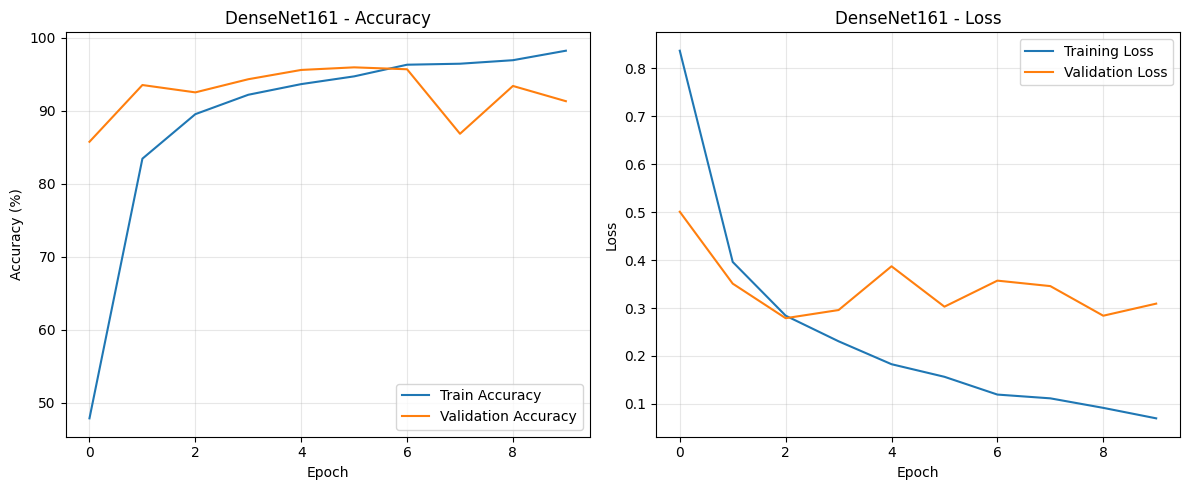


Evaluating DenseNet161 Model...


Getting predictions: 100%|██████████| 118/118 [00:13<00:00,  8.43it/s]



DenseNet161 Classification Report:
              precision    recall  f1-score   support

          no       0.85      0.99      0.91      2500
        vort       0.92      0.93      0.92      2500
      sphere       0.97      0.80      0.88      2500

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.90      7500
weighted avg       0.91      0.91      0.90      7500



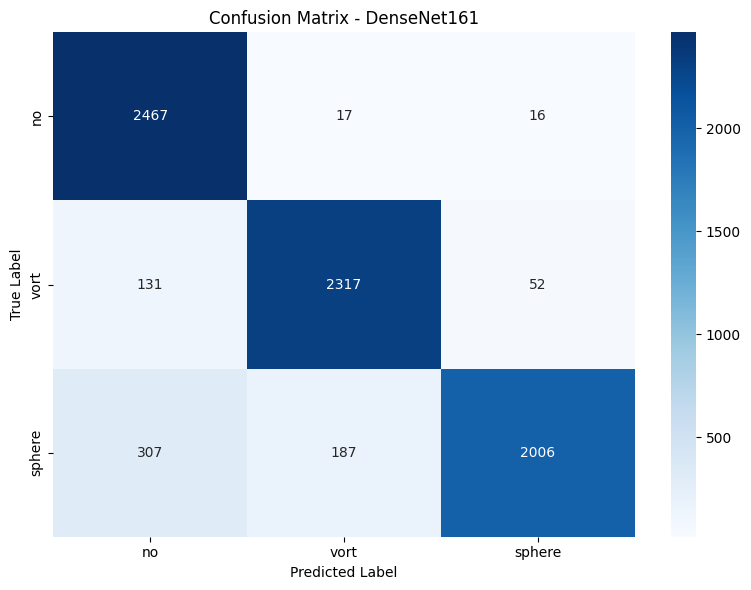

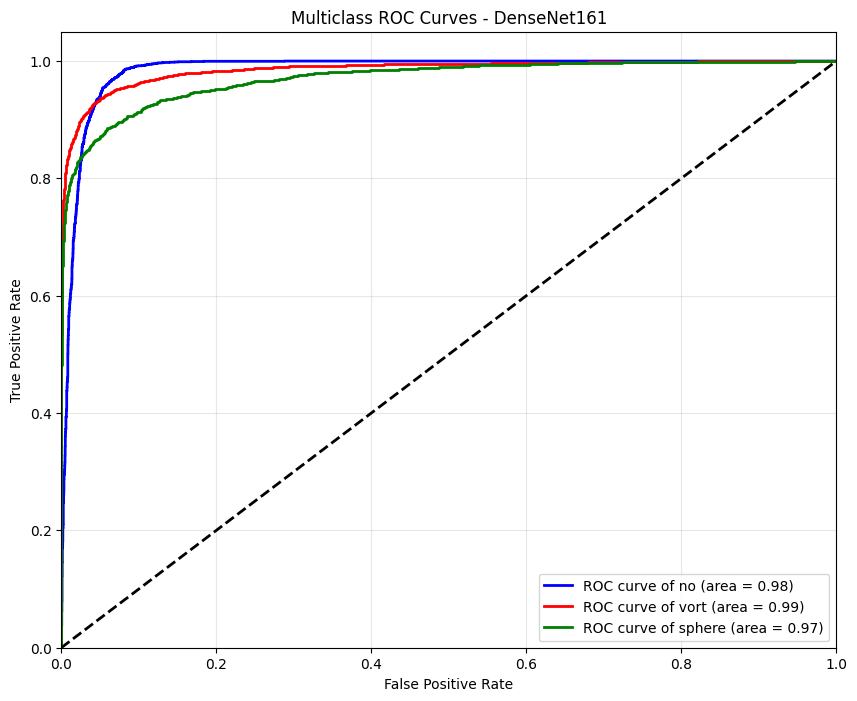

AUC (OVO): 0.9802
AUC (OVR): 0.9802


In [2]:
#%% Cell 1: DenseNet161 – Training and Evaluation

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create criterion if not defined already
criterion = nn.CrossEntropyLoss()

# Initialize DenseNet161 model and move to device
print("Initializing DenseNet161 Model...")
densenet161_model = DenseNet161Model().to(device)

optimizer_161 = torch.optim.Adam(densenet161_model.parameters(), lr=CONFIG.LEARNING_RATE)
history_161 = defaultdict(list)
best_accuracy_161 = 0

for epoch in range(CONFIG.EPOCHS):
    print(f"\nEpoch {epoch + 1}/{CONFIG.EPOCHS} - Training DenseNet161")
    print('-' * 20)
    
    train_accuracy, train_loss = train_one_epoch(
        model=densenet161_model,
        optimizer=optimizer_161,
        data_loader=train_loader
    )
    
    train_accuracy = convert_tensor_list_to_single_mean_value(train_accuracy)
    train_loss = convert_tensor_list_to_single_mean_value(train_loss)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.2f}%')
    
    val_accuracy, val_loss, y_test, y_pred, y_probs = test_model(
        model=densenet161_model,
        data_loader=val_loader
    )
    
    val_accuracy = convert_tensor_list_to_single_mean_value(val_accuracy)
    val_loss = convert_tensor_list_to_single_mean_value(val_loss)
    print(f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.2f}%')
    
    history_161['train_acc'].append(train_accuracy)
    history_161['train_loss'].append(train_loss)
    history_161['val_acc'].append(val_accuracy)
    history_161['val_loss'].append(val_loss)
    
    if val_accuracy > best_accuracy_161:
        torch.save(densenet161_model.state_dict(), '/kaggle/working/densenet161_best.pth')
        best_accuracy_161 = val_accuracy
        print(f"New best DenseNet161 model saved with accuracy: {best_accuracy_161:.2f}%")

# Reinitialize and load saved DenseNet161 model for inference/evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet161_model = DenseNet161Model().to(device)
densenet161_model.load_state_dict(torch.load('/kaggle/working/densenet161_best.pth', map_location=device))
densenet161_model.eval()

print("DenseNet161 model is ready for inference/evaluation.")

# -------------------------------
# Evaluation Code for DenseNet161
# -------------------------------

def generate_acc_loss_plots(history, title):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training history for DenseNet161
generate_acc_loss_plots(history_161, "DenseNet161")

def one_hot_encode_array(array, num_classes):
    return np.squeeze(np.eye(num_classes)[array.reshape(-1)])

def get_model_predictions(model, data_loader):
    model.eval()
    y_test_all = []
    y_pred_all = []
    y_pred_prob_all = []
    
    with torch.no_grad():
        for data in tqdm(data_loader, desc="Getting predictions"):
            images, labels = data
            # Transfer images and labels to GPU (if available)
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            y_test_all.append(labels.cpu())
            
            y_pred = model(images)
            prob = F.softmax(y_pred, dim=1)
            
            _, predicted = torch.max(y_pred.data, 1)
            y_pred_prob_all.append(prob.cpu())
            y_pred_all.append(predicted.cpu())
    
    # Convert lists of tensors to numpy arrays
    y_test_all = np.concatenate([tensor.numpy() for tensor in y_test_all]).ravel()
    y_pred_all = np.concatenate([tensor.numpy() for tensor in y_pred_all]).ravel()
    y_pred_prob_all = np.vstack([tensor.numpy() for tensor in y_pred_prob_all])
    
    return y_test_all, y_pred_all, y_pred_prob_all

def plot_roc_curves(y_test, y_pred_prob, class_names, title):
    # One-hot encode labels for ROC calculation
    y_test_onehot = one_hot_encode_array(y_test, len(class_names))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)
    
    # Calculate ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    
    for i, color, cls in zip(range(n_classes), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'ROC curve of {cls} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curves - {title}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
    
    # Calculate OVO and OVR AUC scores
    auc_ovo = roc_auc_score(y_test_onehot, y_pred_prob, multi_class='ovo')
    auc_ovr = roc_auc_score(y_test_onehot, y_pred_prob, multi_class='ovr')
    
    print(f'AUC (OVO): {auc_ovo:.4f}')
    print(f'AUC (OVR): {auc_ovr:.4f}')

# Get predictions for DenseNet161
print("\nEvaluating DenseNet161 Model...")
y_test_161, y_pred_161, y_pred_prob_161 = get_model_predictions(densenet161_model, val_loader)

# Display classification report
print("\nDenseNet161 Classification Report:")
print(classification_report(y_test_161, y_pred_161, target_names=[idx_to_class[i] for i in range(len(classes))]))

# Plot confusion matrix for DenseNet161
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=[idx_to_class[i] for i in range(len(classes))],
               yticklabels=[idx_to_class[i] for i in range(len(classes))])
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test_161, y_pred_161, "DenseNet161")

# Plot ROC curve for DenseNet161
class_names = [idx_to_class[i] for i in range(len(classes))]
plot_roc_curves(y_test_161, y_pred_prob_161, class_names, "DenseNet161")

# -------------------------------
# End of DenseNet161 Cell
# -------------------------------


Using device: cuda
Initializing DenseNet201 Model...

Epoch 1/10 - Training DenseNet201
--------------------


  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-1-40bd5bd050bb>:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss.append(torch.tensor(loss))
  0%|          | 2/469 [00:00<02:23,  3.24it/s]

Batch 0: Loss: 1.1801, Accuracy: 40.62%


  3%|▎         | 12/469 [00:03<02:03,  3.69it/s]

Batch 10: Loss: 1.1789, Accuracy: 38.35%


  5%|▍         | 22/469 [00:06<02:00,  3.70it/s]

Batch 20: Loss: 1.1643, Accuracy: 36.16%


  7%|▋         | 32/469 [00:09<01:57,  3.70it/s]

Batch 30: Loss: 1.0349, Accuracy: 37.25%


  9%|▉         | 42/469 [00:11<01:55,  3.69it/s]

Batch 40: Loss: 1.1927, Accuracy: 36.97%


 11%|█         | 52/469 [00:14<01:52,  3.69it/s]

Batch 50: Loss: 1.1604, Accuracy: 37.38%


 13%|█▎        | 62/469 [00:17<01:49,  3.70it/s]

Batch 60: Loss: 1.0296, Accuracy: 38.19%


 15%|█▌        | 72/469 [00:20<01:47,  3.70it/s]

Batch 70: Loss: 1.0852, Accuracy: 38.27%


 17%|█▋        | 82/469 [00:22<01:44,  3.70it/s]

Batch 80: Loss: 1.1809, Accuracy: 38.37%


 20%|█▉        | 92/469 [00:25<01:41,  3.70it/s]

Batch 90: Loss: 1.3233, Accuracy: 37.95%


 22%|██▏       | 102/469 [00:28<01:39,  3.70it/s]

Batch 100: Loss: 1.1139, Accuracy: 38.43%


 24%|██▍       | 112/469 [00:31<01:36,  3.70it/s]

Batch 110: Loss: 1.1683, Accuracy: 38.75%


 26%|██▌       | 122/469 [00:34<01:33,  3.70it/s]

Batch 120: Loss: 1.0922, Accuracy: 38.97%


 28%|██▊       | 132/469 [00:36<01:31,  3.70it/s]

Batch 130: Loss: 1.1934, Accuracy: 39.12%


 30%|███       | 142/469 [00:39<01:28,  3.70it/s]

Batch 140: Loss: 1.1642, Accuracy: 39.21%


 32%|███▏      | 152/469 [00:42<01:25,  3.70it/s]

Batch 150: Loss: 1.0415, Accuracy: 39.68%


 35%|███▍      | 162/469 [00:45<01:23,  3.70it/s]

Batch 160: Loss: 1.2047, Accuracy: 39.87%


 37%|███▋      | 172/469 [00:47<01:20,  3.70it/s]

Batch 170: Loss: 0.9958, Accuracy: 40.25%


 39%|███▉      | 182/469 [00:50<01:17,  3.70it/s]

Batch 180: Loss: 0.9844, Accuracy: 40.60%


 41%|████      | 192/469 [00:53<01:14,  3.70it/s]

Batch 190: Loss: 0.9054, Accuracy: 40.94%


 43%|████▎     | 202/469 [00:56<01:12,  3.70it/s]

Batch 200: Loss: 0.9629, Accuracy: 41.33%


 45%|████▌     | 212/469 [00:59<01:09,  3.69it/s]

Batch 210: Loss: 0.9859, Accuracy: 41.81%


 47%|████▋     | 222/469 [01:01<01:07,  3.68it/s]

Batch 220: Loss: 1.0988, Accuracy: 42.27%


 49%|████▉     | 232/469 [01:04<01:04,  3.66it/s]

Batch 230: Loss: 0.8622, Accuracy: 42.66%


 52%|█████▏    | 242/469 [01:07<01:01,  3.70it/s]

Batch 240: Loss: 1.1060, Accuracy: 43.12%


 54%|█████▎    | 252/469 [01:10<00:58,  3.71it/s]

Batch 250: Loss: 0.9249, Accuracy: 43.49%


 56%|█████▌    | 262/469 [01:13<00:55,  3.70it/s]

Batch 260: Loss: 1.0609, Accuracy: 44.01%


 58%|█████▊    | 272/469 [01:15<00:53,  3.70it/s]

Batch 270: Loss: 1.0829, Accuracy: 44.41%


 60%|██████    | 282/469 [01:18<00:50,  3.70it/s]

Batch 280: Loss: 0.8790, Accuracy: 44.73%


 62%|██████▏   | 292/469 [01:21<00:47,  3.70it/s]

Batch 290: Loss: 0.9479, Accuracy: 45.12%


 64%|██████▍   | 302/469 [01:24<00:45,  3.70it/s]

Batch 300: Loss: 0.9310, Accuracy: 45.48%


 67%|██████▋   | 312/469 [01:26<00:42,  3.70it/s]

Batch 310: Loss: 1.0302, Accuracy: 45.79%


 69%|██████▊   | 322/469 [01:29<00:39,  3.69it/s]

Batch 320: Loss: 0.8169, Accuracy: 46.27%


 71%|███████   | 332/469 [01:32<00:37,  3.70it/s]

Batch 330: Loss: 0.8470, Accuracy: 46.68%


 73%|███████▎  | 342/469 [01:35<00:34,  3.70it/s]

Batch 340: Loss: 0.9676, Accuracy: 47.04%


 75%|███████▌  | 352/469 [01:38<00:31,  3.71it/s]

Batch 350: Loss: 0.9184, Accuracy: 47.50%


 77%|███████▋  | 362/469 [01:40<00:28,  3.70it/s]

Batch 360: Loss: 0.6993, Accuracy: 47.94%


 79%|███████▉  | 372/469 [01:43<00:26,  3.70it/s]

Batch 370: Loss: 0.6914, Accuracy: 48.39%


 81%|████████▏ | 382/469 [01:46<00:23,  3.69it/s]

Batch 380: Loss: 0.7081, Accuracy: 48.82%


 84%|████████▎ | 392/469 [01:49<00:20,  3.70it/s]

Batch 390: Loss: 0.7540, Accuracy: 49.34%


 86%|████████▌ | 402/469 [01:52<00:18,  3.69it/s]

Batch 400: Loss: 0.7217, Accuracy: 49.73%


 88%|████████▊ | 412/469 [01:54<00:15,  3.70it/s]

Batch 410: Loss: 0.5823, Accuracy: 50.17%


 90%|████████▉ | 422/469 [01:57<00:12,  3.70it/s]

Batch 420: Loss: 0.8061, Accuracy: 50.67%


 92%|█████████▏| 432/469 [02:00<00:10,  3.69it/s]

Batch 430: Loss: 0.6505, Accuracy: 51.17%


 94%|█████████▍| 442/469 [02:03<00:07,  3.70it/s]

Batch 440: Loss: 0.5688, Accuracy: 51.63%


 96%|█████████▋| 452/469 [02:05<00:04,  3.69it/s]

Batch 450: Loss: 0.7145, Accuracy: 52.08%


 99%|█████████▊| 462/469 [02:08<00:01,  3.69it/s]

Batch 460: Loss: 0.7960, Accuracy: 52.49%


100%|██████████| 469/469 [02:10<00:00,  3.59it/s]


Train loss: 0.9659, Train accuracy: 43.41%


  0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-1-40bd5bd050bb>:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss.append(torch.tensor(loss))
100%|██████████| 118/118 [00:10<00:00, 10.86it/s]


Val loss: 0.7050, Val accuracy: 85.81%
New best DenseNet201 model saved with accuracy: 85.81%

Epoch 2/10 - Training DenseNet201
--------------------


  0%|          | 2/469 [00:00<02:18,  3.38it/s]

Batch 0: Loss: 0.4652, Accuracy: 87.50%


  3%|▎         | 12/469 [00:03<02:03,  3.70it/s]

Batch 10: Loss: 0.5817, Accuracy: 73.44%


  5%|▍         | 22/469 [00:06<02:01,  3.69it/s]

Batch 20: Loss: 0.6187, Accuracy: 75.45%


  7%|▋         | 32/469 [00:08<01:58,  3.70it/s]

Batch 30: Loss: 0.4553, Accuracy: 75.66%


  9%|▉         | 42/469 [00:11<01:55,  3.70it/s]

Batch 40: Loss: 0.6551, Accuracy: 76.03%


 11%|█         | 52/469 [00:14<01:52,  3.70it/s]

Batch 50: Loss: 0.5507, Accuracy: 75.74%


 13%|█▎        | 62/469 [00:17<01:50,  3.70it/s]

Batch 60: Loss: 0.6320, Accuracy: 75.85%


 15%|█▌        | 72/469 [00:20<01:47,  3.70it/s]

Batch 70: Loss: 0.6434, Accuracy: 76.10%


 17%|█▋        | 82/469 [00:22<01:44,  3.70it/s]

Batch 80: Loss: 0.4487, Accuracy: 76.22%


 20%|█▉        | 92/469 [00:25<01:41,  3.70it/s]

Batch 90: Loss: 0.5514, Accuracy: 76.61%


 22%|██▏       | 102/469 [00:28<01:39,  3.70it/s]

Batch 100: Loss: 0.7238, Accuracy: 76.87%


 24%|██▍       | 112/469 [00:31<01:36,  3.70it/s]

Batch 110: Loss: 0.6064, Accuracy: 76.80%


 26%|██▌       | 122/469 [00:34<01:33,  3.70it/s]

Batch 120: Loss: 0.6823, Accuracy: 76.86%


 28%|██▊       | 132/469 [00:36<01:31,  3.70it/s]

Batch 130: Loss: 0.4224, Accuracy: 76.78%


 30%|███       | 142/469 [00:39<01:28,  3.69it/s]

Batch 140: Loss: 0.5303, Accuracy: 76.86%


 32%|███▏      | 152/469 [00:42<01:25,  3.70it/s]

Batch 150: Loss: 0.4607, Accuracy: 77.01%


 35%|███▍      | 162/469 [00:45<01:22,  3.70it/s]

Batch 160: Loss: 0.4286, Accuracy: 77.25%


 37%|███▋      | 172/469 [00:47<01:20,  3.70it/s]

Batch 170: Loss: 0.4002, Accuracy: 77.48%


 39%|███▉      | 182/469 [00:50<01:17,  3.70it/s]

Batch 180: Loss: 0.3291, Accuracy: 77.52%


 41%|████      | 192/469 [00:53<01:14,  3.70it/s]

Batch 190: Loss: 0.5542, Accuracy: 77.66%


 43%|████▎     | 202/469 [00:56<01:12,  3.69it/s]

Batch 200: Loss: 0.4954, Accuracy: 77.79%


 45%|████▌     | 212/469 [00:59<01:09,  3.70it/s]

Batch 210: Loss: 0.4623, Accuracy: 78.04%


 47%|████▋     | 222/469 [01:01<01:06,  3.70it/s]

Batch 220: Loss: 0.5315, Accuracy: 78.06%


 49%|████▉     | 232/469 [01:04<01:04,  3.70it/s]

Batch 230: Loss: 0.4654, Accuracy: 78.10%


 52%|█████▏    | 242/469 [01:07<01:01,  3.70it/s]

Batch 240: Loss: 0.6913, Accuracy: 78.15%


 54%|█████▎    | 252/469 [01:10<00:58,  3.69it/s]

Batch 250: Loss: 0.4732, Accuracy: 78.30%


 56%|█████▌    | 262/469 [01:13<00:55,  3.70it/s]

Batch 260: Loss: 0.3606, Accuracy: 78.44%


 58%|█████▊    | 272/469 [01:15<00:53,  3.70it/s]

Batch 270: Loss: 0.5259, Accuracy: 78.59%


 60%|██████    | 282/469 [01:18<00:50,  3.70it/s]

Batch 280: Loss: 0.4415, Accuracy: 78.64%


 62%|██████▏   | 292/469 [01:21<00:47,  3.69it/s]

Batch 290: Loss: 0.4659, Accuracy: 78.74%


 64%|██████▍   | 302/469 [01:24<00:45,  3.69it/s]

Batch 300: Loss: 0.5445, Accuracy: 78.89%


 67%|██████▋   | 312/469 [01:26<00:42,  3.70it/s]

Batch 310: Loss: 0.6190, Accuracy: 78.96%


 69%|██████▊   | 322/469 [01:29<00:39,  3.70it/s]

Batch 320: Loss: 0.3646, Accuracy: 79.10%


 71%|███████   | 332/469 [01:32<00:37,  3.70it/s]

Batch 330: Loss: 0.7429, Accuracy: 79.16%


 73%|███████▎  | 342/469 [01:35<00:34,  3.70it/s]

Batch 340: Loss: 0.4029, Accuracy: 79.28%


 75%|███████▌  | 352/469 [01:38<00:31,  3.70it/s]

Batch 350: Loss: 0.3402, Accuracy: 79.45%


 77%|███████▋  | 362/469 [01:40<00:28,  3.70it/s]

Batch 360: Loss: 0.4930, Accuracy: 79.50%


 79%|███████▉  | 372/469 [01:43<00:26,  3.70it/s]

Batch 370: Loss: 0.3546, Accuracy: 79.61%


 81%|████████▏ | 382/469 [01:46<00:23,  3.69it/s]

Batch 380: Loss: 0.3413, Accuracy: 79.64%


 84%|████████▎ | 392/469 [01:49<00:20,  3.70it/s]

Batch 390: Loss: 0.4051, Accuracy: 79.69%


 86%|████████▌ | 402/469 [01:52<00:18,  3.69it/s]

Batch 400: Loss: 0.4347, Accuracy: 79.73%


 88%|████████▊ | 412/469 [01:54<00:15,  3.70it/s]

Batch 410: Loss: 0.6241, Accuracy: 79.84%


 90%|████████▉ | 422/469 [01:57<00:12,  3.70it/s]

Batch 420: Loss: 0.3458, Accuracy: 79.91%


 92%|█████████▏| 432/469 [02:00<00:10,  3.70it/s]

Batch 430: Loss: 0.4448, Accuracy: 79.94%


 94%|█████████▍| 442/469 [02:03<00:07,  3.70it/s]

Batch 440: Loss: 0.2362, Accuracy: 80.11%


 96%|█████████▋| 452/469 [02:05<00:04,  3.70it/s]

Batch 450: Loss: 0.4049, Accuracy: 80.23%


 99%|█████████▊| 462/469 [02:08<00:01,  3.69it/s]

Batch 460: Loss: 0.4068, Accuracy: 80.30%


100%|██████████| 469/469 [02:10<00:00,  3.59it/s]


Train loss: 0.4962, Train accuracy: 78.05%


100%|██████████| 118/118 [00:10<00:00, 11.01it/s]


Val loss: 0.4197, Val accuracy: 91.15%
New best DenseNet201 model saved with accuracy: 91.15%

Epoch 3/10 - Training DenseNet201
--------------------


  0%|          | 2/469 [00:00<02:15,  3.45it/s]

Batch 0: Loss: 0.4072, Accuracy: 82.81%


  3%|▎         | 12/469 [00:03<02:03,  3.70it/s]

Batch 10: Loss: 0.4307, Accuracy: 88.21%


  5%|▍         | 22/469 [00:06<02:00,  3.70it/s]

Batch 20: Loss: 0.3757, Accuracy: 87.95%


  7%|▋         | 32/469 [00:08<01:58,  3.70it/s]

Batch 30: Loss: 0.4174, Accuracy: 88.10%


  9%|▉         | 42/469 [00:11<01:55,  3.70it/s]

Batch 40: Loss: 0.4160, Accuracy: 87.50%


 11%|█         | 52/469 [00:14<01:52,  3.70it/s]

Batch 50: Loss: 0.2960, Accuracy: 87.44%


 13%|█▎        | 62/469 [00:17<01:50,  3.70it/s]

Batch 60: Loss: 0.3423, Accuracy: 87.83%


 15%|█▌        | 72/469 [00:20<01:47,  3.70it/s]

Batch 70: Loss: 0.2914, Accuracy: 87.74%


 17%|█▋        | 82/469 [00:22<01:44,  3.70it/s]

Batch 80: Loss: 0.4217, Accuracy: 87.83%


 20%|█▉        | 92/469 [00:25<01:41,  3.70it/s]

Batch 90: Loss: 0.1885, Accuracy: 87.91%


 22%|██▏       | 102/469 [00:28<01:39,  3.70it/s]

Batch 100: Loss: 0.2364, Accuracy: 87.70%


 24%|██▍       | 112/469 [00:31<01:36,  3.70it/s]

Batch 110: Loss: 0.3021, Accuracy: 87.98%


 26%|██▌       | 122/469 [00:34<01:34,  3.69it/s]

Batch 120: Loss: 0.3352, Accuracy: 88.04%


 28%|██▊       | 132/469 [00:36<01:31,  3.69it/s]

Batch 130: Loss: 0.3069, Accuracy: 88.11%


 30%|███       | 142/469 [00:39<01:28,  3.69it/s]

Batch 140: Loss: 0.2245, Accuracy: 88.12%


 32%|███▏      | 152/469 [00:42<01:25,  3.69it/s]

Batch 150: Loss: 0.3819, Accuracy: 87.97%


 35%|███▍      | 162/469 [00:45<01:23,  3.69it/s]

Batch 160: Loss: 0.4407, Accuracy: 87.84%


 37%|███▋      | 172/469 [00:47<01:20,  3.69it/s]

Batch 170: Loss: 0.3216, Accuracy: 87.83%


 39%|███▉      | 182/469 [00:50<01:17,  3.70it/s]

Batch 180: Loss: 0.3612, Accuracy: 87.69%


 41%|████      | 192/469 [00:53<01:14,  3.70it/s]

Batch 190: Loss: 0.4485, Accuracy: 87.61%


 43%|████▎     | 202/469 [00:56<01:12,  3.70it/s]

Batch 200: Loss: 0.4308, Accuracy: 87.70%


 45%|████▌     | 212/469 [00:59<01:09,  3.70it/s]

Batch 210: Loss: 0.2897, Accuracy: 87.71%


 47%|████▋     | 222/469 [01:01<01:06,  3.69it/s]

Batch 220: Loss: 0.2874, Accuracy: 87.75%


 49%|████▉     | 232/469 [01:04<01:04,  3.69it/s]

Batch 230: Loss: 0.2204, Accuracy: 87.74%


 52%|█████▏    | 242/469 [01:07<01:01,  3.70it/s]

Batch 240: Loss: 0.4727, Accuracy: 87.60%


 54%|█████▎    | 252/469 [01:10<00:58,  3.70it/s]

Batch 250: Loss: 0.4409, Accuracy: 87.53%


 56%|█████▌    | 262/469 [01:13<00:56,  3.69it/s]

Batch 260: Loss: 0.5998, Accuracy: 87.44%


 58%|█████▊    | 272/469 [01:15<00:53,  3.69it/s]

Batch 270: Loss: 0.4315, Accuracy: 87.42%


 60%|██████    | 282/469 [01:18<00:50,  3.70it/s]

Batch 280: Loss: 0.5777, Accuracy: 87.47%


 62%|██████▏   | 292/469 [01:21<00:47,  3.69it/s]

Batch 290: Loss: 0.3672, Accuracy: 87.51%


 64%|██████▍   | 302/469 [01:24<00:45,  3.69it/s]

Batch 300: Loss: 0.5293, Accuracy: 87.47%


 67%|██████▋   | 312/469 [01:27<00:42,  3.69it/s]

Batch 310: Loss: 0.3992, Accuracy: 87.45%


 69%|██████▊   | 322/469 [01:29<00:39,  3.69it/s]

Batch 320: Loss: 0.4679, Accuracy: 87.44%


 71%|███████   | 332/469 [01:32<00:37,  3.69it/s]

Batch 330: Loss: 0.3693, Accuracy: 87.53%


 73%|███████▎  | 342/469 [01:35<00:34,  3.70it/s]

Batch 340: Loss: 0.3908, Accuracy: 87.55%


 75%|███████▌  | 352/469 [01:38<00:31,  3.71it/s]

Batch 350: Loss: 0.2181, Accuracy: 87.62%


 77%|███████▋  | 362/469 [01:40<00:28,  3.69it/s]

Batch 360: Loss: 0.3232, Accuracy: 87.67%


 79%|███████▉  | 372/469 [01:43<00:26,  3.69it/s]

Batch 370: Loss: 0.4105, Accuracy: 87.65%


 81%|████████▏ | 382/469 [01:46<00:23,  3.69it/s]

Batch 380: Loss: 0.2569, Accuracy: 87.67%


 84%|████████▎ | 392/469 [01:49<00:20,  3.69it/s]

Batch 390: Loss: 0.2664, Accuracy: 87.70%


 86%|████████▌ | 402/469 [01:52<00:18,  3.69it/s]

Batch 400: Loss: 0.3051, Accuracy: 87.72%


 88%|████████▊ | 412/469 [01:54<00:15,  3.69it/s]

Batch 410: Loss: 0.3592, Accuracy: 87.79%


 90%|████████▉ | 422/469 [01:57<00:12,  3.67it/s]

Batch 420: Loss: 0.4280, Accuracy: 87.76%


 92%|█████████▏| 432/469 [02:00<00:10,  3.70it/s]

Batch 430: Loss: 0.3390, Accuracy: 87.79%


 94%|█████████▍| 442/469 [02:03<00:07,  3.63it/s]

Batch 440: Loss: 0.3527, Accuracy: 87.82%


 96%|█████████▋| 452/469 [02:06<00:04,  3.69it/s]

Batch 450: Loss: 0.3267, Accuracy: 87.82%


 99%|█████████▊| 462/469 [02:09<00:01,  3.67it/s]

Batch 460: Loss: 0.4014, Accuracy: 87.82%


100%|██████████| 469/469 [02:11<00:00,  3.58it/s]


Train loss: 0.3308, Train accuracy: 87.70%


100%|██████████| 118/118 [00:10<00:00, 11.01it/s]


Val loss: 0.3405, Val accuracy: 90.40%

Epoch 4/10 - Training DenseNet201
--------------------


  0%|          | 2/469 [00:00<02:16,  3.41it/s]

Batch 0: Loss: 0.2328, Accuracy: 90.62%


  3%|▎         | 12/469 [00:03<02:03,  3.69it/s]

Batch 10: Loss: 0.2724, Accuracy: 91.19%


  5%|▍         | 22/469 [00:06<02:00,  3.69it/s]

Batch 20: Loss: 0.3131, Accuracy: 91.96%


  7%|▋         | 32/469 [00:08<01:58,  3.70it/s]

Batch 30: Loss: 0.2900, Accuracy: 91.73%


  9%|▉         | 42/469 [00:11<01:55,  3.70it/s]

Batch 40: Loss: 0.1915, Accuracy: 91.31%


 11%|█         | 52/469 [00:14<01:52,  3.69it/s]

Batch 50: Loss: 0.2079, Accuracy: 91.39%


 13%|█▎        | 62/469 [00:17<01:50,  3.69it/s]

Batch 60: Loss: 0.1142, Accuracy: 91.55%


 15%|█▌        | 72/469 [00:20<01:47,  3.69it/s]

Batch 70: Loss: 0.1588, Accuracy: 91.77%


 17%|█▋        | 82/469 [00:22<01:44,  3.70it/s]

Batch 80: Loss: 0.2487, Accuracy: 91.49%


 20%|█▉        | 92/469 [00:25<01:42,  3.68it/s]

Batch 90: Loss: 0.1354, Accuracy: 91.67%


 22%|██▏       | 102/469 [00:28<01:39,  3.70it/s]

Batch 100: Loss: 0.2345, Accuracy: 91.55%


 24%|██▍       | 112/469 [00:31<01:36,  3.69it/s]

Batch 110: Loss: 0.2676, Accuracy: 91.43%


 26%|██▌       | 122/469 [00:34<01:33,  3.69it/s]

Batch 120: Loss: 0.3628, Accuracy: 91.40%


 28%|██▊       | 132/469 [00:36<01:31,  3.70it/s]

Batch 130: Loss: 0.2290, Accuracy: 91.38%


 30%|███       | 142/469 [00:39<01:28,  3.69it/s]

Batch 140: Loss: 0.2047, Accuracy: 91.56%


 32%|███▏      | 152/469 [00:42<01:25,  3.69it/s]

Batch 150: Loss: 0.2432, Accuracy: 91.53%


 35%|███▍      | 162/469 [00:45<01:23,  3.69it/s]

Batch 160: Loss: 0.2331, Accuracy: 91.46%


 37%|███▋      | 172/469 [00:48<01:20,  3.69it/s]

Batch 170: Loss: 0.2026, Accuracy: 91.50%


 39%|███▉      | 182/469 [00:50<01:18,  3.66it/s]

Batch 180: Loss: 0.1933, Accuracy: 91.48%


 41%|████      | 192/469 [00:53<01:14,  3.69it/s]

Batch 190: Loss: 0.2382, Accuracy: 91.49%


 43%|████▎     | 202/469 [00:56<01:12,  3.70it/s]

Batch 200: Loss: 0.1909, Accuracy: 91.47%


 45%|████▌     | 212/469 [00:59<01:09,  3.69it/s]

Batch 210: Loss: 0.1321, Accuracy: 91.56%


 47%|████▋     | 222/469 [01:01<01:06,  3.69it/s]

Batch 220: Loss: 0.3183, Accuracy: 91.49%


 49%|████▉     | 232/469 [01:04<01:04,  3.69it/s]

Batch 230: Loss: 0.1768, Accuracy: 91.52%


 52%|█████▏    | 242/469 [01:07<01:01,  3.69it/s]

Batch 240: Loss: 0.1825, Accuracy: 91.48%


 54%|█████▎    | 252/469 [01:10<00:58,  3.69it/s]

Batch 250: Loss: 0.3276, Accuracy: 91.42%


 56%|█████▌    | 262/469 [01:13<00:56,  3.69it/s]

Batch 260: Loss: 0.2690, Accuracy: 91.39%


 58%|█████▊    | 272/469 [01:15<00:53,  3.69it/s]

Batch 270: Loss: 0.2608, Accuracy: 91.41%


 60%|██████    | 282/469 [01:18<00:50,  3.70it/s]

Batch 280: Loss: 0.2006, Accuracy: 91.35%


 62%|██████▏   | 292/469 [01:21<00:47,  3.69it/s]

Batch 290: Loss: 0.3012, Accuracy: 91.33%


 64%|██████▍   | 302/469 [01:24<00:45,  3.70it/s]

Batch 300: Loss: 0.3072, Accuracy: 91.31%


 67%|██████▋   | 312/469 [01:27<00:42,  3.69it/s]

Batch 310: Loss: 0.3921, Accuracy: 91.25%


 69%|██████▊   | 322/469 [01:29<00:39,  3.69it/s]

Batch 320: Loss: 0.3569, Accuracy: 91.27%


 71%|███████   | 332/469 [01:32<00:37,  3.69it/s]

Batch 330: Loss: 0.2471, Accuracy: 91.25%


 73%|███████▎  | 342/469 [01:35<00:34,  3.70it/s]

Batch 340: Loss: 0.3597, Accuracy: 91.17%


 75%|███████▌  | 352/469 [01:38<00:31,  3.69it/s]

Batch 350: Loss: 0.3545, Accuracy: 91.15%


 77%|███████▋  | 362/469 [01:40<00:29,  3.69it/s]

Batch 360: Loss: 0.1765, Accuracy: 91.14%


 79%|███████▉  | 372/469 [01:43<00:26,  3.69it/s]

Batch 370: Loss: 0.2078, Accuracy: 91.13%


 81%|████████▏ | 382/469 [01:46<00:23,  3.69it/s]

Batch 380: Loss: 0.2124, Accuracy: 91.15%


 84%|████████▎ | 392/469 [01:49<00:20,  3.69it/s]

Batch 390: Loss: 0.2236, Accuracy: 91.16%


 86%|████████▌ | 402/469 [01:52<00:18,  3.69it/s]

Batch 400: Loss: 0.3223, Accuracy: 91.20%


 88%|████████▊ | 412/469 [01:54<00:15,  3.69it/s]

Batch 410: Loss: 0.3994, Accuracy: 91.21%


 90%|████████▉ | 422/469 [01:57<00:12,  3.70it/s]

Batch 420: Loss: 0.1899, Accuracy: 91.18%


 92%|█████████▏| 432/469 [02:00<00:10,  3.69it/s]

Batch 430: Loss: 0.2337, Accuracy: 91.19%


 94%|█████████▍| 442/469 [02:03<00:07,  3.69it/s]

Batch 440: Loss: 0.2244, Accuracy: 91.19%


 96%|█████████▋| 452/469 [02:06<00:04,  3.69it/s]

Batch 450: Loss: 0.1789, Accuracy: 91.20%


 99%|█████████▊| 462/469 [02:08<00:01,  3.69it/s]

Batch 460: Loss: 0.3183, Accuracy: 91.19%


100%|██████████| 469/469 [02:10<00:00,  3.58it/s]


Train loss: 0.2480, Train accuracy: 91.38%


100%|██████████| 118/118 [00:10<00:00, 11.00it/s]


Val loss: 0.3561, Val accuracy: 95.21%
New best DenseNet201 model saved with accuracy: 95.21%

Epoch 5/10 - Training DenseNet201
--------------------


  0%|          | 2/469 [00:00<02:18,  3.36it/s]

Batch 0: Loss: 0.2117, Accuracy: 95.31%


  2%|▏         | 11/469 [00:03<02:20,  3.25it/s]

Batch 10: Loss: 0.1913, Accuracy: 92.61%


  5%|▍         | 22/469 [00:06<02:00,  3.70it/s]

Batch 20: Loss: 0.1855, Accuracy: 93.30%


  7%|▋         | 32/469 [00:09<01:58,  3.70it/s]

Batch 30: Loss: 0.1514, Accuracy: 93.75%


  9%|▉         | 42/469 [00:11<01:55,  3.70it/s]

Batch 40: Loss: 0.1172, Accuracy: 94.40%


 11%|█         | 52/469 [00:14<01:52,  3.70it/s]

Batch 50: Loss: 0.1601, Accuracy: 94.55%


 13%|█▎        | 62/469 [00:17<01:50,  3.70it/s]

Batch 60: Loss: 0.1838, Accuracy: 94.34%


 15%|█▌        | 72/469 [00:20<01:47,  3.70it/s]

Batch 70: Loss: 0.0975, Accuracy: 94.39%


 17%|█▋        | 82/469 [00:22<01:44,  3.70it/s]

Batch 80: Loss: 0.1695, Accuracy: 94.19%


 20%|█▉        | 92/469 [00:25<01:41,  3.70it/s]

Batch 90: Loss: 0.2347, Accuracy: 94.20%


 22%|██▏       | 102/469 [00:28<01:39,  3.70it/s]

Batch 100: Loss: 0.3849, Accuracy: 94.06%


 24%|██▍       | 112/469 [00:31<01:36,  3.70it/s]

Batch 110: Loss: 0.2703, Accuracy: 94.03%


 26%|██▌       | 122/469 [00:34<01:33,  3.70it/s]

Batch 120: Loss: 0.1750, Accuracy: 93.93%


 28%|██▊       | 132/469 [00:36<01:30,  3.70it/s]

Batch 130: Loss: 0.1739, Accuracy: 93.82%


 30%|███       | 142/469 [00:39<01:28,  3.70it/s]

Batch 140: Loss: 0.0999, Accuracy: 93.73%


 32%|███▏      | 152/469 [00:42<01:25,  3.70it/s]

Batch 150: Loss: 0.2531, Accuracy: 93.58%


 35%|███▍      | 162/469 [00:45<01:22,  3.70it/s]

Batch 160: Loss: 0.1330, Accuracy: 93.53%


 37%|███▋      | 172/469 [00:47<01:20,  3.70it/s]

Batch 170: Loss: 0.2442, Accuracy: 93.52%


 39%|███▉      | 182/469 [00:50<01:17,  3.70it/s]

Batch 180: Loss: 0.3069, Accuracy: 93.44%


 41%|████      | 192/469 [00:53<01:14,  3.70it/s]

Batch 190: Loss: 0.1558, Accuracy: 93.46%


 43%|████▎     | 202/469 [00:56<01:12,  3.70it/s]

Batch 200: Loss: 0.2519, Accuracy: 93.43%


 45%|████▌     | 212/469 [00:59<01:09,  3.69it/s]

Batch 210: Loss: 0.2172, Accuracy: 93.45%


 47%|████▋     | 222/469 [01:01<01:06,  3.70it/s]

Batch 220: Loss: 0.1932, Accuracy: 93.39%


 49%|████▉     | 232/469 [01:04<01:04,  3.70it/s]

Batch 230: Loss: 0.1658, Accuracy: 93.32%


 52%|█████▏    | 242/469 [01:07<01:01,  3.68it/s]

Batch 240: Loss: 0.1185, Accuracy: 93.36%


 54%|█████▎    | 252/469 [01:10<00:58,  3.70it/s]

Batch 250: Loss: 0.1165, Accuracy: 93.34%


 56%|█████▌    | 262/469 [01:13<00:55,  3.70it/s]

Batch 260: Loss: 0.1967, Accuracy: 93.31%


 58%|█████▊    | 272/469 [01:15<00:53,  3.70it/s]

Batch 270: Loss: 0.2052, Accuracy: 93.30%


 60%|██████    | 282/469 [01:18<00:50,  3.70it/s]

Batch 280: Loss: 0.2479, Accuracy: 93.29%


 62%|██████▏   | 292/469 [01:21<00:47,  3.70it/s]

Batch 290: Loss: 0.4051, Accuracy: 93.28%


 64%|██████▍   | 302/469 [01:24<00:45,  3.70it/s]

Batch 300: Loss: 0.1204, Accuracy: 93.30%


 67%|██████▋   | 312/469 [01:26<00:42,  3.70it/s]

Batch 310: Loss: 0.4043, Accuracy: 93.27%


 69%|██████▊   | 322/469 [01:29<00:39,  3.70it/s]

Batch 320: Loss: 0.0615, Accuracy: 93.20%


 71%|███████   | 332/469 [01:32<00:36,  3.70it/s]

Batch 330: Loss: 0.1890, Accuracy: 93.14%


 73%|███████▎  | 342/469 [01:35<00:34,  3.71it/s]

Batch 340: Loss: 0.3916, Accuracy: 93.15%


 75%|███████▌  | 352/469 [01:38<00:31,  3.70it/s]

Batch 350: Loss: 0.2073, Accuracy: 93.17%


 77%|███████▋  | 362/469 [01:40<00:28,  3.70it/s]

Batch 360: Loss: 0.1265, Accuracy: 93.11%


 79%|███████▉  | 372/469 [01:43<00:26,  3.70it/s]

Batch 370: Loss: 0.1532, Accuracy: 93.11%


 81%|████████▏ | 382/469 [01:46<00:23,  3.70it/s]

Batch 380: Loss: 0.1611, Accuracy: 93.06%


 84%|████████▎ | 392/469 [01:49<00:20,  3.70it/s]

Batch 390: Loss: 0.3346, Accuracy: 93.05%


 86%|████████▌ | 402/469 [01:52<00:18,  3.70it/s]

Batch 400: Loss: 0.1529, Accuracy: 93.07%


 88%|████████▊ | 412/469 [01:54<00:15,  3.70it/s]

Batch 410: Loss: 0.1344, Accuracy: 93.06%


 90%|████████▉ | 422/469 [01:57<00:12,  3.70it/s]

Batch 420: Loss: 0.2347, Accuracy: 93.07%


 92%|█████████▏| 432/469 [02:00<00:09,  3.70it/s]

Batch 430: Loss: 0.2767, Accuracy: 93.00%


 94%|█████████▍| 442/469 [02:03<00:07,  3.70it/s]

Batch 440: Loss: 0.2963, Accuracy: 92.94%


 96%|█████████▋| 452/469 [02:05<00:04,  3.71it/s]

Batch 450: Loss: 0.3198, Accuracy: 92.91%


 99%|█████████▊| 462/469 [02:08<00:01,  3.70it/s]

Batch 460: Loss: 0.1930, Accuracy: 92.87%


100%|██████████| 469/469 [02:10<00:00,  3.59it/s]


Train loss: 0.1992, Train accuracy: 93.47%


100%|██████████| 118/118 [00:10<00:00, 10.97it/s]


Val loss: 0.3160, Val accuracy: 91.26%

Epoch 6/10 - Training DenseNet201
--------------------


  0%|          | 2/469 [00:00<02:20,  3.31it/s]

Batch 0: Loss: 0.0807, Accuracy: 96.88%


  3%|▎         | 12/469 [00:03<02:03,  3.70it/s]

Batch 10: Loss: 0.2234, Accuracy: 94.32%


  5%|▍         | 22/469 [00:06<02:00,  3.70it/s]

Batch 20: Loss: 0.1227, Accuracy: 95.01%


  7%|▋         | 32/469 [00:09<01:58,  3.70it/s]

Batch 30: Loss: 0.2272, Accuracy: 95.46%


  9%|▉         | 42/469 [00:11<01:55,  3.70it/s]

Batch 40: Loss: 0.1225, Accuracy: 95.39%


 11%|█         | 52/469 [00:14<01:52,  3.71it/s]

Batch 50: Loss: 0.2229, Accuracy: 95.25%


 13%|█▎        | 62/469 [00:17<01:49,  3.70it/s]

Batch 60: Loss: 0.2213, Accuracy: 95.18%


 15%|█▌        | 72/469 [00:20<01:47,  3.70it/s]

Batch 70: Loss: 0.1088, Accuracy: 95.16%


 17%|█▋        | 82/469 [00:22<01:44,  3.70it/s]

Batch 80: Loss: 0.1653, Accuracy: 95.37%


 20%|█▉        | 92/469 [00:25<01:42,  3.70it/s]

Batch 90: Loss: 0.0892, Accuracy: 95.21%


 22%|██▏       | 102/469 [00:28<01:39,  3.70it/s]

Batch 100: Loss: 0.1550, Accuracy: 94.88%


 24%|██▍       | 112/469 [00:31<01:36,  3.71it/s]

Batch 110: Loss: 0.1942, Accuracy: 94.74%


 26%|██▌       | 122/469 [00:34<01:33,  3.70it/s]

Batch 120: Loss: 0.0771, Accuracy: 94.71%


 28%|██▊       | 132/469 [00:36<01:31,  3.70it/s]

Batch 130: Loss: 0.1770, Accuracy: 94.78%


 30%|███       | 142/469 [00:39<01:28,  3.70it/s]

Batch 140: Loss: 0.1649, Accuracy: 94.77%


 32%|███▏      | 152/469 [00:42<01:25,  3.70it/s]

Batch 150: Loss: 0.1203, Accuracy: 94.87%


 35%|███▍      | 162/469 [00:45<01:22,  3.70it/s]

Batch 160: Loss: 0.0763, Accuracy: 94.86%


 37%|███▋      | 172/469 [00:47<01:20,  3.70it/s]

Batch 170: Loss: 0.2616, Accuracy: 94.74%


 39%|███▉      | 182/469 [00:50<01:17,  3.70it/s]

Batch 180: Loss: 0.2982, Accuracy: 94.67%


 41%|████      | 192/469 [00:53<01:14,  3.70it/s]

Batch 190: Loss: 0.1150, Accuracy: 94.65%


 43%|████▎     | 202/469 [00:56<01:12,  3.70it/s]

Batch 200: Loss: 0.2310, Accuracy: 94.62%


 45%|████▌     | 212/469 [00:59<01:09,  3.70it/s]

Batch 210: Loss: 0.1806, Accuracy: 94.61%


 47%|████▋     | 222/469 [01:01<01:07,  3.68it/s]

Batch 220: Loss: 0.2686, Accuracy: 94.56%


 49%|████▉     | 232/469 [01:04<01:04,  3.70it/s]

Batch 230: Loss: 0.3649, Accuracy: 94.51%


 52%|█████▏    | 242/469 [01:07<01:01,  3.70it/s]

Batch 240: Loss: 0.1178, Accuracy: 94.45%


 54%|█████▎    | 252/469 [01:10<00:58,  3.70it/s]

Batch 250: Loss: 0.2178, Accuracy: 94.45%


 56%|█████▌    | 262/469 [01:13<00:55,  3.71it/s]

Batch 260: Loss: 0.1451, Accuracy: 94.46%


 58%|█████▊    | 272/469 [01:15<00:53,  3.70it/s]

Batch 270: Loss: 0.1894, Accuracy: 94.46%


 60%|██████    | 282/469 [01:18<00:50,  3.70it/s]

Batch 280: Loss: 0.1209, Accuracy: 94.43%


 62%|██████▏   | 292/469 [01:21<00:47,  3.70it/s]

Batch 290: Loss: 0.3099, Accuracy: 94.41%


 64%|██████▍   | 302/469 [01:24<00:45,  3.70it/s]

Batch 300: Loss: 0.1397, Accuracy: 94.31%


 67%|██████▋   | 312/469 [01:26<00:42,  3.70it/s]

Batch 310: Loss: 0.2568, Accuracy: 94.30%


 69%|██████▊   | 322/469 [01:29<00:39,  3.70it/s]

Batch 320: Loss: 0.1561, Accuracy: 94.26%


 71%|███████   | 332/469 [01:32<00:36,  3.70it/s]

Batch 330: Loss: 0.1237, Accuracy: 94.23%


 73%|███████▎  | 342/469 [01:35<00:34,  3.70it/s]

Batch 340: Loss: 0.1475, Accuracy: 94.24%


 75%|███████▌  | 352/469 [01:38<00:31,  3.70it/s]

Batch 350: Loss: 0.1514, Accuracy: 94.24%


 77%|███████▋  | 362/469 [01:40<00:28,  3.70it/s]

Batch 360: Loss: 0.2163, Accuracy: 94.24%


 79%|███████▉  | 372/469 [01:43<00:26,  3.70it/s]

Batch 370: Loss: 0.1535, Accuracy: 94.22%


 81%|████████▏ | 382/469 [01:46<00:23,  3.70it/s]

Batch 380: Loss: 0.1219, Accuracy: 94.18%


 84%|████████▎ | 392/469 [01:49<00:20,  3.70it/s]

Batch 390: Loss: 0.1256, Accuracy: 94.17%


 86%|████████▌ | 402/469 [01:52<00:18,  3.70it/s]

Batch 400: Loss: 0.0850, Accuracy: 94.15%


 88%|████████▊ | 412/469 [01:54<00:15,  3.70it/s]

Batch 410: Loss: 0.0359, Accuracy: 94.19%


 90%|████████▉ | 422/469 [01:57<00:12,  3.70it/s]

Batch 420: Loss: 0.1224, Accuracy: 94.18%


 92%|█████████▏| 432/469 [02:00<00:09,  3.70it/s]

Batch 430: Loss: 0.0719, Accuracy: 94.21%


 94%|█████████▍| 442/469 [02:03<00:07,  3.70it/s]

Batch 440: Loss: 0.1568, Accuracy: 94.18%


 96%|█████████▋| 452/469 [02:05<00:04,  3.70it/s]

Batch 450: Loss: 0.1248, Accuracy: 94.15%


 99%|█████████▊| 462/469 [02:08<00:01,  3.70it/s]

Batch 460: Loss: 0.3059, Accuracy: 94.14%


100%|██████████| 469/469 [02:10<00:00,  3.59it/s]


Train loss: 0.1671, Train accuracy: 94.59%


100%|██████████| 118/118 [00:10<00:00, 11.02it/s]


Val loss: 0.3560, Val accuracy: 84.36%

Epoch 7/10 - Training DenseNet201
--------------------


  0%|          | 2/469 [00:00<02:15,  3.45it/s]

Batch 0: Loss: 0.3173, Accuracy: 89.06%


  3%|▎         | 12/469 [00:03<02:03,  3.70it/s]

Batch 10: Loss: 0.1577, Accuracy: 95.74%


  5%|▍         | 22/469 [00:06<02:00,  3.70it/s]

Batch 20: Loss: 0.1419, Accuracy: 95.83%


  7%|▋         | 32/469 [00:08<01:58,  3.70it/s]

Batch 30: Loss: 0.0566, Accuracy: 96.17%


  9%|▉         | 42/469 [00:11<01:55,  3.70it/s]

Batch 40: Loss: 0.0463, Accuracy: 96.15%


 11%|█         | 52/469 [00:14<01:52,  3.70it/s]

Batch 50: Loss: 0.1373, Accuracy: 96.02%


 13%|█▎        | 62/469 [00:17<01:49,  3.71it/s]

Batch 60: Loss: 0.1435, Accuracy: 96.03%


 15%|█▌        | 72/469 [00:20<01:47,  3.71it/s]

Batch 70: Loss: 0.0837, Accuracy: 96.02%


 17%|█▋        | 82/469 [00:22<01:44,  3.70it/s]

Batch 80: Loss: 0.0912, Accuracy: 95.89%


 20%|█▉        | 92/469 [00:25<01:41,  3.70it/s]

Batch 90: Loss: 0.3205, Accuracy: 95.72%


 22%|██▏       | 102/469 [00:28<01:39,  3.70it/s]

Batch 100: Loss: 0.2162, Accuracy: 95.61%


 24%|██▍       | 112/469 [00:31<01:36,  3.70it/s]

Batch 110: Loss: 0.0549, Accuracy: 95.58%


 26%|██▌       | 122/469 [00:34<01:33,  3.70it/s]

Batch 120: Loss: 0.1102, Accuracy: 95.48%


 28%|██▊       | 132/469 [00:36<01:31,  3.70it/s]

Batch 130: Loss: 0.1095, Accuracy: 95.40%


 30%|███       | 142/469 [00:39<01:28,  3.70it/s]

Batch 140: Loss: 0.1166, Accuracy: 95.50%


 32%|███▏      | 152/469 [00:42<01:25,  3.70it/s]

Batch 150: Loss: 0.1410, Accuracy: 95.48%


 35%|███▍      | 162/469 [00:45<01:23,  3.70it/s]

Batch 160: Loss: 0.4024, Accuracy: 95.38%


 37%|███▋      | 172/469 [00:47<01:20,  3.70it/s]

Batch 170: Loss: 0.1294, Accuracy: 95.39%


 39%|███▉      | 182/469 [00:50<01:17,  3.70it/s]

Batch 180: Loss: 0.1293, Accuracy: 95.40%


 41%|████      | 192/469 [00:53<01:14,  3.70it/s]

Batch 190: Loss: 0.1396, Accuracy: 95.45%


 43%|████▎     | 202/469 [00:56<01:12,  3.71it/s]

Batch 200: Loss: 0.2033, Accuracy: 95.48%


 45%|████▌     | 212/469 [00:59<01:09,  3.70it/s]

Batch 210: Loss: 0.1044, Accuracy: 95.37%


 47%|████▋     | 222/469 [01:01<01:06,  3.70it/s]

Batch 220: Loss: 0.0639, Accuracy: 95.34%


 49%|████▉     | 232/469 [01:04<01:04,  3.70it/s]

Batch 230: Loss: 0.1278, Accuracy: 95.32%


 52%|█████▏    | 242/469 [01:07<01:01,  3.68it/s]

Batch 240: Loss: 0.1379, Accuracy: 95.36%


 54%|█████▎    | 252/469 [01:10<00:58,  3.70it/s]

Batch 250: Loss: 0.3335, Accuracy: 95.31%


 56%|█████▌    | 262/469 [01:12<00:56,  3.69it/s]

Batch 260: Loss: 0.1124, Accuracy: 95.29%


 58%|█████▊    | 272/469 [01:15<00:53,  3.70it/s]

Batch 270: Loss: 0.1102, Accuracy: 95.32%


 60%|██████    | 282/469 [01:18<00:50,  3.71it/s]

Batch 280: Loss: 0.0882, Accuracy: 95.28%


 62%|██████▏   | 292/469 [01:21<00:47,  3.71it/s]

Batch 290: Loss: 0.2089, Accuracy: 95.26%


 64%|██████▍   | 302/469 [01:24<00:45,  3.70it/s]

Batch 300: Loss: 0.2465, Accuracy: 95.29%


 67%|██████▋   | 312/469 [01:26<00:42,  3.70it/s]

Batch 310: Loss: 0.0788, Accuracy: 95.30%


 69%|██████▊   | 322/469 [01:29<00:39,  3.70it/s]

Batch 320: Loss: 0.0917, Accuracy: 95.28%


 71%|███████   | 332/469 [01:32<00:37,  3.70it/s]

Batch 330: Loss: 0.2072, Accuracy: 95.26%


 73%|███████▎  | 342/469 [01:35<00:34,  3.70it/s]

Batch 340: Loss: 0.3122, Accuracy: 95.23%


 75%|███████▌  | 352/469 [01:38<00:31,  3.70it/s]

Batch 350: Loss: 0.1752, Accuracy: 95.22%


 77%|███████▋  | 362/469 [01:40<00:29,  3.69it/s]

Batch 360: Loss: 0.1038, Accuracy: 95.23%


 79%|███████▉  | 372/469 [01:43<00:26,  3.70it/s]

Batch 370: Loss: 0.0991, Accuracy: 95.25%


 81%|████████▏ | 382/469 [01:46<00:23,  3.69it/s]

Batch 380: Loss: 0.2138, Accuracy: 95.23%


 84%|████████▎ | 392/469 [01:49<00:20,  3.70it/s]

Batch 390: Loss: 0.3010, Accuracy: 95.21%


 86%|████████▌ | 402/469 [01:51<00:18,  3.70it/s]

Batch 400: Loss: 0.1852, Accuracy: 95.25%


 88%|████████▊ | 412/469 [01:54<00:15,  3.70it/s]

Batch 410: Loss: 0.1143, Accuracy: 95.24%


 90%|████████▉ | 422/469 [01:57<00:12,  3.69it/s]

Batch 420: Loss: 0.1858, Accuracy: 95.25%


 92%|█████████▏| 432/469 [02:00<00:10,  3.70it/s]

Batch 430: Loss: 0.1332, Accuracy: 95.28%


 94%|█████████▍| 442/469 [02:03<00:07,  3.70it/s]

Batch 440: Loss: 0.1859, Accuracy: 95.27%


 96%|█████████▋| 452/469 [02:05<00:04,  3.70it/s]

Batch 450: Loss: 0.1459, Accuracy: 95.31%


 99%|█████████▊| 462/469 [02:08<00:01,  3.70it/s]

Batch 460: Loss: 0.2044, Accuracy: 95.28%


100%|██████████| 469/469 [02:10<00:00,  3.59it/s]


Train loss: 0.1375, Train accuracy: 95.43%


100%|██████████| 118/118 [00:10<00:00, 10.80it/s]


Val loss: 0.3166, Val accuracy: 93.12%

Epoch 8/10 - Training DenseNet201
--------------------


  0%|          | 2/469 [00:00<02:14,  3.48it/s]

Batch 0: Loss: 0.0653, Accuracy: 100.00%


  3%|▎         | 12/469 [00:03<02:07,  3.58it/s]

Batch 10: Loss: 0.0652, Accuracy: 96.73%


  5%|▍         | 22/469 [00:06<02:00,  3.70it/s]

Batch 20: Loss: 0.0800, Accuracy: 97.17%


  7%|▋         | 32/469 [00:09<01:58,  3.68it/s]

Batch 30: Loss: 0.0633, Accuracy: 97.03%


  9%|▉         | 42/469 [00:12<01:55,  3.70it/s]

Batch 40: Loss: 0.0507, Accuracy: 97.03%


 11%|█         | 52/469 [00:14<01:53,  3.69it/s]

Batch 50: Loss: 0.1441, Accuracy: 97.09%


 13%|█▎        | 62/469 [00:17<01:50,  3.69it/s]

Batch 60: Loss: 0.0900, Accuracy: 97.11%


 15%|█▌        | 72/469 [00:20<01:47,  3.69it/s]

Batch 70: Loss: 0.1049, Accuracy: 97.25%


 17%|█▋        | 82/469 [00:23<01:44,  3.69it/s]

Batch 80: Loss: 0.0605, Accuracy: 97.32%


 20%|█▉        | 92/469 [00:25<01:42,  3.69it/s]

Batch 90: Loss: 0.1290, Accuracy: 97.30%


 22%|██▏       | 102/469 [00:28<01:39,  3.68it/s]

Batch 100: Loss: 0.0504, Accuracy: 97.20%


 24%|██▍       | 112/469 [00:31<01:36,  3.69it/s]

Batch 110: Loss: 0.0445, Accuracy: 97.16%


 26%|██▌       | 122/469 [00:34<01:34,  3.69it/s]

Batch 120: Loss: 0.0658, Accuracy: 97.22%


 28%|██▊       | 132/469 [00:37<01:31,  3.69it/s]

Batch 130: Loss: 0.1006, Accuracy: 97.15%


 30%|███       | 142/469 [00:39<01:28,  3.69it/s]

Batch 140: Loss: 0.0339, Accuracy: 97.15%


 32%|███▏      | 152/469 [00:42<01:25,  3.69it/s]

Batch 150: Loss: 0.0984, Accuracy: 97.10%


 35%|███▍      | 162/469 [00:45<01:23,  3.69it/s]

Batch 160: Loss: 0.0485, Accuracy: 97.03%


 37%|███▋      | 172/469 [00:48<01:20,  3.69it/s]

Batch 170: Loss: 0.0993, Accuracy: 96.95%


 39%|███▉      | 182/469 [00:51<01:17,  3.68it/s]

Batch 180: Loss: 0.0430, Accuracy: 96.89%


 41%|████      | 192/469 [00:53<01:15,  3.69it/s]

Batch 190: Loss: 0.1118, Accuracy: 96.92%


 43%|████▎     | 202/469 [00:56<01:12,  3.70it/s]

Batch 200: Loss: 0.1090, Accuracy: 96.93%


 45%|████▌     | 212/469 [00:59<01:09,  3.69it/s]

Batch 210: Loss: 0.0895, Accuracy: 96.89%


 47%|████▋     | 222/469 [01:02<01:06,  3.69it/s]

Batch 220: Loss: 0.1483, Accuracy: 96.92%


 49%|████▉     | 232/469 [01:05<01:04,  3.69it/s]

Batch 230: Loss: 0.1668, Accuracy: 96.87%


 52%|█████▏    | 242/469 [01:07<01:01,  3.69it/s]

Batch 240: Loss: 0.3437, Accuracy: 96.83%


 54%|█████▎    | 252/469 [01:10<00:58,  3.69it/s]

Batch 250: Loss: 0.1487, Accuracy: 96.86%


 56%|█████▌    | 262/469 [01:13<00:56,  3.69it/s]

Batch 260: Loss: 0.0740, Accuracy: 96.84%


 58%|█████▊    | 272/469 [01:16<00:53,  3.69it/s]

Batch 270: Loss: 0.1659, Accuracy: 96.77%


 60%|██████    | 282/469 [01:18<00:51,  3.66it/s]

Batch 280: Loss: 0.2174, Accuracy: 96.75%


 62%|██████▏   | 292/469 [01:21<00:47,  3.69it/s]

Batch 290: Loss: 0.1218, Accuracy: 96.74%


 64%|██████▍   | 302/469 [01:24<00:45,  3.69it/s]

Batch 300: Loss: 0.1000, Accuracy: 96.75%


 67%|██████▋   | 312/469 [01:27<00:42,  3.69it/s]

Batch 310: Loss: 0.0330, Accuracy: 96.73%


 69%|██████▊   | 322/469 [01:30<00:39,  3.69it/s]

Batch 320: Loss: 0.1363, Accuracy: 96.72%


 71%|███████   | 332/469 [01:32<00:37,  3.69it/s]

Batch 330: Loss: 0.0349, Accuracy: 96.70%


 73%|███████▎  | 342/469 [01:35<00:34,  3.69it/s]

Batch 340: Loss: 0.0598, Accuracy: 96.71%


 75%|███████▌  | 352/469 [01:38<00:31,  3.69it/s]

Batch 350: Loss: 0.0726, Accuracy: 96.67%


 77%|███████▋  | 362/469 [01:41<00:28,  3.69it/s]

Batch 360: Loss: 0.1241, Accuracy: 96.65%


 79%|███████▉  | 372/469 [01:44<00:26,  3.69it/s]

Batch 370: Loss: 0.1313, Accuracy: 96.64%


 81%|████████▏ | 382/469 [01:46<00:23,  3.69it/s]

Batch 380: Loss: 0.0996, Accuracy: 96.60%


 84%|████████▎ | 392/469 [01:49<00:20,  3.69it/s]

Batch 390: Loss: 0.0872, Accuracy: 96.61%


 86%|████████▌ | 402/469 [01:52<00:18,  3.69it/s]

Batch 400: Loss: 0.1537, Accuracy: 96.61%


 88%|████████▊ | 412/469 [01:55<00:15,  3.69it/s]

Batch 410: Loss: 0.1118, Accuracy: 96.61%


 90%|████████▉ | 422/469 [01:58<00:12,  3.69it/s]

Batch 420: Loss: 0.2497, Accuracy: 96.59%


 92%|█████████▏| 432/469 [02:00<00:10,  3.70it/s]

Batch 430: Loss: 0.2116, Accuracy: 96.58%


 94%|█████████▍| 442/469 [02:03<00:07,  3.69it/s]

Batch 440: Loss: 0.0730, Accuracy: 96.55%


 96%|█████████▋| 452/469 [02:06<00:04,  3.70it/s]

Batch 450: Loss: 0.1374, Accuracy: 96.52%


 99%|█████████▊| 462/469 [02:09<00:01,  3.68it/s]

Batch 460: Loss: 0.1906, Accuracy: 96.52%


100%|██████████| 469/469 [02:11<00:00,  3.58it/s]


Train loss: 0.1058, Train accuracy: 96.87%


100%|██████████| 118/118 [00:10<00:00, 10.99it/s]


Val loss: 0.3901, Val accuracy: 82.97%

Epoch 9/10 - Training DenseNet201
--------------------


  0%|          | 2/469 [00:00<02:21,  3.31it/s]

Batch 0: Loss: 0.0805, Accuracy: 96.88%


  3%|▎         | 12/469 [00:03<02:03,  3.69it/s]

Batch 10: Loss: 0.0440, Accuracy: 97.30%


  5%|▍         | 22/469 [00:06<02:01,  3.69it/s]

Batch 20: Loss: 0.1107, Accuracy: 96.95%


  7%|▋         | 32/469 [00:09<01:59,  3.66it/s]

Batch 30: Loss: 0.0598, Accuracy: 96.72%


  9%|▉         | 42/469 [00:11<01:55,  3.69it/s]

Batch 40: Loss: 0.0332, Accuracy: 97.26%


 11%|█         | 52/469 [00:14<01:53,  3.68it/s]

Batch 50: Loss: 0.1227, Accuracy: 97.40%


 13%|█▎        | 62/469 [00:17<01:50,  3.69it/s]

Batch 60: Loss: 0.0122, Accuracy: 97.52%


 15%|█▌        | 72/469 [00:20<01:47,  3.69it/s]

Batch 70: Loss: 0.1333, Accuracy: 97.40%


 17%|█▋        | 82/469 [00:22<01:44,  3.69it/s]

Batch 80: Loss: 0.0746, Accuracy: 97.49%


 20%|█▉        | 92/469 [00:25<01:42,  3.69it/s]

Batch 90: Loss: 0.0775, Accuracy: 97.51%


 22%|██▏       | 102/469 [00:28<01:39,  3.69it/s]

Batch 100: Loss: 0.1150, Accuracy: 97.46%


 24%|██▍       | 112/469 [00:31<01:36,  3.69it/s]

Batch 110: Loss: 0.0141, Accuracy: 97.41%


 28%|██▊       | 132/469 [00:36<01:32,  3.66it/s]

Batch 130: Loss: 0.2422, Accuracy: 97.24%


 30%|███       | 142/469 [00:39<01:28,  3.69it/s]

Batch 140: Loss: 0.0210, Accuracy: 97.25%


 32%|███▏      | 152/469 [00:42<01:26,  3.68it/s]

Batch 150: Loss: 0.1308, Accuracy: 97.24%


 35%|███▍      | 162/469 [00:45<01:23,  3.69it/s]

Batch 160: Loss: 0.1620, Accuracy: 97.17%


 37%|███▋      | 172/469 [00:48<01:20,  3.68it/s]

Batch 170: Loss: 0.0303, Accuracy: 97.19%


 39%|███▉      | 182/469 [00:50<01:17,  3.68it/s]

Batch 180: Loss: 0.1197, Accuracy: 97.15%


 41%|████      | 192/469 [00:53<01:15,  3.68it/s]

Batch 190: Loss: 0.0846, Accuracy: 97.10%


 43%|████▎     | 202/469 [00:56<01:12,  3.69it/s]

Batch 200: Loss: 0.0603, Accuracy: 97.17%


 45%|████▌     | 212/469 [00:59<01:09,  3.68it/s]

Batch 210: Loss: 0.0636, Accuracy: 97.13%


 47%|████▋     | 222/469 [01:02<01:07,  3.68it/s]

Batch 220: Loss: 0.3419, Accuracy: 97.11%


 49%|████▉     | 232/469 [01:04<01:04,  3.69it/s]

Batch 230: Loss: 0.0702, Accuracy: 97.13%


 52%|█████▏    | 242/469 [01:07<01:01,  3.68it/s]

Batch 240: Loss: 0.0861, Accuracy: 97.16%


 54%|█████▎    | 252/469 [01:10<00:58,  3.68it/s]

Batch 250: Loss: 0.0364, Accuracy: 97.17%


 56%|█████▌    | 262/469 [01:13<00:56,  3.68it/s]

Batch 260: Loss: 0.0379, Accuracy: 97.18%


 58%|█████▊    | 272/469 [01:16<00:53,  3.68it/s]

Batch 270: Loss: 0.3442, Accuracy: 97.13%


 60%|██████    | 282/469 [01:18<00:50,  3.69it/s]

Batch 280: Loss: 0.0805, Accuracy: 97.10%


 62%|██████▏   | 292/469 [01:21<00:48,  3.68it/s]

Batch 290: Loss: 0.0841, Accuracy: 97.08%


 64%|██████▍   | 302/469 [01:24<00:45,  3.68it/s]

Batch 300: Loss: 0.0425, Accuracy: 97.06%


 67%|██████▋   | 312/469 [01:27<00:42,  3.69it/s]

Batch 310: Loss: 0.0375, Accuracy: 97.07%


 69%|██████▊   | 322/469 [01:30<00:39,  3.68it/s]

Batch 320: Loss: 0.0610, Accuracy: 97.07%


 71%|███████   | 332/469 [01:32<00:37,  3.69it/s]

Batch 330: Loss: 0.1086, Accuracy: 97.06%


 73%|███████▎  | 342/469 [01:35<00:34,  3.69it/s]

Batch 340: Loss: 0.1039, Accuracy: 97.05%


 75%|███████▌  | 352/469 [01:38<00:31,  3.69it/s]

Batch 350: Loss: 0.0286, Accuracy: 97.04%


 77%|███████▋  | 362/469 [01:41<00:29,  3.68it/s]

Batch 360: Loss: 0.1143, Accuracy: 97.03%


 79%|███████▉  | 372/469 [01:43<00:26,  3.68it/s]

Batch 370: Loss: 0.1338, Accuracy: 97.01%


 81%|████████▏ | 382/469 [01:46<00:23,  3.69it/s]

Batch 380: Loss: 0.0682, Accuracy: 97.01%


 84%|████████▎ | 392/469 [01:49<00:20,  3.68it/s]

Batch 390: Loss: 0.2468, Accuracy: 96.97%


 86%|████████▌ | 402/469 [01:52<00:18,  3.68it/s]

Batch 400: Loss: 0.0732, Accuracy: 96.95%


 88%|████████▊ | 412/469 [01:55<00:15,  3.69it/s]

Batch 410: Loss: 0.0225, Accuracy: 96.93%


 90%|████████▉ | 422/469 [01:57<00:12,  3.68it/s]

Batch 420: Loss: 0.1026, Accuracy: 96.92%


 92%|█████████▏| 432/469 [02:00<00:10,  3.68it/s]

Batch 430: Loss: 0.0684, Accuracy: 96.92%


 94%|█████████▍| 442/469 [02:03<00:07,  3.69it/s]

Batch 440: Loss: 0.1404, Accuracy: 96.91%


 96%|█████████▋| 452/469 [02:06<00:04,  3.68it/s]

Batch 450: Loss: 0.1562, Accuracy: 96.87%


 99%|█████████▊| 462/469 [02:09<00:01,  3.69it/s]

Batch 460: Loss: 0.1797, Accuracy: 96.83%


100%|██████████| 469/469 [02:11<00:00,  3.58it/s]


Train loss: 0.0921, Train accuracy: 97.14%


100%|██████████| 118/118 [00:10<00:00, 10.95it/s]


Val loss: 0.4398, Val accuracy: 94.19%

Epoch 10/10 - Training DenseNet201
--------------------


  0%|          | 2/469 [00:00<02:28,  3.15it/s]

Batch 0: Loss: 0.0420, Accuracy: 100.00%


  3%|▎         | 12/469 [00:03<02:04,  3.67it/s]

Batch 10: Loss: 0.0944, Accuracy: 97.30%


  5%|▍         | 22/469 [00:06<02:01,  3.68it/s]

Batch 20: Loss: 0.0656, Accuracy: 97.54%


  7%|▋         | 32/469 [00:09<01:58,  3.68it/s]

Batch 30: Loss: 0.1311, Accuracy: 97.58%


  9%|▉         | 42/469 [00:11<01:55,  3.68it/s]

Batch 40: Loss: 0.0481, Accuracy: 97.37%


 11%|█         | 52/469 [00:14<01:53,  3.68it/s]

Batch 50: Loss: 0.0832, Accuracy: 97.27%


 13%|█▎        | 62/469 [00:17<01:50,  3.68it/s]

Batch 60: Loss: 0.0184, Accuracy: 97.34%


 15%|█▌        | 72/469 [00:20<01:47,  3.69it/s]

Batch 70: Loss: 0.0963, Accuracy: 97.32%


 17%|█▋        | 82/469 [00:23<01:45,  3.68it/s]

Batch 80: Loss: 0.1711, Accuracy: 97.38%


 20%|█▉        | 92/469 [00:25<01:42,  3.68it/s]

Batch 90: Loss: 0.0448, Accuracy: 97.41%


 22%|██▏       | 102/469 [00:28<01:39,  3.69it/s]

Batch 100: Loss: 0.0321, Accuracy: 97.49%


 24%|██▍       | 112/469 [00:31<01:36,  3.68it/s]

Batch 110: Loss: 0.1212, Accuracy: 97.48%


 26%|██▌       | 122/469 [00:34<01:34,  3.68it/s]

Batch 120: Loss: 0.0291, Accuracy: 97.53%


 28%|██▊       | 132/469 [00:37<01:31,  3.69it/s]

Batch 130: Loss: 0.0598, Accuracy: 97.59%


 30%|███       | 142/469 [00:39<01:28,  3.68it/s]

Batch 140: Loss: 0.0898, Accuracy: 97.51%


 32%|███▏      | 152/469 [00:42<01:26,  3.68it/s]

Batch 150: Loss: 0.0295, Accuracy: 97.51%


 35%|███▍      | 162/469 [00:45<01:23,  3.68it/s]

Batch 160: Loss: 0.1451, Accuracy: 97.51%


 37%|███▋      | 172/469 [00:48<01:20,  3.68it/s]

Batch 170: Loss: 0.0274, Accuracy: 97.54%


 39%|███▉      | 182/469 [00:50<01:17,  3.68it/s]

Batch 180: Loss: 0.0770, Accuracy: 97.48%


 41%|████      | 192/469 [00:53<01:15,  3.68it/s]

Batch 190: Loss: 0.0457, Accuracy: 97.52%


 43%|████▎     | 202/469 [00:56<01:12,  3.69it/s]

Batch 200: Loss: 0.1463, Accuracy: 97.52%


 45%|████▌     | 212/469 [00:59<01:09,  3.69it/s]

Batch 210: Loss: 0.0689, Accuracy: 97.58%


 47%|████▋     | 222/469 [01:02<01:07,  3.68it/s]

Batch 220: Loss: 0.0541, Accuracy: 97.61%


 49%|████▉     | 232/469 [01:04<01:04,  3.66it/s]

Batch 230: Loss: 0.0053, Accuracy: 97.61%


 52%|█████▏    | 242/469 [01:07<01:01,  3.68it/s]

Batch 240: Loss: 0.0326, Accuracy: 97.67%


 54%|█████▎    | 252/469 [01:10<00:58,  3.69it/s]

Batch 250: Loss: 0.1127, Accuracy: 97.64%


 56%|█████▌    | 262/469 [01:13<00:56,  3.69it/s]

Batch 260: Loss: 0.0210, Accuracy: 97.62%


 58%|█████▊    | 272/469 [01:16<00:53,  3.69it/s]

Batch 270: Loss: 0.0307, Accuracy: 97.61%


 60%|██████    | 282/469 [01:18<00:50,  3.69it/s]

Batch 280: Loss: 0.1464, Accuracy: 97.57%


 62%|██████▏   | 292/469 [01:21<00:48,  3.68it/s]

Batch 290: Loss: 0.1385, Accuracy: 97.52%


 64%|██████▍   | 302/469 [01:24<00:45,  3.68it/s]

Batch 300: Loss: 0.1046, Accuracy: 97.48%


 67%|██████▋   | 312/469 [01:27<00:42,  3.68it/s]

Batch 310: Loss: 0.1428, Accuracy: 97.48%


 69%|██████▊   | 322/469 [01:30<00:40,  3.64it/s]

Batch 320: Loss: 0.0995, Accuracy: 97.51%


 71%|███████   | 332/469 [01:32<00:37,  3.68it/s]

Batch 330: Loss: 0.0772, Accuracy: 97.48%


 73%|███████▎  | 342/469 [01:35<00:34,  3.68it/s]

Batch 340: Loss: 0.0241, Accuracy: 97.50%


 75%|███████▌  | 352/469 [01:38<00:31,  3.69it/s]

Batch 350: Loss: 0.0824, Accuracy: 97.48%


 77%|███████▋  | 362/469 [01:41<00:29,  3.69it/s]

Batch 360: Loss: 0.0380, Accuracy: 97.46%


 79%|███████▉  | 372/469 [01:44<00:26,  3.68it/s]

Batch 370: Loss: 0.0475, Accuracy: 97.49%


 81%|████████▏ | 382/469 [01:46<00:23,  3.68it/s]

Batch 380: Loss: 0.0146, Accuracy: 97.50%


 84%|████████▎ | 392/469 [01:49<00:20,  3.68it/s]

Batch 390: Loss: 0.0358, Accuracy: 97.51%


 86%|████████▌ | 402/469 [01:52<00:18,  3.68it/s]

Batch 400: Loss: 0.0721, Accuracy: 97.51%


 88%|████████▊ | 412/469 [01:55<00:15,  3.68it/s]

Batch 410: Loss: 0.2335, Accuracy: 97.49%


 90%|████████▉ | 422/469 [01:58<00:12,  3.68it/s]

Batch 420: Loss: 0.0854, Accuracy: 97.48%


 92%|█████████▏| 432/469 [02:00<00:10,  3.68it/s]

Batch 430: Loss: 0.0288, Accuracy: 97.48%


 94%|█████████▍| 442/469 [02:03<00:07,  3.68it/s]

Batch 440: Loss: 0.0311, Accuracy: 97.49%


 96%|█████████▋| 452/469 [02:06<00:04,  3.67it/s]

Batch 450: Loss: 0.0852, Accuracy: 97.45%


 99%|█████████▊| 462/469 [02:09<00:01,  3.68it/s]

Batch 460: Loss: 0.1451, Accuracy: 97.41%


100%|██████████| 469/469 [02:11<00:00,  3.58it/s]


Train loss: 0.0753, Train accuracy: 97.51%


100%|██████████| 118/118 [00:10<00:00, 10.94it/s]


Val loss: 0.3576, Val accuracy: 94.46%


<ipython-input-4-5877889f215a>:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  densenet201_model.load_state_dict(torch.load('/kaggle/working/densenet201_best.pth', map_loc

DenseNet201 model is ready for inference/evaluation.


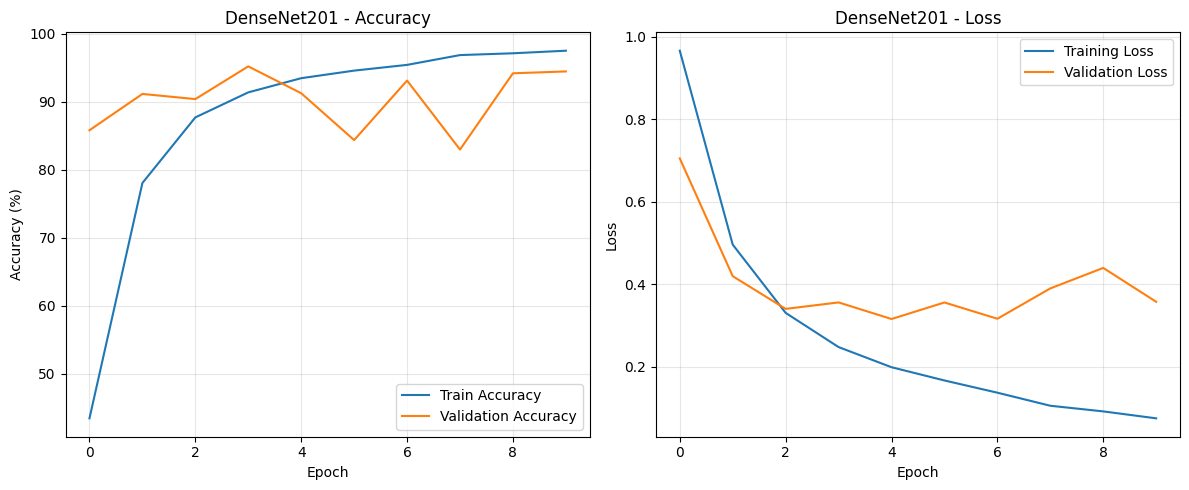


Evaluating DenseNet201 Model...


Getting predictions: 100%|██████████| 118/118 [00:10<00:00, 10.95it/s]



DenseNet201 Classification Report:
              precision    recall  f1-score   support

          no       0.79      1.00      0.88      2500
        vort       0.94      0.87      0.90      2500
      sphere       0.95      0.77      0.85      2500

    accuracy                           0.88      7500
   macro avg       0.89      0.88      0.88      7500
weighted avg       0.89      0.88      0.88      7500



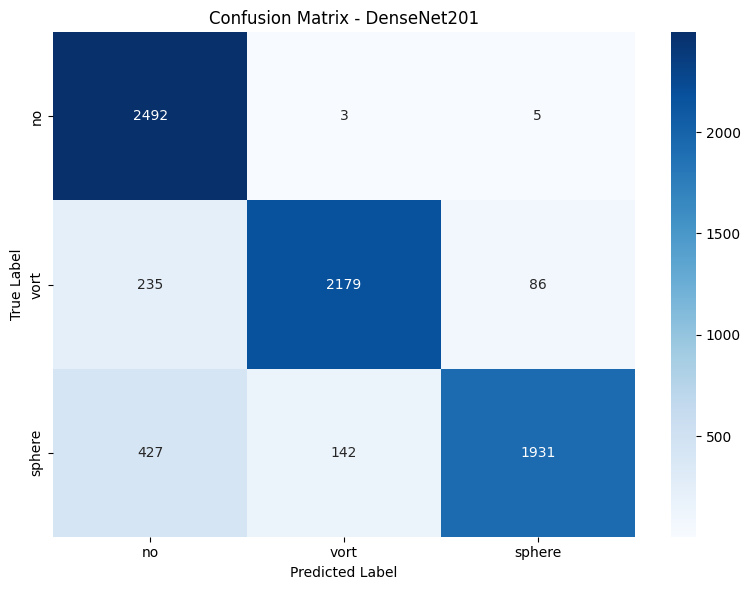

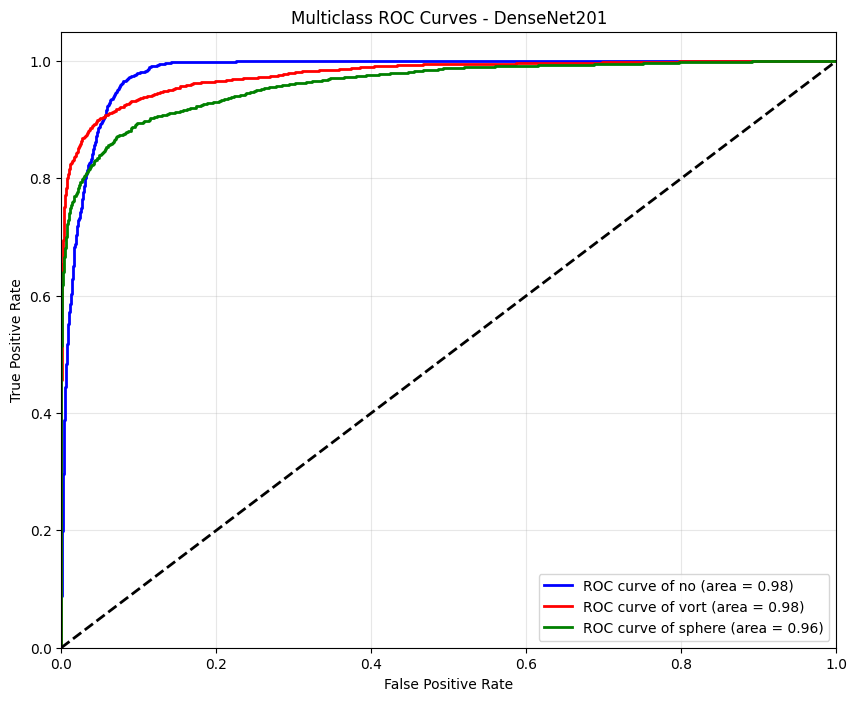

AUC (OVO): 0.9733
AUC (OVR): 0.9733


In [4]:
#%% Cell 2: DenseNet201 – Training and Evaluation

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create criterion if not already defined
criterion = nn.CrossEntropyLoss()

# Initialize DenseNet201 model and move to device
print("Initializing DenseNet201 Model...")
densenet201_model = DenseNet201Model().to(device)

optimizer_201 = torch.optim.Adam(densenet201_model.parameters(), lr=CONFIG.LEARNING_RATE)
history_201 = defaultdict(list)
best_accuracy_201 = 0

for epoch in range(CONFIG.EPOCHS):
    print(f"\nEpoch {epoch + 1}/{CONFIG.EPOCHS} - Training DenseNet201")
    print('-' * 20)
    
    train_accuracy, train_loss = train_one_epoch(
        model=densenet201_model,
        optimizer=optimizer_201,
        data_loader=train_loader
    )
    
    train_accuracy = convert_tensor_list_to_single_mean_value(train_accuracy)
    train_loss = convert_tensor_list_to_single_mean_value(train_loss)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.2f}%')
    
    val_accuracy, val_loss, y_test, y_pred, y_probs = test_model(
        model=densenet201_model,
        data_loader=val_loader
    )
    
    val_accuracy = convert_tensor_list_to_single_mean_value(val_accuracy)
    val_loss = convert_tensor_list_to_single_mean_value(val_loss)
    print(f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.2f}%')
    
    history_201['train_acc'].append(train_accuracy)
    history_201['train_loss'].append(train_loss)
    history_201['val_acc'].append(val_accuracy)
    history_201['val_loss'].append(val_loss)
    
    if val_accuracy > best_accuracy_201:
        torch.save(densenet201_model.state_dict(), '/kaggle/working/densenet201_best.pth')
        best_accuracy_201 = val_accuracy
        print(f"New best DenseNet201 model saved with accuracy: {best_accuracy_201:.2f}%")

# Reinitialize and load saved DenseNet201 model for inference/evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet201_model = DenseNet201Model().to(device)
densenet201_model.load_state_dict(torch.load('/kaggle/working/densenet201_best.pth', map_location=device))
densenet201_model.eval()

print("DenseNet201 model is ready for inference/evaluation.")

# -------------------------------
# Evaluation Code for DenseNet201
# -------------------------------

# Plot training history for DenseNet201
generate_acc_loss_plots(history_201, "DenseNet201")

# Get predictions for DenseNet201
print("\nEvaluating DenseNet201 Model...")
y_test_201, y_pred_201, y_pred_prob_201 = get_model_predictions(densenet201_model, val_loader)

# Display classification report
print("\nDenseNet201 Classification Report:")
print(classification_report(y_test_201, y_pred_201, target_names=[idx_to_class[i] for i in range(len(classes))]))

# Plot confusion matrix for DenseNet201
plot_confusion_matrix(y_test_201, y_pred_201, "DenseNet201")

# Plot ROC curve for DenseNet201
plot_roc_curves(y_test_201, y_pred_prob_201, class_names, "DenseNet201")

# -------------------------------
# End of DenseNet201 Cell
# -------------------------------


In [13]:
import os, gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
gc.collect()


0

Using device: cuda
Loading best DenseNet161 and DenseNet201 models for ensemble...


<ipython-input-14-8b9baf03a916>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  densenet161_model.load_state_dict(torch.load('/kaggle/working/densenet161_best.pth', map_lo


Epoch 1/10 - Training Ensemble Model
--------------------


  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-1-40bd5bd050bb>:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss.append(torch.tensor(loss))
  0%|          | 1/469 [00:00<07:38,  1.02it/s]

Batch 0: Loss: 0.1056, Accuracy: 96.88%


  2%|▏         | 11/469 [00:08<05:26,  1.40it/s]

Batch 10: Loss: 0.2055, Accuracy: 96.31%


  4%|▍         | 21/469 [00:14<05:15,  1.42it/s]

Batch 20: Loss: 0.1726, Accuracy: 95.39%


  7%|▋         | 31/469 [00:21<05:08,  1.42it/s]

Batch 30: Loss: 0.1788, Accuracy: 95.26%


  9%|▊         | 41/469 [00:27<05:01,  1.42it/s]

Batch 40: Loss: 0.1744, Accuracy: 95.31%


 11%|█         | 51/469 [00:34<04:53,  1.42it/s]

Batch 50: Loss: 0.1039, Accuracy: 95.53%


 13%|█▎        | 61/469 [00:40<04:47,  1.42it/s]

Batch 60: Loss: 0.2072, Accuracy: 95.57%


 15%|█▌        | 71/469 [00:47<04:40,  1.42it/s]

Batch 70: Loss: 0.0899, Accuracy: 95.69%


 17%|█▋        | 81/469 [00:54<04:33,  1.42it/s]

Batch 80: Loss: 0.0687, Accuracy: 95.66%


 19%|█▉        | 91/469 [01:00<04:26,  1.42it/s]

Batch 90: Loss: 0.1680, Accuracy: 95.71%


 22%|██▏       | 101/469 [01:07<04:19,  1.42it/s]

Batch 100: Loss: 0.1548, Accuracy: 95.62%


 24%|██▎       | 111/469 [01:13<04:11,  1.42it/s]

Batch 110: Loss: 0.1043, Accuracy: 95.64%


 26%|██▌       | 121/469 [01:20<04:04,  1.42it/s]

Batch 120: Loss: 0.0978, Accuracy: 95.70%


 28%|██▊       | 131/469 [01:26<03:57,  1.42it/s]

Batch 130: Loss: 0.1282, Accuracy: 95.65%


 30%|███       | 141/469 [01:33<03:50,  1.42it/s]

Batch 140: Loss: 0.1459, Accuracy: 95.57%


 32%|███▏      | 151/469 [01:40<03:43,  1.42it/s]

Batch 150: Loss: 0.0936, Accuracy: 95.56%


 34%|███▍      | 161/469 [01:46<03:36,  1.42it/s]

Batch 160: Loss: 0.1241, Accuracy: 95.45%


 36%|███▋      | 171/469 [01:53<03:29,  1.42it/s]

Batch 170: Loss: 0.1358, Accuracy: 95.48%


 39%|███▊      | 181/469 [01:59<03:22,  1.42it/s]

Batch 180: Loss: 0.1557, Accuracy: 95.44%


 41%|████      | 191/469 [02:06<03:15,  1.42it/s]

Batch 190: Loss: 0.1193, Accuracy: 95.40%


 43%|████▎     | 201/469 [02:12<03:08,  1.42it/s]

Batch 200: Loss: 0.2174, Accuracy: 95.40%


 45%|████▍     | 211/469 [02:19<03:01,  1.42it/s]

Batch 210: Loss: 0.1516, Accuracy: 95.42%


 47%|████▋     | 221/469 [02:25<02:54,  1.42it/s]

Batch 220: Loss: 0.2614, Accuracy: 95.39%


 49%|████▉     | 231/469 [02:32<02:51,  1.39it/s]

Batch 230: Loss: 0.2246, Accuracy: 95.29%


 51%|█████▏    | 241/469 [02:39<02:40,  1.42it/s]

Batch 240: Loss: 0.1420, Accuracy: 95.32%


 54%|█████▎    | 251/469 [02:45<02:33,  1.42it/s]

Batch 250: Loss: 0.0694, Accuracy: 95.34%


 56%|█████▌    | 261/469 [02:52<02:26,  1.42it/s]

Batch 260: Loss: 0.1533, Accuracy: 95.30%


 58%|█████▊    | 271/469 [02:59<02:19,  1.42it/s]

Batch 270: Loss: 0.0762, Accuracy: 95.31%


 60%|█████▉    | 281/469 [03:05<02:12,  1.42it/s]

Batch 280: Loss: 0.1207, Accuracy: 95.25%


 62%|██████▏   | 291/469 [03:12<02:05,  1.42it/s]

Batch 290: Loss: 0.1830, Accuracy: 95.26%


 64%|██████▍   | 301/469 [03:18<01:58,  1.42it/s]

Batch 300: Loss: 0.1514, Accuracy: 95.25%


 66%|██████▋   | 311/469 [03:25<01:51,  1.42it/s]

Batch 310: Loss: 0.1232, Accuracy: 95.21%


 68%|██████▊   | 321/469 [03:31<01:44,  1.42it/s]

Batch 320: Loss: 0.1364, Accuracy: 95.17%


 71%|███████   | 331/469 [03:38<01:37,  1.42it/s]

Batch 330: Loss: 0.2605, Accuracy: 95.17%


 73%|███████▎  | 341/469 [03:45<01:30,  1.42it/s]

Batch 340: Loss: 0.2793, Accuracy: 95.14%


 75%|███████▍  | 351/469 [03:51<01:23,  1.42it/s]

Batch 350: Loss: 0.1860, Accuracy: 95.09%


 77%|███████▋  | 361/469 [03:58<01:16,  1.42it/s]

Batch 360: Loss: 0.0967, Accuracy: 95.08%


 79%|███████▉  | 371/469 [04:04<01:08,  1.42it/s]

Batch 370: Loss: 0.1910, Accuracy: 95.04%


 81%|████████  | 381/469 [04:11<01:01,  1.42it/s]

Batch 380: Loss: 0.1820, Accuracy: 94.99%


 83%|████████▎ | 391/469 [04:17<00:54,  1.42it/s]

Batch 390: Loss: 0.3704, Accuracy: 94.94%


 86%|████████▌ | 401/469 [04:24<00:47,  1.42it/s]

Batch 400: Loss: 0.1213, Accuracy: 94.93%


 88%|████████▊ | 411/469 [04:30<00:40,  1.42it/s]

Batch 410: Loss: 0.0834, Accuracy: 94.92%


 90%|████████▉ | 421/469 [04:37<00:33,  1.42it/s]

Batch 420: Loss: 0.1987, Accuracy: 94.87%


 92%|█████████▏| 431/469 [04:44<00:26,  1.42it/s]

Batch 430: Loss: 0.1411, Accuracy: 94.85%


 94%|█████████▍| 441/469 [04:50<00:19,  1.42it/s]

Batch 440: Loss: 0.0643, Accuracy: 94.86%


 96%|█████████▌| 451/469 [04:57<00:12,  1.42it/s]

Batch 450: Loss: 0.0612, Accuracy: 94.81%


 98%|█████████▊| 461/469 [05:03<00:05,  1.42it/s]

Batch 460: Loss: 0.2100, Accuracy: 94.79%


100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


Train loss: 0.1511, Train accuracy: 95.33%


  0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-1-40bd5bd050bb>:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss.append(torch.tensor(loss))
100%|██████████| 118/118 [00:24<00:00,  4.82it/s]


Val loss: 0.2823, Val accuracy: 90.14%
New best Ensemble model saved with accuracy: 90.14%

Epoch 2/10 - Training Ensemble Model
--------------------


  0%|          | 1/469 [00:01<11:53,  1.52s/it]

Batch 0: Loss: 0.0505, Accuracy: 98.44%


  2%|▏         | 11/469 [00:08<05:25,  1.41it/s]

Batch 10: Loss: 0.1456, Accuracy: 96.45%


  4%|▍         | 21/469 [00:14<05:15,  1.42it/s]

Batch 20: Loss: 0.0678, Accuracy: 96.80%


  7%|▋         | 31/469 [00:21<05:08,  1.42it/s]

Batch 30: Loss: 0.0855, Accuracy: 97.28%


  9%|▊         | 41/469 [00:27<05:01,  1.42it/s]

Batch 40: Loss: 0.0465, Accuracy: 97.26%


 11%|█         | 51/469 [00:34<04:54,  1.42it/s]

Batch 50: Loss: 0.0712, Accuracy: 97.15%


 13%|█▎        | 61/469 [00:40<04:47,  1.42it/s]

Batch 60: Loss: 0.0630, Accuracy: 97.36%


 15%|█▌        | 71/469 [00:47<04:40,  1.42it/s]

Batch 70: Loss: 0.1553, Accuracy: 97.29%


 17%|█▋        | 81/469 [00:54<04:33,  1.42it/s]

Batch 80: Loss: 0.1192, Accuracy: 97.13%


 19%|█▉        | 91/469 [01:00<04:26,  1.42it/s]

Batch 90: Loss: 0.0704, Accuracy: 97.18%


 22%|██▏       | 101/469 [01:07<04:19,  1.42it/s]

Batch 100: Loss: 0.0798, Accuracy: 97.14%


 24%|██▎       | 111/469 [01:13<04:12,  1.42it/s]

Batch 110: Loss: 0.0895, Accuracy: 97.09%


 26%|██▌       | 121/469 [01:20<04:05,  1.42it/s]

Batch 120: Loss: 0.0828, Accuracy: 97.04%


 28%|██▊       | 131/469 [01:26<03:57,  1.42it/s]

Batch 130: Loss: 0.0846, Accuracy: 96.93%


 30%|███       | 141/469 [01:33<03:50,  1.42it/s]

Batch 140: Loss: 0.1667, Accuracy: 96.91%


 32%|███▏      | 151/469 [01:39<03:43,  1.42it/s]

Batch 150: Loss: 0.0630, Accuracy: 96.92%


 34%|███▍      | 161/469 [01:46<03:36,  1.42it/s]

Batch 160: Loss: 0.1505, Accuracy: 96.89%


 36%|███▋      | 171/469 [01:53<03:30,  1.42it/s]

Batch 170: Loss: 0.0951, Accuracy: 96.88%


 39%|███▊      | 181/469 [01:59<03:23,  1.42it/s]

Batch 180: Loss: 0.1296, Accuracy: 96.81%


 41%|████      | 191/469 [02:06<03:15,  1.42it/s]

Batch 190: Loss: 0.0535, Accuracy: 96.76%


 43%|████▎     | 201/469 [02:12<03:08,  1.42it/s]

Batch 200: Loss: 0.1090, Accuracy: 96.69%


 45%|████▍     | 211/469 [02:19<03:01,  1.42it/s]

Batch 210: Loss: 0.0116, Accuracy: 96.68%


 47%|████▋     | 221/469 [02:25<02:54,  1.42it/s]

Batch 220: Loss: 0.0548, Accuracy: 96.68%


 49%|████▉     | 231/469 [02:32<02:47,  1.42it/s]

Batch 230: Loss: 0.0962, Accuracy: 96.68%


 51%|█████▏    | 241/469 [02:39<02:40,  1.42it/s]

Batch 240: Loss: 0.0706, Accuracy: 96.66%


 54%|█████▎    | 251/469 [02:45<02:33,  1.42it/s]

Batch 250: Loss: 0.0395, Accuracy: 96.66%


 56%|█████▌    | 261/469 [02:52<02:26,  1.42it/s]

Batch 260: Loss: 0.0613, Accuracy: 96.59%


 58%|█████▊    | 271/469 [02:58<02:19,  1.42it/s]

Batch 270: Loss: 0.1296, Accuracy: 96.58%


 60%|█████▉    | 281/469 [03:05<02:12,  1.42it/s]

Batch 280: Loss: 0.1077, Accuracy: 96.52%


 62%|██████▏   | 291/469 [03:12<02:05,  1.42it/s]

Batch 290: Loss: 0.1946, Accuracy: 96.52%


 64%|██████▍   | 301/469 [03:18<01:58,  1.42it/s]

Batch 300: Loss: 0.0180, Accuracy: 96.53%


 66%|██████▋   | 311/469 [03:25<01:51,  1.42it/s]

Batch 310: Loss: 0.0677, Accuracy: 96.54%


 68%|██████▊   | 321/469 [03:31<01:44,  1.42it/s]

Batch 320: Loss: 0.1205, Accuracy: 96.51%


 71%|███████   | 331/469 [03:38<01:37,  1.42it/s]

Batch 330: Loss: 0.1146, Accuracy: 96.44%


 73%|███████▎  | 341/469 [03:44<01:30,  1.42it/s]

Batch 340: Loss: 0.2412, Accuracy: 96.42%


 75%|███████▍  | 351/469 [03:51<01:23,  1.42it/s]

Batch 350: Loss: 0.0522, Accuracy: 96.43%


 77%|███████▋  | 361/469 [03:58<01:16,  1.42it/s]

Batch 360: Loss: 0.1223, Accuracy: 96.40%


 79%|███████▉  | 371/469 [04:04<01:09,  1.42it/s]

Batch 370: Loss: 0.1147, Accuracy: 96.40%


 81%|████████  | 381/469 [04:11<01:01,  1.42it/s]

Batch 380: Loss: 0.2198, Accuracy: 96.40%


 83%|████████▎ | 391/469 [04:17<00:54,  1.42it/s]

Batch 390: Loss: 0.0597, Accuracy: 96.39%


 86%|████████▌ | 401/469 [04:24<00:47,  1.42it/s]

Batch 400: Loss: 0.1072, Accuracy: 96.37%


 88%|████████▊ | 411/469 [04:30<00:40,  1.42it/s]

Batch 410: Loss: 0.2204, Accuracy: 96.32%


 90%|████████▉ | 421/469 [04:37<00:33,  1.42it/s]

Batch 420: Loss: 0.0593, Accuracy: 96.32%


 92%|█████████▏| 431/469 [04:43<00:26,  1.42it/s]

Batch 430: Loss: 0.0996, Accuracy: 96.27%


 94%|█████████▍| 441/469 [04:50<00:19,  1.42it/s]

Batch 440: Loss: 0.0339, Accuracy: 96.24%


 96%|█████████▌| 451/469 [04:57<00:12,  1.42it/s]

Batch 450: Loss: 0.0888, Accuracy: 96.23%


 98%|█████████▊| 461/469 [05:03<00:05,  1.42it/s]

Batch 460: Loss: 0.0521, Accuracy: 96.19%


100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


Train loss: 0.1107, Train accuracy: 96.69%


100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Val loss: 0.2757, Val accuracy: 93.76%
New best Ensemble model saved with accuracy: 93.76%

Epoch 3/10 - Training Ensemble Model
--------------------


  0%|          | 1/469 [00:00<06:29,  1.20it/s]

Batch 0: Loss: 0.0754, Accuracy: 96.88%


  2%|▏         | 11/469 [00:07<05:23,  1.42it/s]

Batch 10: Loss: 0.0781, Accuracy: 97.87%


  4%|▍         | 21/469 [00:13<05:15,  1.42it/s]

Batch 20: Loss: 0.0799, Accuracy: 97.32%


  7%|▋         | 31/469 [00:20<05:08,  1.42it/s]

Batch 30: Loss: 0.0181, Accuracy: 97.88%


  9%|▊         | 41/469 [00:27<05:11,  1.37it/s]

Batch 40: Loss: 0.0189, Accuracy: 97.48%


 11%|█         | 51/469 [00:33<04:54,  1.42it/s]

Batch 50: Loss: 0.0759, Accuracy: 97.40%


 13%|█▎        | 61/469 [00:40<04:47,  1.42it/s]

Batch 60: Loss: 0.1214, Accuracy: 97.49%


 15%|█▌        | 71/469 [00:47<04:40,  1.42it/s]

Batch 70: Loss: 0.1600, Accuracy: 97.49%


 17%|█▋        | 81/469 [00:53<04:33,  1.42it/s]

Batch 80: Loss: 0.0148, Accuracy: 97.59%


 19%|█▉        | 91/469 [01:00<04:25,  1.42it/s]

Batch 90: Loss: 0.0200, Accuracy: 97.58%


 22%|██▏       | 101/469 [01:06<04:19,  1.42it/s]

Batch 100: Loss: 0.1351, Accuracy: 97.48%


 24%|██▎       | 111/469 [01:13<04:12,  1.42it/s]

Batch 110: Loss: 0.0361, Accuracy: 97.42%


 26%|██▌       | 121/469 [01:19<04:04,  1.42it/s]

Batch 120: Loss: 0.0412, Accuracy: 97.40%


 28%|██▊       | 131/469 [01:26<03:58,  1.42it/s]

Batch 130: Loss: 0.0432, Accuracy: 97.40%


 30%|███       | 141/469 [01:32<03:50,  1.42it/s]

Batch 140: Loss: 0.0120, Accuracy: 97.43%


 32%|███▏      | 151/469 [01:39<03:43,  1.42it/s]

Batch 150: Loss: 0.0221, Accuracy: 97.44%


 34%|███▍      | 161/469 [01:46<03:36,  1.42it/s]

Batch 160: Loss: 0.0629, Accuracy: 97.45%


 36%|███▋      | 171/469 [01:52<03:29,  1.42it/s]

Batch 170: Loss: 0.0440, Accuracy: 97.41%


 39%|███▊      | 181/469 [01:59<03:22,  1.42it/s]

Batch 180: Loss: 0.1212, Accuracy: 97.41%


 41%|████      | 191/469 [02:05<03:15,  1.42it/s]

Batch 190: Loss: 0.1447, Accuracy: 97.37%


 43%|████▎     | 201/469 [02:12<03:08,  1.42it/s]

Batch 200: Loss: 0.1285, Accuracy: 97.29%


 45%|████▍     | 211/469 [02:18<03:01,  1.42it/s]

Batch 210: Loss: 0.1003, Accuracy: 97.25%


 47%|████▋     | 221/469 [02:25<02:54,  1.42it/s]

Batch 220: Loss: 0.0293, Accuracy: 97.19%


 49%|████▉     | 231/469 [02:32<02:47,  1.42it/s]

Batch 230: Loss: 0.0263, Accuracy: 97.20%


 51%|█████▏    | 241/469 [02:38<02:40,  1.42it/s]

Batch 240: Loss: 0.0319, Accuracy: 97.24%


 54%|█████▎    | 251/469 [02:45<02:33,  1.42it/s]

Batch 250: Loss: 0.0951, Accuracy: 97.22%


 56%|█████▌    | 261/469 [02:51<02:26,  1.42it/s]

Batch 260: Loss: 0.0177, Accuracy: 97.23%


 58%|█████▊    | 271/469 [02:58<02:19,  1.42it/s]

Batch 270: Loss: 0.1368, Accuracy: 97.21%


 60%|█████▉    | 281/469 [03:04<02:12,  1.42it/s]

Batch 280: Loss: 0.0477, Accuracy: 97.16%


 62%|██████▏   | 291/469 [03:11<02:05,  1.42it/s]

Batch 290: Loss: 0.1289, Accuracy: 97.12%


 64%|██████▍   | 301/469 [03:18<01:58,  1.42it/s]

Batch 300: Loss: 0.0708, Accuracy: 97.09%


 66%|██████▋   | 311/469 [03:24<01:51,  1.42it/s]

Batch 310: Loss: 0.0792, Accuracy: 97.07%


 68%|██████▊   | 321/469 [03:31<01:44,  1.42it/s]

Batch 320: Loss: 0.0874, Accuracy: 97.06%


 71%|███████   | 331/469 [03:37<01:37,  1.42it/s]

Batch 330: Loss: 0.0990, Accuracy: 97.04%


 73%|███████▎  | 341/469 [03:44<01:30,  1.42it/s]

Batch 340: Loss: 0.0180, Accuracy: 97.06%


 75%|███████▍  | 351/469 [03:50<01:23,  1.42it/s]

Batch 350: Loss: 0.1777, Accuracy: 97.03%


 77%|███████▋  | 361/469 [03:57<01:16,  1.42it/s]

Batch 360: Loss: 0.1870, Accuracy: 97.01%


 79%|███████▉  | 371/469 [04:04<01:09,  1.42it/s]

Batch 370: Loss: 0.0350, Accuracy: 97.00%


 81%|████████  | 381/469 [04:10<01:01,  1.42it/s]

Batch 380: Loss: 0.0463, Accuracy: 96.96%


 83%|████████▎ | 391/469 [04:17<00:54,  1.42it/s]

Batch 390: Loss: 0.0919, Accuracy: 96.97%


 86%|████████▌ | 401/469 [04:23<00:47,  1.42it/s]

Batch 400: Loss: 0.1080, Accuracy: 96.92%


 88%|████████▊ | 411/469 [04:30<00:40,  1.42it/s]

Batch 410: Loss: 0.0861, Accuracy: 96.91%


 90%|████████▉ | 421/469 [04:36<00:33,  1.42it/s]

Batch 420: Loss: 0.0510, Accuracy: 96.85%


 92%|█████████▏| 431/469 [04:43<00:26,  1.42it/s]

Batch 430: Loss: 0.0894, Accuracy: 96.85%


 94%|█████████▍| 441/469 [04:50<00:19,  1.42it/s]

Batch 440: Loss: 0.1220, Accuracy: 96.83%


 96%|█████████▌| 451/469 [04:56<00:12,  1.42it/s]

Batch 450: Loss: 0.0899, Accuracy: 96.80%


 98%|█████████▊| 461/469 [05:03<00:05,  1.42it/s]

Batch 460: Loss: 0.1837, Accuracy: 96.76%


100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


Train loss: 0.0911, Train accuracy: 97.23%


100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Val loss: 0.2813, Val accuracy: 91.15%

Epoch 4/10 - Training Ensemble Model
--------------------


  0%|          | 1/469 [00:00<06:33,  1.19it/s]

Batch 0: Loss: 0.0920, Accuracy: 96.88%


  2%|▏         | 11/469 [00:07<05:23,  1.42it/s]

Batch 10: Loss: 0.0962, Accuracy: 97.73%


  4%|▍         | 21/469 [00:13<05:15,  1.42it/s]

Batch 20: Loss: 0.0622, Accuracy: 97.84%


  7%|▋         | 31/469 [00:20<05:08,  1.42it/s]

Batch 30: Loss: 0.0579, Accuracy: 97.93%


  9%|▊         | 41/469 [00:27<05:01,  1.42it/s]

Batch 40: Loss: 0.0534, Accuracy: 97.68%


 11%|█         | 51/469 [00:33<04:54,  1.42it/s]

Batch 50: Loss: 0.0603, Accuracy: 97.82%


 13%|█▎        | 61/469 [00:40<04:46,  1.42it/s]

Batch 60: Loss: 0.0562, Accuracy: 97.80%


 15%|█▌        | 71/469 [00:46<04:40,  1.42it/s]

Batch 70: Loss: 0.0367, Accuracy: 97.80%


 17%|█▋        | 81/469 [00:53<04:36,  1.40it/s]

Batch 80: Loss: 0.0240, Accuracy: 97.76%


 19%|█▉        | 91/469 [01:00<04:26,  1.42it/s]

Batch 90: Loss: 0.0334, Accuracy: 97.73%


 22%|██▏       | 101/469 [01:06<04:19,  1.42it/s]

Batch 100: Loss: 0.0469, Accuracy: 97.79%


 24%|██▎       | 111/469 [01:13<04:12,  1.42it/s]

Batch 110: Loss: 0.1260, Accuracy: 97.80%


 26%|██▌       | 121/469 [01:19<04:05,  1.42it/s]

Batch 120: Loss: 0.0248, Accuracy: 97.91%


 28%|██▊       | 131/469 [01:26<03:58,  1.42it/s]

Batch 130: Loss: 0.0323, Accuracy: 97.94%


 30%|███       | 141/469 [01:33<03:50,  1.42it/s]

Batch 140: Loss: 0.1065, Accuracy: 97.96%


 32%|███▏      | 151/469 [01:39<03:43,  1.42it/s]

Batch 150: Loss: 0.0155, Accuracy: 97.97%


 34%|███▍      | 161/469 [01:46<03:36,  1.42it/s]

Batch 160: Loss: 0.1317, Accuracy: 97.93%


 36%|███▋      | 171/469 [01:52<03:30,  1.42it/s]

Batch 170: Loss: 0.0979, Accuracy: 97.93%


 39%|███▊      | 181/469 [01:59<03:23,  1.42it/s]

Batch 180: Loss: 0.0289, Accuracy: 97.93%


 41%|████      | 191/469 [02:05<03:15,  1.42it/s]

Batch 190: Loss: 0.0494, Accuracy: 97.88%


 43%|████▎     | 201/469 [02:12<03:08,  1.42it/s]

Batch 200: Loss: 0.0214, Accuracy: 97.88%


 45%|████▍     | 211/469 [02:19<03:01,  1.42it/s]

Batch 210: Loss: 0.0517, Accuracy: 97.88%


 47%|████▋     | 221/469 [02:25<02:54,  1.42it/s]

Batch 220: Loss: 0.0376, Accuracy: 97.86%


 49%|████▉     | 231/469 [02:32<02:47,  1.42it/s]

Batch 230: Loss: 0.0439, Accuracy: 97.82%


 51%|█████▏    | 241/469 [02:38<02:40,  1.42it/s]

Batch 240: Loss: 0.0914, Accuracy: 97.80%


 54%|█████▎    | 251/469 [02:45<02:33,  1.42it/s]

Batch 250: Loss: 0.0487, Accuracy: 97.81%


 56%|█████▌    | 261/469 [02:51<02:26,  1.42it/s]

Batch 260: Loss: 0.0281, Accuracy: 97.80%


 58%|█████▊    | 271/469 [02:58<02:19,  1.42it/s]

Batch 270: Loss: 0.0134, Accuracy: 97.81%


 60%|█████▉    | 281/469 [03:05<02:12,  1.42it/s]

Batch 280: Loss: 0.0885, Accuracy: 97.79%


 62%|██████▏   | 291/469 [03:11<02:05,  1.42it/s]

Batch 290: Loss: 0.0356, Accuracy: 97.78%


 64%|██████▍   | 301/469 [03:18<01:58,  1.42it/s]

Batch 300: Loss: 0.0917, Accuracy: 97.73%


 66%|██████▋   | 311/469 [03:24<01:51,  1.42it/s]

Batch 310: Loss: 0.0147, Accuracy: 97.75%


 68%|██████▊   | 321/469 [03:31<01:44,  1.42it/s]

Batch 320: Loss: 0.0269, Accuracy: 97.71%


 71%|███████   | 331/469 [03:37<01:37,  1.42it/s]

Batch 330: Loss: 0.2340, Accuracy: 97.68%


 73%|███████▎  | 341/469 [03:44<01:30,  1.42it/s]

Batch 340: Loss: 0.0689, Accuracy: 97.70%


 75%|███████▍  | 351/469 [03:51<01:23,  1.42it/s]

Batch 350: Loss: 0.0189, Accuracy: 97.70%


 77%|███████▋  | 361/469 [03:57<01:16,  1.42it/s]

Batch 360: Loss: 0.1192, Accuracy: 97.72%


 79%|███████▉  | 371/469 [04:04<01:09,  1.42it/s]

Batch 370: Loss: 0.0450, Accuracy: 97.73%


 81%|████████  | 381/469 [04:10<01:01,  1.42it/s]

Batch 380: Loss: 0.1325, Accuracy: 97.74%


 83%|████████▎ | 391/469 [04:17<00:54,  1.42it/s]

Batch 390: Loss: 0.0651, Accuracy: 97.75%


 86%|████████▌ | 401/469 [04:23<00:47,  1.42it/s]

Batch 400: Loss: 0.1000, Accuracy: 97.72%


 88%|████████▊ | 411/469 [04:30<00:40,  1.42it/s]

Batch 410: Loss: 0.1277, Accuracy: 97.70%


 90%|████████▉ | 421/469 [04:37<00:33,  1.42it/s]

Batch 420: Loss: 0.1195, Accuracy: 97.67%


 92%|█████████▏| 431/469 [04:43<00:26,  1.42it/s]

Batch 430: Loss: 0.1020, Accuracy: 97.66%


 94%|█████████▍| 441/469 [04:50<00:19,  1.42it/s]

Batch 440: Loss: 0.0479, Accuracy: 97.64%


 96%|█████████▌| 451/469 [04:56<00:12,  1.42it/s]

Batch 450: Loss: 0.0463, Accuracy: 97.64%


 98%|█████████▊| 461/469 [05:03<00:05,  1.42it/s]

Batch 460: Loss: 0.1232, Accuracy: 97.62%


100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


Train loss: 0.0720, Train accuracy: 97.76%


100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Val loss: 0.2845, Val accuracy: 93.72%

Epoch 5/10 - Training Ensemble Model
--------------------


  0%|          | 1/469 [00:00<06:30,  1.20it/s]

Batch 0: Loss: 0.0371, Accuracy: 98.44%


  2%|▏         | 11/469 [00:07<05:23,  1.42it/s]

Batch 10: Loss: 0.0448, Accuracy: 98.15%


  4%|▍         | 21/469 [00:13<05:15,  1.42it/s]

Batch 20: Loss: 0.0306, Accuracy: 98.66%


  7%|▋         | 31/469 [00:20<05:08,  1.42it/s]

Batch 30: Loss: 0.0136, Accuracy: 98.74%


  9%|▊         | 41/469 [00:27<05:02,  1.42it/s]

Batch 40: Loss: 0.0225, Accuracy: 98.59%


 11%|█         | 51/469 [00:33<04:54,  1.42it/s]

Batch 50: Loss: 0.0450, Accuracy: 98.68%


 13%|█▎        | 61/469 [00:40<04:47,  1.42it/s]

Batch 60: Loss: 0.0050, Accuracy: 98.77%


 15%|█▌        | 71/469 [00:46<04:40,  1.42it/s]

Batch 70: Loss: 0.0077, Accuracy: 98.72%


 17%|█▋        | 81/469 [00:53<04:33,  1.42it/s]

Batch 80: Loss: 0.0078, Accuracy: 98.73%


 19%|█▉        | 91/469 [00:59<04:26,  1.42it/s]

Batch 90: Loss: 0.0553, Accuracy: 98.61%


 22%|██▏       | 101/469 [01:06<04:19,  1.42it/s]

Batch 100: Loss: 0.0357, Accuracy: 98.69%


 24%|██▎       | 111/469 [01:13<04:12,  1.42it/s]

Batch 110: Loss: 0.0273, Accuracy: 98.66%


 26%|██▌       | 121/469 [01:19<04:05,  1.42it/s]

Batch 120: Loss: 0.0730, Accuracy: 98.63%


 28%|██▊       | 131/469 [01:26<03:58,  1.42it/s]

Batch 130: Loss: 0.0119, Accuracy: 98.63%


 30%|███       | 141/469 [01:32<03:51,  1.42it/s]

Batch 140: Loss: 0.0103, Accuracy: 98.60%


 32%|███▏      | 151/469 [01:39<03:43,  1.42it/s]

Batch 150: Loss: 0.1003, Accuracy: 98.57%


 34%|███▍      | 161/469 [01:45<03:37,  1.42it/s]

Batch 160: Loss: 0.0275, Accuracy: 98.57%


 36%|███▋      | 171/469 [01:52<03:40,  1.35it/s]

Batch 170: Loss: 0.0883, Accuracy: 98.50%


 39%|███▊      | 181/469 [01:59<03:23,  1.42it/s]

Batch 180: Loss: 0.0374, Accuracy: 98.44%


 41%|████      | 191/469 [02:05<03:15,  1.42it/s]

Batch 190: Loss: 0.0416, Accuracy: 98.37%


 43%|████▎     | 201/469 [02:12<03:08,  1.42it/s]

Batch 200: Loss: 0.0144, Accuracy: 98.33%


 45%|████▍     | 211/469 [02:19<03:01,  1.42it/s]

Batch 210: Loss: 0.0624, Accuracy: 98.33%


 47%|████▋     | 221/469 [02:25<02:54,  1.42it/s]

Batch 220: Loss: 0.1002, Accuracy: 98.32%


 49%|████▉     | 231/469 [02:32<02:47,  1.42it/s]

Batch 230: Loss: 0.0167, Accuracy: 98.31%


 51%|█████▏    | 241/469 [02:38<02:40,  1.42it/s]

Batch 240: Loss: 0.0538, Accuracy: 98.29%


 54%|█████▎    | 251/469 [02:45<02:33,  1.42it/s]

Batch 250: Loss: 0.0291, Accuracy: 98.31%


 56%|█████▌    | 261/469 [02:51<02:26,  1.42it/s]

Batch 260: Loss: 0.0392, Accuracy: 98.30%


 58%|█████▊    | 271/469 [02:58<02:19,  1.42it/s]

Batch 270: Loss: 0.0811, Accuracy: 98.27%


 60%|█████▉    | 281/469 [03:05<02:12,  1.42it/s]

Batch 280: Loss: 0.0689, Accuracy: 98.23%


 62%|██████▏   | 291/469 [03:11<02:05,  1.42it/s]

Batch 290: Loss: 0.0662, Accuracy: 98.22%


 64%|██████▍   | 301/469 [03:18<01:58,  1.42it/s]

Batch 300: Loss: 0.1056, Accuracy: 98.18%


 66%|██████▋   | 311/469 [03:24<01:51,  1.42it/s]

Batch 310: Loss: 0.0628, Accuracy: 98.13%


 68%|██████▊   | 321/469 [03:31<01:44,  1.42it/s]

Batch 320: Loss: 0.0203, Accuracy: 98.14%


 71%|███████   | 331/469 [03:37<01:37,  1.42it/s]

Batch 330: Loss: 0.0987, Accuracy: 98.13%


 73%|███████▎  | 341/469 [03:44<01:30,  1.42it/s]

Batch 340: Loss: 0.0959, Accuracy: 98.10%


 75%|███████▍  | 351/469 [03:51<01:23,  1.42it/s]

Batch 350: Loss: 0.1190, Accuracy: 98.10%


 77%|███████▋  | 361/469 [03:57<01:16,  1.42it/s]

Batch 360: Loss: 0.1060, Accuracy: 98.07%


 79%|███████▉  | 371/469 [04:04<01:09,  1.42it/s]

Batch 370: Loss: 0.0822, Accuracy: 98.02%


 81%|████████  | 381/469 [04:10<01:01,  1.42it/s]

Batch 380: Loss: 0.1129, Accuracy: 98.02%


 83%|████████▎ | 391/469 [04:17<00:54,  1.42it/s]

Batch 390: Loss: 0.0670, Accuracy: 97.99%


 86%|████████▌ | 401/469 [04:23<00:47,  1.42it/s]

Batch 400: Loss: 0.0076, Accuracy: 97.97%


 88%|████████▊ | 411/469 [04:30<00:40,  1.42it/s]

Batch 410: Loss: 0.0687, Accuracy: 97.97%


 90%|████████▉ | 421/469 [04:36<00:33,  1.42it/s]

Batch 420: Loss: 0.0428, Accuracy: 97.97%


 92%|█████████▏| 431/469 [04:43<00:26,  1.42it/s]

Batch 430: Loss: 0.0888, Accuracy: 97.93%


 94%|█████████▍| 441/469 [04:50<00:20,  1.38it/s]

Batch 440: Loss: 0.0764, Accuracy: 97.90%


 96%|█████████▌| 451/469 [04:56<00:12,  1.42it/s]

Batch 450: Loss: 0.0502, Accuracy: 97.87%


 98%|█████████▊| 461/469 [05:03<00:05,  1.42it/s]

Batch 460: Loss: 0.1020, Accuracy: 97.85%


100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


Train loss: 0.0634, Train accuracy: 98.31%


100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Val loss: 0.3764, Val accuracy: 95.96%
New best Ensemble model saved with accuracy: 95.96%

Epoch 6/10 - Training Ensemble Model
--------------------


  0%|          | 1/469 [00:00<06:30,  1.20it/s]

Batch 0: Loss: 0.0542, Accuracy: 98.44%


  2%|▏         | 11/469 [00:07<05:23,  1.42it/s]

Batch 10: Loss: 0.1810, Accuracy: 97.73%


  4%|▍         | 21/469 [00:13<05:15,  1.42it/s]

Batch 20: Loss: 0.0586, Accuracy: 98.07%


  7%|▋         | 31/469 [00:20<05:08,  1.42it/s]

Batch 30: Loss: 0.0345, Accuracy: 98.08%


  9%|▊         | 41/469 [00:27<05:01,  1.42it/s]

Batch 40: Loss: 0.0435, Accuracy: 98.09%


 11%|█         | 51/469 [00:33<04:54,  1.42it/s]

Batch 50: Loss: 0.1381, Accuracy: 98.10%


 13%|█▎        | 61/469 [00:40<04:47,  1.42it/s]

Batch 60: Loss: 0.0195, Accuracy: 98.18%


 15%|█▌        | 71/469 [00:46<04:40,  1.42it/s]

Batch 70: Loss: 0.0343, Accuracy: 98.28%


 17%|█▋        | 81/469 [00:53<04:33,  1.42it/s]

Batch 80: Loss: 0.0309, Accuracy: 98.42%


 19%|█▉        | 91/469 [00:59<04:26,  1.42it/s]

Batch 90: Loss: 0.0310, Accuracy: 98.44%


 22%|██▏       | 101/469 [01:06<04:19,  1.42it/s]

Batch 100: Loss: 0.0604, Accuracy: 98.41%


 24%|██▎       | 111/469 [01:13<04:12,  1.42it/s]

Batch 110: Loss: 0.0045, Accuracy: 98.45%


 26%|██▌       | 121/469 [01:19<04:05,  1.42it/s]

Batch 120: Loss: 0.0421, Accuracy: 98.53%


 28%|██▊       | 131/469 [01:26<03:58,  1.42it/s]

Batch 130: Loss: 0.1202, Accuracy: 98.56%


 30%|███       | 141/469 [01:32<03:50,  1.42it/s]

Batch 140: Loss: 0.0428, Accuracy: 98.58%


 32%|███▏      | 151/469 [01:39<03:43,  1.42it/s]

Batch 150: Loss: 0.0499, Accuracy: 98.50%


 34%|███▍      | 161/469 [01:45<03:37,  1.42it/s]

Batch 160: Loss: 0.1491, Accuracy: 98.49%


 36%|███▋      | 171/469 [01:52<03:29,  1.42it/s]

Batch 170: Loss: 0.0335, Accuracy: 98.44%


 39%|███▊      | 181/469 [01:59<03:22,  1.42it/s]

Batch 180: Loss: 0.1155, Accuracy: 98.38%


 41%|████      | 191/469 [02:05<03:15,  1.42it/s]

Batch 190: Loss: 0.0780, Accuracy: 98.38%


 43%|████▎     | 201/469 [02:12<03:08,  1.42it/s]

Batch 200: Loss: 0.0599, Accuracy: 98.33%


 45%|████▍     | 211/469 [02:18<03:01,  1.42it/s]

Batch 210: Loss: 0.0412, Accuracy: 98.33%


 47%|████▋     | 221/469 [02:25<03:03,  1.35it/s]

Batch 220: Loss: 0.0616, Accuracy: 98.27%


 49%|████▉     | 231/469 [02:32<02:47,  1.42it/s]

Batch 230: Loss: 0.0391, Accuracy: 98.27%


 51%|█████▏    | 241/469 [02:38<02:40,  1.42it/s]

Batch 240: Loss: 0.0264, Accuracy: 98.24%


 54%|█████▎    | 251/469 [02:45<02:33,  1.42it/s]

Batch 250: Loss: 0.0756, Accuracy: 98.23%


 56%|█████▌    | 261/469 [02:51<02:26,  1.42it/s]

Batch 260: Loss: 0.0724, Accuracy: 98.23%


 58%|█████▊    | 271/469 [02:58<02:19,  1.42it/s]

Batch 270: Loss: 0.0261, Accuracy: 98.24%


 60%|█████▉    | 281/469 [03:04<02:12,  1.42it/s]

Batch 280: Loss: 0.0170, Accuracy: 98.25%


 62%|██████▏   | 291/469 [03:11<02:05,  1.42it/s]

Batch 290: Loss: 0.0093, Accuracy: 98.28%


 64%|██████▍   | 301/469 [03:18<01:58,  1.42it/s]

Batch 300: Loss: 0.0488, Accuracy: 98.27%


 66%|██████▋   | 311/469 [03:24<01:51,  1.42it/s]

Batch 310: Loss: 0.1029, Accuracy: 98.26%


 68%|██████▊   | 321/469 [03:31<01:44,  1.42it/s]

Batch 320: Loss: 0.0288, Accuracy: 98.29%


 71%|███████   | 331/469 [03:37<01:37,  1.42it/s]

Batch 330: Loss: 0.0322, Accuracy: 98.28%


 73%|███████▎  | 341/469 [03:44<01:30,  1.42it/s]

Batch 340: Loss: 0.0748, Accuracy: 98.26%


 75%|███████▍  | 351/469 [03:50<01:23,  1.42it/s]

Batch 350: Loss: 0.0227, Accuracy: 98.27%


 77%|███████▋  | 361/469 [03:57<01:16,  1.42it/s]

Batch 360: Loss: 0.0918, Accuracy: 98.26%


 79%|███████▉  | 371/469 [04:04<01:08,  1.42it/s]

Batch 370: Loss: 0.0222, Accuracy: 98.26%


 81%|████████  | 381/469 [04:10<01:01,  1.42it/s]

Batch 380: Loss: 0.0813, Accuracy: 98.24%


 83%|████████▎ | 391/469 [04:17<00:54,  1.42it/s]

Batch 390: Loss: 0.0380, Accuracy: 98.25%


 86%|████████▌ | 401/469 [04:23<00:47,  1.42it/s]

Batch 400: Loss: 0.0072, Accuracy: 98.27%


 88%|████████▊ | 411/469 [04:30<00:40,  1.42it/s]

Batch 410: Loss: 0.0297, Accuracy: 98.28%


 90%|████████▉ | 421/469 [04:36<00:33,  1.42it/s]

Batch 420: Loss: 0.0125, Accuracy: 98.27%


 92%|█████████▏| 431/469 [04:43<00:26,  1.42it/s]

Batch 430: Loss: 0.0045, Accuracy: 98.29%


 94%|█████████▍| 441/469 [04:50<00:19,  1.42it/s]

Batch 440: Loss: 0.0072, Accuracy: 98.28%


 96%|█████████▌| 451/469 [04:56<00:12,  1.42it/s]

Batch 450: Loss: 0.0239, Accuracy: 98.28%


 98%|█████████▊| 461/469 [05:03<00:05,  1.42it/s]

Batch 460: Loss: 0.0179, Accuracy: 98.30%


100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


Train loss: 0.0519, Train accuracy: 98.29%


100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Val loss: 0.3193, Val accuracy: 94.11%

Epoch 7/10 - Training Ensemble Model
--------------------


  0%|          | 1/469 [00:00<06:34,  1.19it/s]

Batch 0: Loss: 0.0509, Accuracy: 96.88%


  2%|▏         | 11/469 [00:07<05:23,  1.42it/s]

Batch 10: Loss: 0.0491, Accuracy: 98.86%


  4%|▍         | 21/469 [00:13<05:15,  1.42it/s]

Batch 20: Loss: 0.0232, Accuracy: 99.18%


  7%|▋         | 31/469 [00:20<05:38,  1.29it/s]

Batch 30: Loss: 0.0533, Accuracy: 99.09%


  9%|▊         | 41/469 [00:27<05:02,  1.42it/s]

Batch 40: Loss: 0.0065, Accuracy: 98.97%


 11%|█         | 51/469 [00:33<04:54,  1.42it/s]

Batch 50: Loss: 0.1055, Accuracy: 98.68%


 13%|█▎        | 61/469 [00:40<04:47,  1.42it/s]

Batch 60: Loss: 0.0356, Accuracy: 98.69%


 15%|█▌        | 71/469 [00:47<04:40,  1.42it/s]

Batch 70: Loss: 0.0745, Accuracy: 98.61%


 17%|█▋        | 81/469 [00:53<04:33,  1.42it/s]

Batch 80: Loss: 0.0359, Accuracy: 98.57%


 19%|█▉        | 91/469 [01:00<04:26,  1.42it/s]

Batch 90: Loss: 0.0365, Accuracy: 98.52%


 22%|██▏       | 101/469 [01:06<04:19,  1.42it/s]

Batch 100: Loss: 0.0813, Accuracy: 98.51%


 24%|██▎       | 111/469 [01:13<04:12,  1.42it/s]

Batch 110: Loss: 0.0710, Accuracy: 98.49%


 26%|██▌       | 121/469 [01:19<04:05,  1.42it/s]

Batch 120: Loss: 0.0839, Accuracy: 98.48%


 28%|██▊       | 131/469 [01:26<03:58,  1.42it/s]

Batch 130: Loss: 0.0260, Accuracy: 98.45%


 30%|███       | 141/469 [01:33<03:51,  1.42it/s]

Batch 140: Loss: 0.0741, Accuracy: 98.40%


 32%|███▏      | 151/469 [01:39<03:44,  1.42it/s]

Batch 150: Loss: 0.1791, Accuracy: 98.44%


 34%|███▍      | 161/469 [01:46<03:37,  1.42it/s]

Batch 160: Loss: 0.0269, Accuracy: 98.45%


 36%|███▋      | 171/469 [01:52<03:29,  1.42it/s]

Batch 170: Loss: 0.0238, Accuracy: 98.41%


 39%|███▊      | 181/469 [01:59<03:22,  1.42it/s]

Batch 180: Loss: 0.0538, Accuracy: 98.42%


 41%|████      | 191/469 [02:05<03:15,  1.42it/s]

Batch 190: Loss: 0.0340, Accuracy: 98.44%


 43%|████▎     | 201/469 [02:12<03:08,  1.42it/s]

Batch 200: Loss: 0.0089, Accuracy: 98.41%


 45%|████▍     | 211/469 [02:19<03:01,  1.42it/s]

Batch 210: Loss: 0.0226, Accuracy: 98.44%


 47%|████▋     | 221/469 [02:25<02:54,  1.42it/s]

Batch 220: Loss: 0.0636, Accuracy: 98.44%


 49%|████▉     | 231/469 [02:32<02:47,  1.42it/s]

Batch 230: Loss: 0.0315, Accuracy: 98.47%


 51%|█████▏    | 241/469 [02:38<02:40,  1.42it/s]

Batch 240: Loss: 0.0093, Accuracy: 98.48%


 54%|█████▎    | 251/469 [02:45<02:33,  1.42it/s]

Batch 250: Loss: 0.0145, Accuracy: 98.49%


 56%|█████▌    | 261/469 [02:51<02:26,  1.42it/s]

Batch 260: Loss: 0.0087, Accuracy: 98.53%


 58%|█████▊    | 271/469 [02:58<02:19,  1.42it/s]

Batch 270: Loss: 0.0353, Accuracy: 98.48%


 60%|█████▉    | 281/469 [03:04<02:12,  1.42it/s]

Batch 280: Loss: 0.1295, Accuracy: 98.43%


 62%|██████▏   | 291/469 [03:11<02:05,  1.42it/s]

Batch 290: Loss: 0.0116, Accuracy: 98.45%


 64%|██████▍   | 301/469 [03:18<02:00,  1.40it/s]

Batch 300: Loss: 0.0395, Accuracy: 98.43%


 66%|██████▋   | 311/469 [03:24<01:51,  1.42it/s]

Batch 310: Loss: 0.0156, Accuracy: 98.40%


 68%|██████▊   | 321/469 [03:31<01:44,  1.42it/s]

Batch 320: Loss: 0.0422, Accuracy: 98.35%


 71%|███████   | 331/469 [03:38<01:37,  1.42it/s]

Batch 330: Loss: 0.1825, Accuracy: 98.32%


 73%|███████▎  | 341/469 [03:44<01:30,  1.42it/s]

Batch 340: Loss: 0.0551, Accuracy: 98.29%


 75%|███████▍  | 351/469 [03:51<01:23,  1.42it/s]

Batch 350: Loss: 0.1409, Accuracy: 98.26%


 77%|███████▋  | 361/469 [03:57<01:16,  1.42it/s]

Batch 360: Loss: 0.1290, Accuracy: 98.26%


 79%|███████▉  | 371/469 [04:04<01:09,  1.42it/s]

Batch 370: Loss: 0.0175, Accuracy: 98.25%


 81%|████████  | 381/469 [04:10<01:02,  1.42it/s]

Batch 380: Loss: 0.0840, Accuracy: 98.25%


 83%|████████▎ | 391/469 [04:17<00:54,  1.42it/s]

Batch 390: Loss: 0.2479, Accuracy: 98.23%


 86%|████████▌ | 401/469 [04:24<00:47,  1.42it/s]

Batch 400: Loss: 0.0249, Accuracy: 98.23%


 88%|████████▊ | 411/469 [04:30<00:40,  1.42it/s]

Batch 410: Loss: 0.0513, Accuracy: 98.25%


 90%|████████▉ | 421/469 [04:37<00:33,  1.42it/s]

Batch 420: Loss: 0.0666, Accuracy: 98.27%


 92%|█████████▏| 431/469 [04:43<00:26,  1.42it/s]

Batch 430: Loss: 0.0627, Accuracy: 98.28%


 94%|█████████▍| 441/469 [04:50<00:19,  1.42it/s]

Batch 440: Loss: 0.0730, Accuracy: 98.29%


 96%|█████████▌| 451/469 [04:56<00:12,  1.42it/s]

Batch 450: Loss: 0.0729, Accuracy: 98.29%


 98%|█████████▊| 461/469 [05:03<00:05,  1.42it/s]

Batch 460: Loss: 0.0283, Accuracy: 98.32%


100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


Train loss: 0.0490, Train accuracy: 98.45%


100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Val loss: 0.3831, Val accuracy: 95.62%

Epoch 8/10 - Training Ensemble Model
--------------------


  0%|          | 1/469 [00:00<06:25,  1.21it/s]

Batch 0: Loss: 0.0231, Accuracy: 98.44%


  2%|▏         | 11/469 [00:07<05:23,  1.42it/s]

Batch 10: Loss: 0.0318, Accuracy: 99.01%


  4%|▍         | 21/469 [00:13<05:15,  1.42it/s]

Batch 20: Loss: 0.0381, Accuracy: 99.03%


  7%|▋         | 31/469 [00:20<05:08,  1.42it/s]

Batch 30: Loss: 0.0147, Accuracy: 98.99%


  9%|▊         | 41/469 [00:27<05:02,  1.42it/s]

Batch 40: Loss: 0.1249, Accuracy: 98.97%


 11%|█         | 51/469 [00:33<04:54,  1.42it/s]

Batch 50: Loss: 0.0082, Accuracy: 99.02%


 13%|█▎        | 61/469 [00:40<04:47,  1.42it/s]

Batch 60: Loss: 0.0158, Accuracy: 98.98%


 15%|█▌        | 71/469 [00:46<04:40,  1.42it/s]

Batch 70: Loss: 0.0276, Accuracy: 99.01%


 17%|█▋        | 81/469 [00:53<04:33,  1.42it/s]

Batch 80: Loss: 0.0074, Accuracy: 98.98%


 19%|█▉        | 91/469 [00:59<04:26,  1.42it/s]

Batch 90: Loss: 0.0092, Accuracy: 98.92%


 22%|██▏       | 101/469 [01:06<04:19,  1.42it/s]

Batch 100: Loss: 0.0058, Accuracy: 98.89%


 24%|██▎       | 111/469 [01:13<04:12,  1.42it/s]

Batch 110: Loss: 0.1038, Accuracy: 98.86%


 26%|██▌       | 121/469 [01:19<04:05,  1.42it/s]

Batch 120: Loss: 0.0046, Accuracy: 98.81%


 28%|██▊       | 131/469 [01:26<03:58,  1.42it/s]

Batch 130: Loss: 0.0305, Accuracy: 98.81%


 30%|███       | 141/469 [01:32<03:51,  1.42it/s]

Batch 140: Loss: 0.0134, Accuracy: 98.84%


 32%|███▏      | 151/469 [01:39<03:46,  1.41it/s]

Batch 150: Loss: 0.0443, Accuracy: 98.81%


 34%|███▍      | 161/469 [01:46<03:37,  1.42it/s]

Batch 160: Loss: 0.0094, Accuracy: 98.79%


 36%|███▋      | 171/469 [01:52<03:29,  1.42it/s]

Batch 170: Loss: 0.1179, Accuracy: 98.73%


 39%|███▊      | 181/469 [01:59<03:23,  1.42it/s]

Batch 180: Loss: 0.1597, Accuracy: 98.68%


 41%|████      | 191/469 [02:05<03:15,  1.42it/s]

Batch 190: Loss: 0.0127, Accuracy: 98.71%


 43%|████▎     | 201/469 [02:12<03:08,  1.42it/s]

Batch 200: Loss: 0.0669, Accuracy: 98.68%


 45%|████▍     | 211/469 [02:19<03:01,  1.42it/s]

Batch 210: Loss: 0.0341, Accuracy: 98.70%


 47%|████▋     | 221/469 [02:25<02:54,  1.42it/s]

Batch 220: Loss: 0.0383, Accuracy: 98.66%


 49%|████▉     | 231/469 [02:32<02:47,  1.42it/s]

Batch 230: Loss: 0.1271, Accuracy: 98.67%


 51%|█████▏    | 241/469 [02:38<02:40,  1.42it/s]

Batch 240: Loss: 0.0462, Accuracy: 98.62%


 54%|█████▎    | 251/469 [02:45<02:33,  1.42it/s]

Batch 250: Loss: 0.0249, Accuracy: 98.65%


 56%|█████▌    | 261/469 [02:51<02:26,  1.42it/s]

Batch 260: Loss: 0.1038, Accuracy: 98.64%


 58%|█████▊    | 271/469 [02:58<02:19,  1.42it/s]

Batch 270: Loss: 0.0788, Accuracy: 98.63%


 60%|█████▉    | 281/469 [03:05<02:12,  1.42it/s]

Batch 280: Loss: 0.0111, Accuracy: 98.63%


 62%|██████▏   | 291/469 [03:11<02:05,  1.42it/s]

Batch 290: Loss: 0.0425, Accuracy: 98.61%


 64%|██████▍   | 301/469 [03:18<01:58,  1.42it/s]

Batch 300: Loss: 0.0809, Accuracy: 98.60%


 66%|██████▋   | 311/469 [03:24<01:51,  1.42it/s]

Batch 310: Loss: 0.0255, Accuracy: 98.58%


 68%|██████▊   | 321/469 [03:31<01:44,  1.42it/s]

Batch 320: Loss: 0.0490, Accuracy: 98.59%


 71%|███████   | 331/469 [03:37<01:37,  1.42it/s]

Batch 330: Loss: 0.0850, Accuracy: 98.55%


 73%|███████▎  | 341/469 [03:44<01:30,  1.42it/s]

Batch 340: Loss: 0.0042, Accuracy: 98.52%


 75%|███████▍  | 351/469 [03:51<01:23,  1.42it/s]

Batch 350: Loss: 0.0847, Accuracy: 98.51%


 77%|███████▋  | 361/469 [03:57<01:16,  1.42it/s]

Batch 360: Loss: 0.0147, Accuracy: 98.49%


 79%|███████▉  | 371/469 [04:04<01:09,  1.42it/s]

Batch 370: Loss: 0.0414, Accuracy: 98.49%


 81%|████████  | 381/469 [04:10<01:01,  1.42it/s]

Batch 380: Loss: 0.0162, Accuracy: 98.48%


 83%|████████▎ | 391/469 [04:17<00:54,  1.42it/s]

Batch 390: Loss: 0.0301, Accuracy: 98.47%


 86%|████████▌ | 401/469 [04:23<00:47,  1.42it/s]

Batch 400: Loss: 0.0169, Accuracy: 98.47%


 88%|████████▊ | 411/469 [04:30<00:40,  1.42it/s]

Batch 410: Loss: 0.0331, Accuracy: 98.47%


 90%|████████▉ | 421/469 [04:37<00:34,  1.39it/s]

Batch 420: Loss: 0.1021, Accuracy: 98.45%


 92%|█████████▏| 431/469 [04:43<00:26,  1.42it/s]

Batch 430: Loss: 0.0615, Accuracy: 98.46%


 94%|█████████▍| 441/469 [04:50<00:19,  1.42it/s]

Batch 440: Loss: 0.0218, Accuracy: 98.43%


 96%|█████████▌| 451/469 [04:56<00:12,  1.42it/s]

Batch 450: Loss: 0.0285, Accuracy: 98.43%


 98%|█████████▊| 461/469 [05:03<00:05,  1.42it/s]

Batch 460: Loss: 0.0057, Accuracy: 98.43%


100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


Train loss: 0.0474, Train accuracy: 98.69%


100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Val loss: 0.3597, Val accuracy: 95.72%

Epoch 9/10 - Training Ensemble Model
--------------------


  0%|          | 1/469 [00:00<06:27,  1.21it/s]

Batch 0: Loss: 0.0407, Accuracy: 100.00%


  2%|▏         | 11/469 [00:07<05:23,  1.42it/s]

Batch 10: Loss: 0.1252, Accuracy: 99.01%


  4%|▍         | 21/469 [00:13<05:14,  1.42it/s]

Batch 20: Loss: 0.0136, Accuracy: 98.51%


  7%|▋         | 31/469 [00:20<05:08,  1.42it/s]

Batch 30: Loss: 0.0034, Accuracy: 98.54%


  9%|▊         | 41/469 [00:27<05:01,  1.42it/s]

Batch 40: Loss: 0.0138, Accuracy: 98.70%


 11%|█         | 51/469 [00:33<04:54,  1.42it/s]

Batch 50: Loss: 0.0186, Accuracy: 98.68%


 13%|█▎        | 61/469 [00:40<04:47,  1.42it/s]

Batch 60: Loss: 0.0210, Accuracy: 98.72%


 15%|█▌        | 71/469 [00:46<04:40,  1.42it/s]

Batch 70: Loss: 0.0334, Accuracy: 98.72%


 17%|█▋        | 81/469 [00:53<04:33,  1.42it/s]

Batch 80: Loss: 0.0184, Accuracy: 98.75%


 19%|█▉        | 91/469 [00:59<04:26,  1.42it/s]

Batch 90: Loss: 0.0101, Accuracy: 98.68%


 22%|██▏       | 101/469 [01:06<04:19,  1.42it/s]

Batch 100: Loss: 0.0579, Accuracy: 98.75%


 24%|██▎       | 111/469 [01:13<04:12,  1.42it/s]

Batch 110: Loss: 0.0615, Accuracy: 98.79%


 26%|██▌       | 121/469 [01:19<04:05,  1.42it/s]

Batch 120: Loss: 0.0176, Accuracy: 98.82%


 28%|██▊       | 131/469 [01:26<03:58,  1.42it/s]

Batch 130: Loss: 0.0089, Accuracy: 98.85%


 30%|███       | 141/469 [01:32<03:51,  1.42it/s]

Batch 140: Loss: 0.0242, Accuracy: 98.84%


 32%|███▏      | 151/469 [01:39<03:43,  1.42it/s]

Batch 150: Loss: 0.0135, Accuracy: 98.87%


 34%|███▍      | 161/469 [01:45<03:36,  1.42it/s]

Batch 160: Loss: 0.0411, Accuracy: 98.88%


 36%|███▋      | 171/469 [01:52<03:29,  1.42it/s]

Batch 170: Loss: 0.0241, Accuracy: 98.89%


 39%|███▊      | 181/469 [01:59<03:22,  1.42it/s]

Batch 180: Loss: 0.0276, Accuracy: 98.90%


 41%|████      | 191/469 [02:05<03:15,  1.42it/s]

Batch 190: Loss: 0.0149, Accuracy: 98.88%


 43%|████▎     | 201/469 [02:12<03:08,  1.42it/s]

Batch 200: Loss: 0.0226, Accuracy: 98.90%


 45%|████▍     | 211/469 [02:18<03:01,  1.42it/s]

Batch 210: Loss: 0.0113, Accuracy: 98.85%


 47%|████▋     | 221/469 [02:25<02:54,  1.42it/s]

Batch 220: Loss: 0.0164, Accuracy: 98.85%


 49%|████▉     | 231/469 [02:32<02:57,  1.34it/s]

Batch 230: Loss: 0.0189, Accuracy: 98.83%


 51%|█████▏    | 241/469 [02:38<02:40,  1.42it/s]

Batch 240: Loss: 0.0462, Accuracy: 98.84%


 54%|█████▎    | 251/469 [02:45<02:33,  1.42it/s]

Batch 250: Loss: 0.0195, Accuracy: 98.83%


 56%|█████▌    | 261/469 [02:51<02:26,  1.42it/s]

Batch 260: Loss: 0.0293, Accuracy: 98.84%


 58%|█████▊    | 271/469 [02:58<02:19,  1.42it/s]

Batch 270: Loss: 0.0302, Accuracy: 98.84%


 60%|█████▉    | 281/469 [03:05<02:12,  1.42it/s]

Batch 280: Loss: 0.0530, Accuracy: 98.81%


 62%|██████▏   | 291/469 [03:11<02:05,  1.42it/s]

Batch 290: Loss: 0.0504, Accuracy: 98.78%


 64%|██████▍   | 301/469 [03:18<01:58,  1.42it/s]

Batch 300: Loss: 0.0570, Accuracy: 98.76%


 66%|██████▋   | 311/469 [03:24<01:51,  1.42it/s]

Batch 310: Loss: 0.0257, Accuracy: 98.75%


 68%|██████▊   | 321/469 [03:31<01:44,  1.42it/s]

Batch 320: Loss: 0.0271, Accuracy: 98.75%


 71%|███████   | 331/469 [03:37<01:37,  1.42it/s]

Batch 330: Loss: 0.0063, Accuracy: 98.75%


 73%|███████▎  | 341/469 [03:44<01:30,  1.42it/s]

Batch 340: Loss: 0.0932, Accuracy: 98.74%


 75%|███████▍  | 351/469 [03:51<01:23,  1.42it/s]

Batch 350: Loss: 0.0143, Accuracy: 98.74%


 77%|███████▋  | 361/469 [03:57<01:16,  1.42it/s]

Batch 360: Loss: 0.0468, Accuracy: 98.74%


 79%|███████▉  | 371/469 [04:04<01:09,  1.42it/s]

Batch 370: Loss: 0.0116, Accuracy: 98.75%


 81%|████████  | 381/469 [04:10<01:01,  1.42it/s]

Batch 380: Loss: 0.0788, Accuracy: 98.75%


 83%|████████▎ | 391/469 [04:17<00:54,  1.42it/s]

Batch 390: Loss: 0.0240, Accuracy: 98.75%


 86%|████████▌ | 401/469 [04:23<00:47,  1.42it/s]

Batch 400: Loss: 0.0076, Accuracy: 98.76%


 88%|████████▊ | 411/469 [04:30<00:40,  1.42it/s]

Batch 410: Loss: 0.0338, Accuracy: 98.72%


 90%|████████▉ | 421/469 [04:36<00:33,  1.42it/s]

Batch 420: Loss: 0.1015, Accuracy: 98.72%


 92%|█████████▏| 431/469 [04:43<00:26,  1.42it/s]

Batch 430: Loss: 0.0436, Accuracy: 98.69%


 94%|█████████▍| 441/469 [04:50<00:19,  1.42it/s]

Batch 440: Loss: 0.0192, Accuracy: 98.69%


 96%|█████████▌| 451/469 [04:56<00:12,  1.42it/s]

Batch 450: Loss: 0.0272, Accuracy: 98.69%


 98%|█████████▊| 461/469 [05:03<00:05,  1.42it/s]

Batch 460: Loss: 0.0140, Accuracy: 98.69%


100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


Train loss: 0.0396, Train accuracy: 98.80%


100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Val loss: 0.3404, Val accuracy: 90.65%

Epoch 10/10 - Training Ensemble Model
--------------------


  0%|          | 1/469 [00:00<06:31,  1.19it/s]

Batch 0: Loss: 0.0130, Accuracy: 100.00%


  2%|▏         | 11/469 [00:07<05:23,  1.42it/s]

Batch 10: Loss: 0.0331, Accuracy: 98.86%


  4%|▍         | 21/469 [00:13<05:15,  1.42it/s]

Batch 20: Loss: 0.0251, Accuracy: 98.88%


  7%|▋         | 31/469 [00:20<05:13,  1.40it/s]

Batch 30: Loss: 0.0051, Accuracy: 98.49%


  9%|▊         | 41/469 [00:27<05:01,  1.42it/s]

Batch 40: Loss: 0.0244, Accuracy: 98.44%


 11%|█         | 51/469 [00:33<04:54,  1.42it/s]

Batch 50: Loss: 0.0922, Accuracy: 98.47%


 13%|█▎        | 61/469 [00:40<04:47,  1.42it/s]

Batch 60: Loss: 0.0081, Accuracy: 98.54%


 15%|█▌        | 71/469 [00:47<04:40,  1.42it/s]

Batch 70: Loss: 0.0348, Accuracy: 98.55%


 17%|█▋        | 81/469 [00:53<04:33,  1.42it/s]

Batch 80: Loss: 0.2217, Accuracy: 98.53%


 19%|█▉        | 91/469 [01:00<04:26,  1.42it/s]

Batch 90: Loss: 0.0514, Accuracy: 98.57%


 22%|██▏       | 101/469 [01:06<04:19,  1.42it/s]

Batch 100: Loss: 0.0800, Accuracy: 98.59%


 24%|██▎       | 111/469 [01:13<04:12,  1.42it/s]

Batch 110: Loss: 0.0290, Accuracy: 98.66%


 26%|██▌       | 121/469 [01:19<04:05,  1.42it/s]

Batch 120: Loss: 0.0112, Accuracy: 98.63%


 28%|██▊       | 131/469 [01:26<03:58,  1.42it/s]

Batch 130: Loss: 0.0403, Accuracy: 98.69%


 30%|███       | 141/469 [01:33<03:51,  1.42it/s]

Batch 140: Loss: 0.0024, Accuracy: 98.75%


 32%|███▏      | 151/469 [01:39<03:44,  1.42it/s]

Batch 150: Loss: 0.0030, Accuracy: 98.80%


 34%|███▍      | 161/469 [01:46<03:36,  1.42it/s]

Batch 160: Loss: 0.0208, Accuracy: 98.82%


 36%|███▋      | 171/469 [01:52<03:30,  1.42it/s]

Batch 170: Loss: 0.0101, Accuracy: 98.86%


 39%|███▊      | 181/469 [01:59<03:23,  1.42it/s]

Batch 180: Loss: 0.0121, Accuracy: 98.89%


 41%|████      | 191/469 [02:05<03:15,  1.42it/s]

Batch 190: Loss: 0.0104, Accuracy: 98.91%


 43%|████▎     | 201/469 [02:12<03:08,  1.42it/s]

Batch 200: Loss: 0.0070, Accuracy: 98.94%


 45%|████▍     | 211/469 [02:19<03:01,  1.42it/s]

Batch 210: Loss: 0.0170, Accuracy: 98.96%


 47%|████▋     | 221/469 [02:25<02:54,  1.42it/s]

Batch 220: Loss: 0.0117, Accuracy: 98.95%


 49%|████▉     | 231/469 [02:32<02:47,  1.42it/s]

Batch 230: Loss: 0.0067, Accuracy: 98.97%


 51%|█████▏    | 241/469 [02:38<02:40,  1.42it/s]

Batch 240: Loss: 0.0076, Accuracy: 99.00%


 54%|█████▎    | 251/469 [02:45<02:33,  1.42it/s]

Batch 250: Loss: 0.0970, Accuracy: 98.99%


 56%|█████▌    | 261/469 [02:51<02:26,  1.42it/s]

Batch 260: Loss: 0.0455, Accuracy: 98.95%


 58%|█████▊    | 271/469 [02:58<02:19,  1.42it/s]

Batch 270: Loss: 0.0322, Accuracy: 98.96%


 60%|█████▉    | 281/469 [03:05<02:12,  1.42it/s]

Batch 280: Loss: 0.0120, Accuracy: 98.96%


 62%|██████▏   | 291/469 [03:11<02:05,  1.42it/s]

Batch 290: Loss: 0.0205, Accuracy: 98.97%


 64%|██████▍   | 301/469 [03:18<01:58,  1.42it/s]

Batch 300: Loss: 0.0140, Accuracy: 98.99%


 66%|██████▋   | 311/469 [03:24<01:51,  1.42it/s]

Batch 310: Loss: 0.0020, Accuracy: 99.01%


 68%|██████▊   | 321/469 [03:31<01:44,  1.42it/s]

Batch 320: Loss: 0.0049, Accuracy: 99.02%


 71%|███████   | 331/469 [03:38<01:37,  1.42it/s]

Batch 330: Loss: 0.0302, Accuracy: 99.02%


 73%|███████▎  | 341/469 [03:44<01:30,  1.42it/s]

Batch 340: Loss: 0.0737, Accuracy: 99.02%


 75%|███████▍  | 351/469 [03:51<01:22,  1.42it/s]

Batch 350: Loss: 0.0690, Accuracy: 99.04%


 77%|███████▋  | 361/469 [03:57<01:16,  1.42it/s]

Batch 360: Loss: 0.0168, Accuracy: 99.03%


 79%|███████▉  | 371/469 [04:04<01:09,  1.42it/s]

Batch 370: Loss: 0.0146, Accuracy: 99.01%


 81%|████████  | 381/469 [04:10<01:01,  1.42it/s]

Batch 380: Loss: 0.0157, Accuracy: 98.98%


 83%|████████▎ | 391/469 [04:17<00:54,  1.42it/s]

Batch 390: Loss: 0.0794, Accuracy: 98.95%


 86%|████████▌ | 401/469 [04:24<00:47,  1.42it/s]

Batch 400: Loss: 0.0781, Accuracy: 98.93%


 88%|████████▊ | 411/469 [04:30<00:40,  1.42it/s]

Batch 410: Loss: 0.0144, Accuracy: 98.92%


 90%|████████▉ | 421/469 [04:37<00:33,  1.42it/s]

Batch 420: Loss: 0.0108, Accuracy: 98.90%


 92%|█████████▏| 431/469 [04:43<00:26,  1.42it/s]

Batch 430: Loss: 0.0780, Accuracy: 98.90%


 94%|█████████▍| 441/469 [04:50<00:19,  1.42it/s]

Batch 440: Loss: 0.0126, Accuracy: 98.90%


 96%|█████████▌| 451/469 [04:56<00:12,  1.42it/s]

Batch 450: Loss: 0.0354, Accuracy: 98.89%


 98%|█████████▊| 461/469 [05:03<00:05,  1.42it/s]

Batch 460: Loss: 0.0334, Accuracy: 98.89%


100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


Train loss: 0.0343, Train accuracy: 98.85%


100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Val loss: 0.3808, Val accuracy: 94.49%


<ipython-input-14-8b9baf03a916>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  densenet161_model.load_state_dict(torch.load('/kaggle/working/densenet161_best.pth', map_lo

Ensemble model is ready for inference/evaluation.


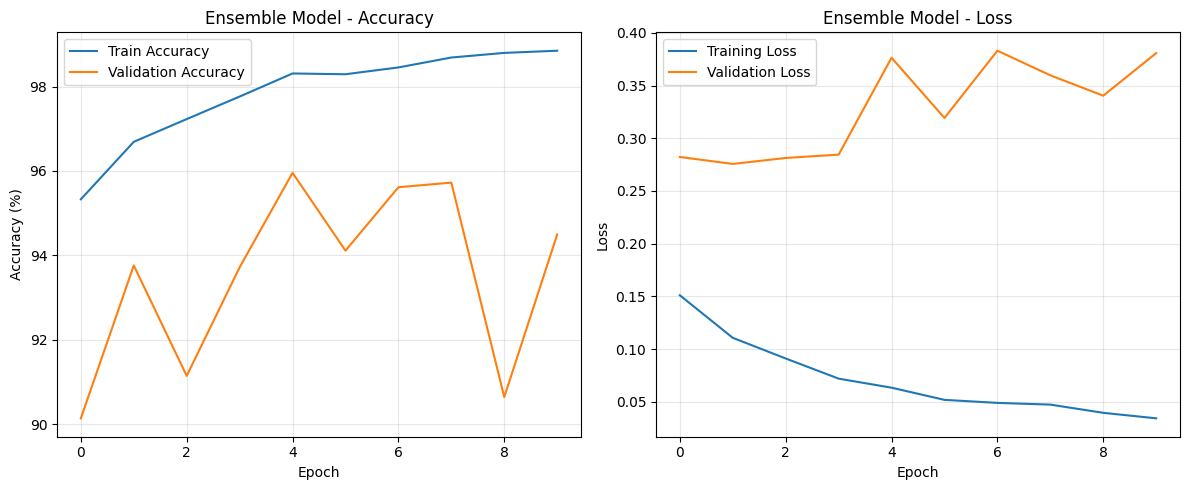


Evaluating Ensemble Model...


Getting predictions: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]



Ensemble Model Classification Report:
              precision    recall  f1-score   support

          no       0.85      0.99      0.91      2500
        vort       0.95      0.91      0.93      2500
      sphere       0.95      0.83      0.89      2500

    accuracy                           0.91      7500
   macro avg       0.92      0.91      0.91      7500
weighted avg       0.92      0.91      0.91      7500



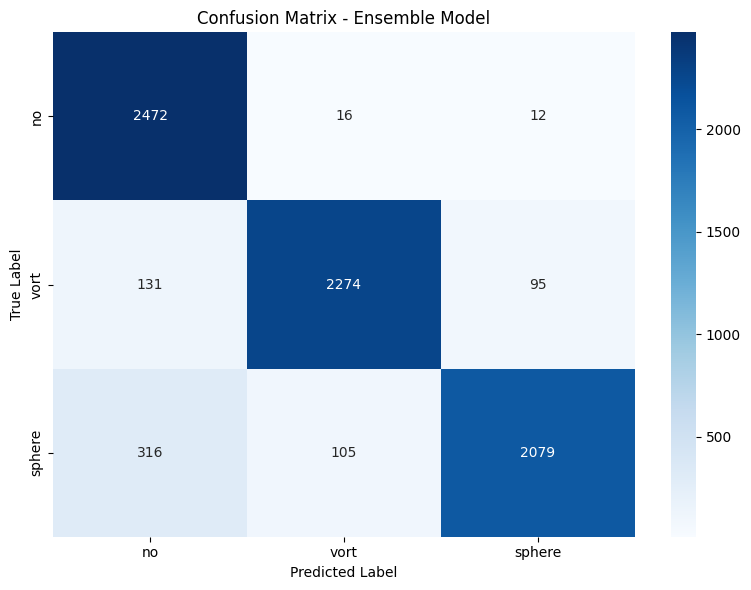

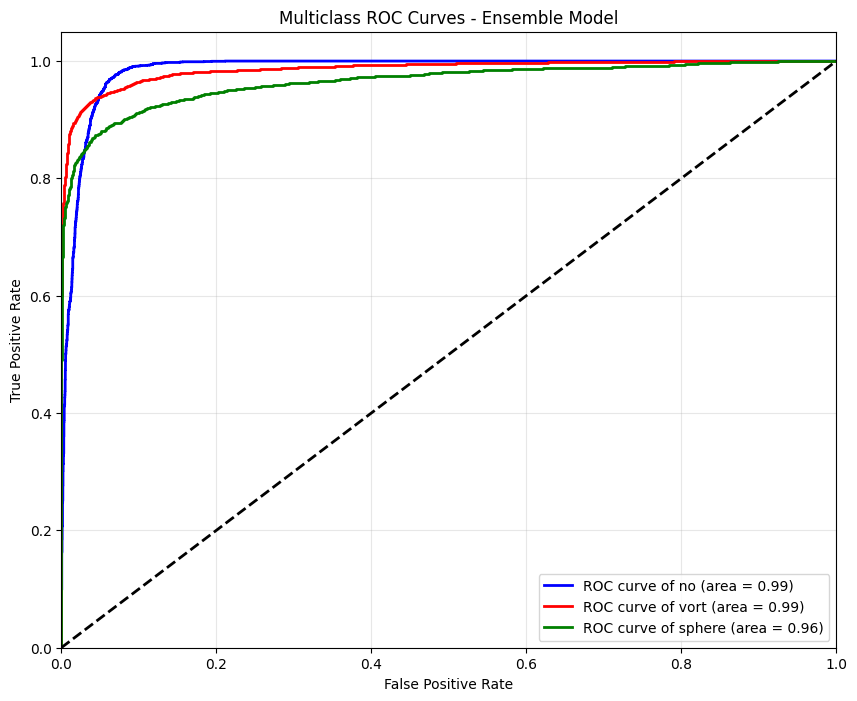

AUC (OVO): 0.9786
AUC (OVR): 0.9786

Re-evaluating DenseNet161 and DenseNet201 for combined prediction...


Getting predictions: 100%|██████████| 118/118 [00:10<00:00, 10.93it/s]


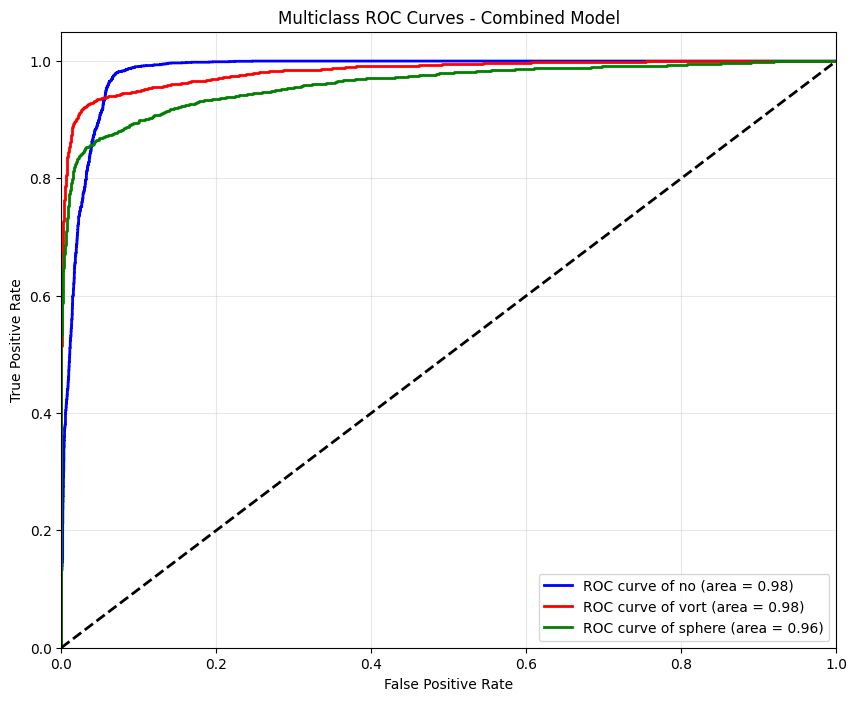

AUC (OVO): 0.9750
AUC (OVR): 0.9750


In [14]:
#%% Cell 3: Ensemble – Training and Evaluation

import os, gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
gc.collect()

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Before training the ensemble, load the best DenseNet161 and DenseNet201 models from Kaggle working directory.
print("Loading best DenseNet161 and DenseNet201 models for ensemble...")
densenet161_model = DenseNet161Model().to(device)
densenet201_model = DenseNet201Model().to(device)

densenet161_model.load_state_dict(torch.load('/kaggle/working/densenet161_best.pth', map_location=device))
densenet201_model.load_state_dict(torch.load('/kaggle/working/densenet201_best.pth', map_location=device))

# Optionally set these to eval mode if you want to freeze them for the ensemble
densenet161_model.eval()
densenet201_model.eval()

# Create the ensemble model and move to device
ensemble_model = DenseNetEnsemble(
    n_classes=len(classes),
    modela=densenet161_model,
    modelb=densenet201_model
).to(device)

optimizer_ensemble = torch.optim.Adam(ensemble_model.parameters(), lr=CONFIG.LEARNING_RATE)
history_ensemble = defaultdict(list)
best_accuracy_ensemble = 0

for epoch in range(CONFIG.ENSEMBLE_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{CONFIG.ENSEMBLE_EPOCHS} - Training Ensemble Model")
    print('-' * 20)
    
    train_accuracy, train_loss = train_one_epoch(
        model=ensemble_model,
        optimizer=optimizer_ensemble,
        data_loader=train_loader
    )
    
    train_accuracy = convert_tensor_list_to_single_mean_value(train_accuracy)
    train_loss = convert_tensor_list_to_single_mean_value(train_loss)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.2f}%')
    
    val_accuracy, val_loss, y_test, y_pred, y_probs = test_model(
        model=ensemble_model,
        data_loader=val_loader
    )
    
    val_accuracy = convert_tensor_list_to_single_mean_value(val_accuracy)
    val_loss = convert_tensor_list_to_single_mean_value(val_loss)
    print(f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.2f}%')
    
    history_ensemble['train_acc'].append(train_accuracy)
    history_ensemble['train_loss'].append(train_loss)
    history_ensemble['val_acc'].append(val_accuracy)
    history_ensemble['val_loss'].append(val_loss)
    
    if val_accuracy > best_accuracy_ensemble:
        torch.save(ensemble_model.state_dict(), '/kaggle/working/ensemble_best.pth')
        best_accuracy_ensemble = val_accuracy
        print(f"New best Ensemble model saved with accuracy: {best_accuracy_ensemble:.2f}%")

# # Free memory before reinitializing for evaluation
# del optimizer_ensemble, history_ensemble, densenet161_model, densenet201_model, ensemble_model
# torch.cuda.empty_cache()
# gc.collect()

# Reinitialize and load saved Ensemble model for inference/evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Reinitialize the sub-models
densenet161_model = DenseNet161Model().to(device)
densenet201_model = DenseNet201Model().to(device)
densenet161_model.load_state_dict(torch.load('/kaggle/working/densenet161_best.pth', map_location=device))
densenet201_model.load_state_dict(torch.load('/kaggle/working/densenet201_best.pth', map_location=device))
# Recreate ensemble model
ensemble_model = DenseNetEnsemble(n_classes=len(classes), modela=densenet161_model, modelb=densenet201_model).to(device)
ensemble_model.load_state_dict(torch.load('/kaggle/working/ensemble_best.pth', map_location=device))
ensemble_model.eval()

print("Ensemble model is ready for inference/evaluation.")

# -------------------------------
# Evaluation Code for Ensemble Model
# -------------------------------

# Plot training history for Ensemble Model
generate_acc_loss_plots(history_ensemble, "Ensemble Model")

# Get predictions for Ensemble Model
print("\nEvaluating Ensemble Model...")
y_test_ens, y_pred_ens, y_pred_prob_ens = get_model_predictions(ensemble_model, val_loader)

# Display classification report
print("\nEnsemble Model Classification Report:")
print(classification_report(y_test_ens, y_pred_ens, target_names=[idx_to_class[i] for i in range(len(classes))]))

# Plot confusion matrix for Ensemble Model
plot_confusion_matrix(y_test_ens, y_pred_ens, "Ensemble Model")

# Plot ROC curve for Ensemble Model
plot_roc_curves(y_test_ens, y_pred_prob_ens, class_names, "Ensemble Model")

# -------------------------------
# Combined Model Evaluation: Average predictions of all models
# -------------------------------
print("\nRe-evaluating DenseNet161 and DenseNet201 for combined prediction...")
y_test_161, y_pred_161, y_pred_prob_161 = get_model_predictions(densenet161_model, val_loader)
y_test_201, y_pred_201, y_pred_prob_201 = get_model_predictions(densenet201_model, val_loader)

combined_pred_prob = (y_pred_prob_161 + y_pred_prob_201 + y_pred_prob_ens) / 3
plot_roc_curves(y_test_ens, combined_pred_prob, class_names, "Combined Model")

# -------------------------------
# End of Ensemble Cell
# -------------------------------
